<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/from_crash/main_convnextv2_cot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1101, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 1101 (delta 72), reused 82 (delta 30), pack-reused 960 (from 1)
Receiving objects: 100% (1101/1101), 12.99 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (717/717), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.33% complete (down: 20356.1 kB/s up: 585.7 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[1

## Load data

In [7]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [9]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

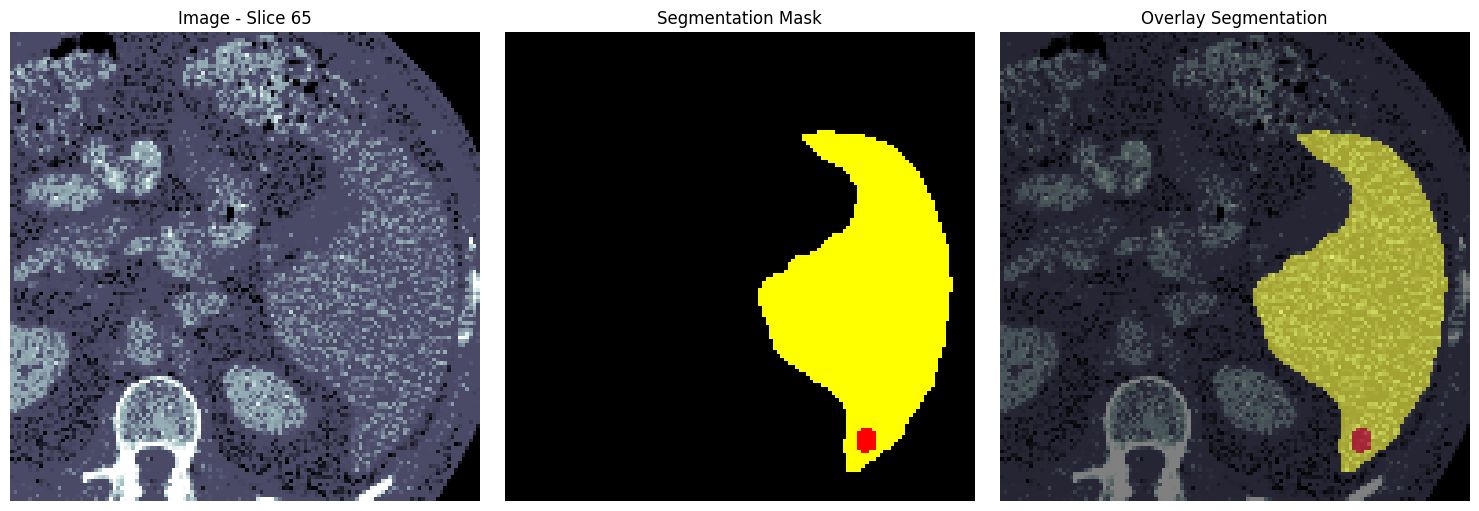

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    label_data = label_sample[0, 0].numpy()  # shape: [128, 128, 128]
    image_data = image_sample[0, 0].numpy()

    # Tìm tất cả slice index có tumor
    tumor_slices = np.any(label_data == 2, axis=(1, 2))


    slice_idx = np.argmax(tumor_slices)

    img_slice = image_data[slice_idx, :, :]
    label_slice = label_data[slice_idx, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break

## Model

In [10]:
model = ModelFactory.get_model("unet3d_convnextv2_cot",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 1323203


## Training

In [11]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [12]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    dices_tumor,
    dices_avg,
    loss_epochs,
    trains_epoch,
    ious_liver,
    ious_tumor,
    ious_avg,
    precisions_liver,
    precisions_tumor,
    precisions_avg,
    recalls_liver,
    recalls_tumor,
    recalls_avg,
    time_tmp,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.7898 time 8.80s
Epoch 1/100 2/105 loss: 0.7533 time 4.41s
Epoch 1/100 3/105 loss: 0.7264 time 2.84s
Epoch 1/100 4/105 loss: 0.6906 time 1.38s
Epoch 1/100 5/105 loss: 0.6628 time 8.94s
Epoch 1/100 6/105 loss: 0.6367 time 5.14s
Epoch 1/100 7/105 loss: 0.6117 time 3.38s
Epoch 1/100 8/105 loss: 0.5918 time 1.40s
Epoch 1/100 9/105 loss: 0.5767 time 1.40s
Epoch 1/100 10/105 loss: 0.5619 time 5.66s
Epoch 1/100 11/105 loss: 0.5478 time 2.15s
Epoch 1/100 12/105 loss: 0.5386 time 7.37s
Epoch 1/100 13/105 loss: 0.5290 time 3.03s
Epoch 1/100 14/105 loss: 0.5238 time 5.99s
Epoch 1/100 15/105 loss: 0.5172 time 6.11s
Epoch 1/100 16/105 loss: 0.5121 time 5.65s
Epoch 1/100 17/105 loss: 0.5052 time 6.87s
Epoch 1/100 18/105 loss: 0.5022 time 1.40s
Epoch 1/100 19/105 loss: 0.4995 time 4.37s
Epoch 1/100 20/105 loss: 0.4996 time 1.67s
Epoch 1/100 21/105 loss: 0.4966 time 2.11s
Epoch 1/100 22/105 loss: 0.4929 time 6.65s
Epoch 1/100 23/105 loss: 0.4899 time 7.43s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.4163] ---[time 430.00s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.4163] ---[time 430.00s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.4163 time 7.29s


Val 1/100 1/26, Dice_Liver: 0.294385, Dice_Tumor: 0.000000, Dice_Avg: 0.147192, time 7.07s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.294385, Dice_Tumor: 0.000000, Dice_Avg: 0.147192, time 7.07s
Val 1/100 2/26, Dice_Liver: 0.345465, Dice_Tumor: 0.000000, Dice_Avg: 0.172733, time 1.96s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.345465, Dice_Tumor: 0.000000, Dice_Avg: 0.172733, time 1.96s
Val 1/100 3/26, Dice_Liver: 0.413132, Dice_Tumor: 0.000000, Dice_Avg: 0.206566, time 1.81s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.413132, Dice_Tumor: 0.000000, Dice_Avg: 0.206566, time 1.81s
Val 1/100 4/26, Dice_Liver: 0.309849, Dice_Tumor: 0.000000, Dice_Avg: 0.154924, time 5.96s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.309849, Dice_Tumor: 0.000000, Dice_Avg: 0.154924, time 5.96s
Val 1/100 5/26, Dice_Liver: 0.297596, Dice_Tumor: 0.000000, Dice_Avg: 0.148798, time 1.03s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.297596, Dice_Tumor: 0.000000, Dice_A

New best (0.000000 --> 0.200298). At epoch 1


Epoch 1/100 ---[loss: 0.4163] ---[val_dice: 0.200298] ---[time 100.82s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.4163] ---[val_dice: 0.200298] ---[time 100.82s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.3793 time 2.96s
Epoch 2/100 2/105 loss: 0.3773 time 2.86s
Epoch 2/100 3/105 loss: 0.3796 time 6.13s
Epoch 2/100 4/105 loss: 0.3851 time 1.46s
Epoch 2/100 5/105 loss: 0.3878 time 5.72s
Epoch 2/100 6/105 loss: 0.3882 time 3.88s
Epoch 2/100 7/105 loss: 0.3871 time 5.03s
Epoch 2/100 8/105 loss: 0.3858 time 1.45s
Epoch 2/100 9/105 loss: 0.3842 time 1.45s
Epoch 2/100 10/105 loss: 0.3821 time 3.99s
Epoch 2/100 11/105 loss: 0.3839 time 1.88s
Epoch 2/100 12/105 loss: 0.3922 time 1.48s
Epoch 2/100 13/105 loss: 0.3907 time 5.70s
Epoch 2/100 14/105 loss: 0.3913 time 1.57s
Epoch 2/100 15/105 loss: 0.3912 time 7.67s
Epoch 2/100 16/105 loss: 0.3890 time 4.78s
Epoch 2/100 17/105 loss: 0.3885 time 6.83s
Epoch 2/100 18/105 loss: 0.3877 time 1.44s
Epoch 2/100 19/105 loss: 0.3869 time 5.05s
Epoch 2/100 20/105 loss: 0.3871 time 1.45s
Epoch 2/100 21/105 loss: 0.3861 time 5.57s
Epoch 2/100 22/105 loss: 0.3855 time 5.31s
Epoch 2/100 23/105 loss: 0.3865 time 5.13s
Epoch 2/100 24/105 l

Final training epochs: 2/100 ---[loss: 0.3872] ---[time 414.68s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.3872] ---[time 414.68s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.3872 time 1.43s


Val 2/100 1/26, Dice_Liver: 0.882054, Dice_Tumor: 0.000000, Dice_Avg: 0.441027, time 4.29s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.882054, Dice_Tumor: 0.000000, Dice_Avg: 0.441027, time 4.29s
Val 2/100 2/26, Dice_Liver: 0.746123, Dice_Tumor: 0.000000, Dice_Avg: 0.373062, time 4.95s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.746123, Dice_Tumor: 0.000000, Dice_Avg: 0.373062, time 4.95s
Val 2/100 3/26, Dice_Liver: 0.753329, Dice_Tumor: 0.000000, Dice_Avg: 0.376664, time 1.87s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.753329, Dice_Tumor: 0.000000, Dice_Avg: 0.376664, time 1.87s
Val 2/100 4/26, Dice_Liver: 0.706717, Dice_Tumor: 0.000000, Dice_Avg: 0.353359, time 5.79s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.706717, Dice_Tumor: 0.000000, Dice_Avg: 0.353359, time 5.79s
Val 2/100 5/26, Dice_Liver: 0.685354, Dice_Tumor: 0.000000, Dice_Avg: 0.342677, time 1.12s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.685354, Dice_Tumor: 0.000000, Dice_A

New best (0.200298 --> 0.379185). At epoch 2
Epoch 3/100 1/105 loss: 0.3908 time 7.22s
Epoch 3/100 2/105 loss: 0.3867 time 5.50s
Epoch 3/100 3/105 loss: 0.3863 time 4.02s
Epoch 3/100 4/105 loss: 0.3890 time 1.50s
Epoch 3/100 5/105 loss: 0.3880 time 1.46s
Epoch 3/100 6/105 loss: 0.3867 time 1.46s
Epoch 3/100 7/105 loss: 0.3846 time 4.68s
Epoch 3/100 8/105 loss: 0.3805 time 6.90s
Epoch 3/100 9/105 loss: 0.3859 time 6.19s
Epoch 3/100 10/105 loss: 0.3843 time 6.00s
Epoch 3/100 11/105 loss: 0.3784 time 5.61s
Epoch 3/100 12/105 loss: 0.3781 time 1.45s
Epoch 3/100 13/105 loss: 0.3780 time 4.82s
Epoch 3/100 14/105 loss: 0.3749 time 6.03s
Epoch 3/100 15/105 loss: 0.3720 time 2.01s
Epoch 3/100 16/105 loss: 0.3716 time 2.39s
Epoch 3/100 17/105 loss: 0.3728 time 5.47s
Epoch 3/100 18/105 loss: 0.3742 time 1.54s
Epoch 3/100 19/105 loss: 0.3694 time 6.65s
Epoch 3/100 20/105 loss: 0.3703 time 4.70s
Epoch 3/100 21/105 loss: 0.3725 time 1.45s
Epoch 3/100 22/105 loss: 0.3749 time 2.05s
Epoch 3/100 23/105

Final training epochs: 3/100 ---[loss: 0.3813] ---[time 444.30s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.3813] ---[time 444.30s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.3813 time 6.36s


Val 3/100 1/26, Dice_Liver: 0.082041, Dice_Tumor: 0.000000, Dice_Avg: 0.041021, time 4.51s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.082041, Dice_Tumor: 0.000000, Dice_Avg: 0.041021, time 4.51s
Val 3/100 2/26, Dice_Liver: 0.041021, Dice_Tumor: 0.000000, Dice_Avg: 0.020510, time 5.26s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.041021, Dice_Tumor: 0.000000, Dice_Avg: 0.020510, time 5.26s
Val 3/100 3/26, Dice_Liver: 0.229228, Dice_Tumor: 0.003584, Dice_Avg: 0.116406, time 1.76s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.229228, Dice_Tumor: 0.003584, Dice_Avg: 0.116406, time 1.76s
Val 3/100 4/26, Dice_Liver: 0.291563, Dice_Tumor: 0.066688, Dice_Avg: 0.179125, time 5.82s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.291563, Dice_Tumor: 0.066688, Dice_Avg: 0.179125, time 5.82s
Val 3/100 5/26, Dice_Liver: 0.282497, Dice_Tumor: 0.053351, Dice_Avg: 0.167924, time 1.05s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.282497, Dice_Tumor: 0.053351, Dice_A

Epoch 4/100 1/105 loss: 0.3860 time 3.55s
Epoch 4/100 2/105 loss: 0.3771 time 1.45s
Epoch 4/100 3/105 loss: 0.3836 time 3.17s
Epoch 4/100 4/105 loss: 0.3794 time 1.99s
Epoch 4/100 5/105 loss: 0.3855 time 1.48s
Epoch 4/100 6/105 loss: 0.3840 time 4.87s
Epoch 4/100 7/105 loss: 0.3797 time 6.46s
Epoch 4/100 8/105 loss: 0.3804 time 1.61s
Epoch 4/100 9/105 loss: 0.3801 time 5.49s
Epoch 4/100 10/105 loss: 0.3716 time 5.23s
Epoch 4/100 11/105 loss: 0.3741 time 2.99s
Epoch 4/100 12/105 loss: 0.3715 time 3.07s
Epoch 4/100 13/105 loss: 0.3723 time 5.74s
Epoch 4/100 14/105 loss: 0.3750 time 1.45s
Epoch 4/100 15/105 loss: 0.3761 time 1.44s
Epoch 4/100 16/105 loss: 0.3769 time 5.43s
Epoch 4/100 17/105 loss: 0.3770 time 6.03s
Epoch 4/100 18/105 loss: 0.3817 time 1.48s
Epoch 4/100 19/105 loss: 0.3809 time 1.76s
Epoch 4/100 20/105 loss: 0.3767 time 1.95s
Epoch 4/100 21/105 loss: 0.3768 time 7.58s
Epoch 4/100 22/105 loss: 0.3760 time 6.55s
Epoch 4/100 23/105 loss: 0.3758 time 4.20s
Epoch 4/100 24/105 l

Final training epochs: 4/100 ---[loss: 0.3709] ---[time 434.47s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.3709] ---[time 434.47s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.3709 time 5.70s


Val 4/100 1/26, Dice_Liver: 0.573429, Dice_Tumor: 0.000000, Dice_Avg: 0.286715, time 4.86s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.573429, Dice_Tumor: 0.000000, Dice_Avg: 0.286715, time 4.86s
Val 4/100 2/26, Dice_Liver: 0.321299, Dice_Tumor: 0.008842, Dice_Avg: 0.165071, time 4.64s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.321299, Dice_Tumor: 0.008842, Dice_Avg: 0.165071, time 4.64s
Val 4/100 3/26, Dice_Liver: 0.524620, Dice_Tumor: 0.084911, Dice_Avg: 0.304766, time 2.06s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.524620, Dice_Tumor: 0.084911, Dice_Avg: 0.304766, time 2.06s
Val 4/100 4/26, Dice_Liver: 0.618162, Dice_Tumor: 0.074960, Dice_Avg: 0.346561, time 6.55s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.618162, Dice_Tumor: 0.074960, Dice_Avg: 0.346561, time 6.55s
Val 4/100 5/26, Dice_Liver: 0.660883, Dice_Tumor: 0.060611, Dice_Avg: 0.360747, time 1.07s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.660883, Dice_Tumor: 0.060611, Dice_A

New best (0.379185 --> 0.400687). At epoch 4
Epoch 5/100 1/105 loss: 0.3884 time 6.78s
Epoch 5/100 2/105 loss: 0.4008 time 2.38s
Epoch 5/100 3/105 loss: 0.3829 time 1.87s
Epoch 5/100 4/105 loss: 0.3744 time 2.60s
Epoch 5/100 5/105 loss: 0.3802 time 5.58s
Epoch 5/100 6/105 loss: 0.3716 time 1.77s
Epoch 5/100 7/105 loss: 0.3744 time 5.18s
Epoch 5/100 8/105 loss: 0.3704 time 6.44s
Epoch 5/100 9/105 loss: 0.3722 time 2.48s
Epoch 5/100 10/105 loss: 0.3636 time 1.42s
Epoch 5/100 11/105 loss: 0.3639 time 6.54s
Epoch 5/100 12/105 loss: 0.3668 time 2.08s
Epoch 5/100 13/105 loss: 0.3681 time 8.50s
Epoch 5/100 14/105 loss: 0.3636 time 4.11s
Epoch 5/100 15/105 loss: 0.3648 time 5.42s
Epoch 5/100 16/105 loss: 0.3653 time 5.93s
Epoch 5/100 17/105 loss: 0.3733 time 1.42s
Epoch 5/100 18/105 loss: 0.3685 time 5.13s
Epoch 5/100 19/105 loss: 0.3671 time 1.64s
Epoch 5/100 20/105 loss: 0.3616 time 1.80s
Epoch 5/100 21/105 loss: 0.3615 time 5.97s
Epoch 5/100 22/105 loss: 0.3627 time 5.31s
Epoch 5/100 23/105

Final training epochs: 5/100 ---[loss: 0.3590] ---[time 428.62s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3590] ---[time 428.62s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3590 time 5.16s


Val 5/100 1/26, Dice_Liver: 0.655136, Dice_Tumor: 0.000000, Dice_Avg: 0.327568, time 4.71s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.655136, Dice_Tumor: 0.000000, Dice_Avg: 0.327568, time 4.71s
Val 5/100 2/26, Dice_Liver: 0.609267, Dice_Tumor: 0.000000, Dice_Avg: 0.304633, time 5.34s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.609267, Dice_Tumor: 0.000000, Dice_Avg: 0.304633, time 5.34s
Val 5/100 3/26, Dice_Liver: 0.634348, Dice_Tumor: 0.000000, Dice_Avg: 0.317174, time 1.95s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.634348, Dice_Tumor: 0.000000, Dice_Avg: 0.317174, time 1.95s
Val 5/100 4/26, Dice_Liver: 0.662839, Dice_Tumor: 0.000000, Dice_Avg: 0.331420, time 5.99s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.662839, Dice_Tumor: 0.000000, Dice_Avg: 0.331420, time 5.99s
Val 5/100 5/26, Dice_Liver: 0.654518, Dice_Tumor: 0.000000, Dice_Avg: 0.327259, time 1.15s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.654518, Dice_Tumor: 0.000000, Dice_A

Epoch 6/100 1/105 loss: 0.3823 time 7.00s
Epoch 6/100 2/105 loss: 0.3934 time 4.16s
Epoch 6/100 3/105 loss: 0.3837 time 1.52s
Epoch 6/100 4/105 loss: 0.3774 time 2.88s
Epoch 6/100 5/105 loss: 0.3778 time 1.37s
Epoch 6/100 6/105 loss: 0.3766 time 1.39s
Epoch 6/100 7/105 loss: 0.3782 time 1.38s
Epoch 6/100 8/105 loss: 0.3789 time 5.68s
Epoch 6/100 9/105 loss: 0.3627 time 4.32s
Epoch 6/100 10/105 loss: 0.3635 time 8.70s
Epoch 6/100 11/105 loss: 0.3638 time 5.77s
Epoch 6/100 12/105 loss: 0.3590 time 1.39s
Epoch 6/100 13/105 loss: 0.3649 time 5.99s
Epoch 6/100 14/105 loss: 0.3673 time 5.92s
Epoch 6/100 15/105 loss: 0.3682 time 6.28s
Epoch 6/100 16/105 loss: 0.3657 time 4.91s
Epoch 6/100 17/105 loss: 0.3671 time 5.54s
Epoch 6/100 18/105 loss: 0.3604 time 5.06s
Epoch 6/100 19/105 loss: 0.3626 time 8.69s
Epoch 6/100 20/105 loss: 0.3652 time 3.74s
Epoch 6/100 21/105 loss: 0.3635 time 2.86s
Epoch 6/100 22/105 loss: 0.3623 time 1.83s
Epoch 6/100 23/105 loss: 0.3632 time 2.63s
Epoch 6/100 24/105 l

Final training epochs: 6/100 ---[loss: 0.3511] ---[time 456.02s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3511] ---[time 456.02s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3511 time 1.46s


Val 6/100 1/26, Dice_Liver: 0.833542, Dice_Tumor: 0.000000, Dice_Avg: 0.416771, time 5.38s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.833542, Dice_Tumor: 0.000000, Dice_Avg: 0.416771, time 5.38s
Val 6/100 2/26, Dice_Liver: 0.661990, Dice_Tumor: 0.004950, Dice_Avg: 0.333470, time 4.84s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.661990, Dice_Tumor: 0.004950, Dice_Avg: 0.333470, time 4.84s
Val 6/100 3/26, Dice_Liver: 0.734230, Dice_Tumor: 0.003300, Dice_Avg: 0.368765, time 2.09s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.734230, Dice_Tumor: 0.003300, Dice_Avg: 0.368765, time 2.09s
Val 6/100 4/26, Dice_Liver: 0.758404, Dice_Tumor: 0.002475, Dice_Avg: 0.380440, time 6.53s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.758404, Dice_Tumor: 0.002475, Dice_Avg: 0.380440, time 6.53s
Val 6/100 5/26, Dice_Liver: 0.752170, Dice_Tumor: 0.001980, Dice_Avg: 0.377075, time 1.12s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.752170, Dice_Tumor: 0.001980, Dice_A

Epoch 7/100 1/105 loss: 0.4100 time 5.40s
Epoch 7/100 2/105 loss: 0.3962 time 1.60s
Epoch 7/100 3/105 loss: 0.3460 time 2.05s
Epoch 7/100 4/105 loss: 0.3462 time 2.46s
Epoch 7/100 5/105 loss: 0.3548 time 9.57s
Epoch 7/100 6/105 loss: 0.3333 time 4.88s
Epoch 7/100 7/105 loss: 0.3402 time 8.48s
Epoch 7/100 8/105 loss: 0.3431 time 1.62s
Epoch 7/100 9/105 loss: 0.3473 time 7.75s
Epoch 7/100 10/105 loss: 0.3536 time 1.60s
Epoch 7/100 11/105 loss: 0.3559 time 6.53s
Epoch 7/100 12/105 loss: 0.3588 time 1.44s
Epoch 7/100 13/105 loss: 0.3630 time 1.85s
Epoch 7/100 14/105 loss: 0.3656 time 1.47s
Epoch 7/100 15/105 loss: 0.3680 time 7.08s
Epoch 7/100 16/105 loss: 0.3652 time 6.61s
Epoch 7/100 17/105 loss: 0.3640 time 5.21s
Epoch 7/100 18/105 loss: 0.3618 time 11.87s
Epoch 7/100 19/105 loss: 0.3561 time 1.66s
Epoch 7/100 20/105 loss: 0.3583 time 4.62s
Epoch 7/100 21/105 loss: 0.3580 time 6.08s
Epoch 7/100 22/105 loss: 0.3590 time 1.79s
Epoch 7/100 23/105 loss: 0.3579 time 1.75s
Epoch 7/100 24/105 

Final training epochs: 7/100 ---[loss: 0.3479] ---[time 459.28s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.3479] ---[time 459.28s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.3479 time 1.44s


Val 7/100 1/26, Dice_Liver: 0.667600, Dice_Tumor: 0.000000, Dice_Avg: 0.333800, time 4.98s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.667600, Dice_Tumor: 0.000000, Dice_Avg: 0.333800, time 4.98s
Val 7/100 2/26, Dice_Liver: 0.351334, Dice_Tumor: 0.010176, Dice_Avg: 0.180755, time 5.34s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.351334, Dice_Tumor: 0.010176, Dice_Avg: 0.180755, time 5.34s
Val 7/100 3/26, Dice_Liver: 0.539366, Dice_Tumor: 0.018515, Dice_Avg: 0.278940, time 1.82s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.539366, Dice_Tumor: 0.018515, Dice_Avg: 0.278940, time 1.82s
Val 7/100 4/26, Dice_Liver: 0.620915, Dice_Tumor: 0.016298, Dice_Avg: 0.318606, time 6.29s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.620915, Dice_Tumor: 0.016298, Dice_Avg: 0.318606, time 6.29s
Val 7/100 5/26, Dice_Liver: 0.662719, Dice_Tumor: 0.015318, Dice_Avg: 0.339019, time 1.09s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.662719, Dice_Tumor: 0.015318, Dice_A

New best (0.400687 --> 0.410229). At epoch 7
Epoch 8/100 1/105 loss: 0.2532 time 4.00s
Epoch 8/100 2/105 loss: 0.3324 time 3.59s
Epoch 8/100 3/105 loss: 0.3447 time 1.45s
Epoch 8/100 4/105 loss: 0.3555 time 1.64s
Epoch 8/100 5/105 loss: 0.3594 time 7.41s
Epoch 8/100 6/105 loss: 0.3292 time 4.90s
Epoch 8/100 7/105 loss: 0.3385 time 7.41s
Epoch 8/100 8/105 loss: 0.3414 time 4.98s
Epoch 8/100 9/105 loss: 0.3502 time 8.10s
Epoch 8/100 10/105 loss: 0.3476 time 5.97s
Epoch 8/100 11/105 loss: 0.3383 time 8.75s
Epoch 8/100 12/105 loss: 0.3355 time 5.41s
Epoch 8/100 13/105 loss: 0.3356 time 1.64s
Epoch 8/100 14/105 loss: 0.3324 time 2.00s
Epoch 8/100 15/105 loss: 0.3300 time 2.98s
Epoch 8/100 16/105 loss: 0.3364 time 2.41s
Epoch 8/100 17/105 loss: 0.3374 time 6.29s
Epoch 8/100 18/105 loss: 0.3349 time 6.03s
Epoch 8/100 19/105 loss: 0.3368 time 7.57s
Epoch 8/100 20/105 loss: 0.3389 time 5.40s
Epoch 8/100 21/105 loss: 0.3397 time 6.81s
Epoch 8/100 22/105 loss: 0.3383 time 7.19s
Epoch 8/100 23/105

Final training epochs: 8/100 ---[loss: 0.3439] ---[time 456.70s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.3439] ---[time 456.70s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.3439 time 5.87s


Val 8/100 1/26, Dice_Liver: 0.835726, Dice_Tumor: 0.000000, Dice_Avg: 0.417863, time 4.75s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.835726, Dice_Tumor: 0.000000, Dice_Avg: 0.417863, time 4.75s
Val 8/100 2/26, Dice_Liver: 0.532551, Dice_Tumor: 0.010098, Dice_Avg: 0.271325, time 5.00s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.532551, Dice_Tumor: 0.010098, Dice_Avg: 0.271325, time 5.00s
Val 8/100 3/26, Dice_Liver: 0.665118, Dice_Tumor: 0.014956, Dice_Avg: 0.340037, time 2.06s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.665118, Dice_Tumor: 0.014956, Dice_Avg: 0.340037, time 2.06s
Val 8/100 4/26, Dice_Liver: 0.707279, Dice_Tumor: 0.013602, Dice_Avg: 0.360441, time 6.57s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.707279, Dice_Tumor: 0.013602, Dice_Avg: 0.360441, time 6.57s
Val 8/100 5/26, Dice_Liver: 0.738605, Dice_Tumor: 0.011762, Dice_Avg: 0.375184, time 1.35s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.738605, Dice_Tumor: 0.011762, Dice_A

New best (0.410229 --> 0.451043). At epoch 8
Epoch 9/100 1/105 loss: 0.3083 time 2.75s
Epoch 9/100 2/105 loss: 0.3391 time 7.79s
Epoch 9/100 3/105 loss: 0.3526 time 1.69s
Epoch 9/100 4/105 loss: 0.3619 time 3.09s
Epoch 9/100 5/105 loss: 0.3591 time 6.09s
Epoch 9/100 6/105 loss: 0.3698 time 1.46s
Epoch 9/100 7/105 loss: 0.3644 time 5.32s
Epoch 9/100 8/105 loss: 0.3507 time 5.42s
Epoch 9/100 9/105 loss: 0.3631 time 2.06s
Epoch 9/100 10/105 loss: 0.3642 time 8.16s
Epoch 9/100 11/105 loss: 0.3632 time 8.55s
Epoch 9/100 12/105 loss: 0.3635 time 1.44s
Epoch 9/100 13/105 loss: 0.3659 time 1.65s
Epoch 9/100 14/105 loss: 0.3680 time 5.90s
Epoch 9/100 15/105 loss: 0.3686 time 5.63s
Epoch 9/100 16/105 loss: 0.3680 time 6.09s
Epoch 9/100 17/105 loss: 0.3703 time 6.45s
Epoch 9/100 18/105 loss: 0.3718 time 6.85s
Epoch 9/100 19/105 loss: 0.3629 time 1.98s
Epoch 9/100 20/105 loss: 0.3637 time 1.56s
Epoch 9/100 21/105 loss: 0.3570 time 5.95s
Epoch 9/100 22/105 loss: 0.3588 time 2.10s
Epoch 9/100 23/105

Final training epochs: 9/100 ---[loss: 0.3525] ---[time 460.73s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.3525] ---[time 460.73s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.3525 time 4.59s


Val 9/100 1/26, Dice_Liver: 0.792849, Dice_Tumor: 0.000000, Dice_Avg: 0.396424, time 5.67s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.792849, Dice_Tumor: 0.000000, Dice_Avg: 0.396424, time 5.67s
Val 9/100 2/26, Dice_Liver: 0.418459, Dice_Tumor: 0.010269, Dice_Avg: 0.214364, time 4.69s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.418459, Dice_Tumor: 0.010269, Dice_Avg: 0.214364, time 4.69s
Val 9/100 3/26, Dice_Liver: 0.585672, Dice_Tumor: 0.011730, Dice_Avg: 0.298701, time 1.85s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.585672, Dice_Tumor: 0.011730, Dice_Avg: 0.298701, time 1.85s
Val 9/100 4/26, Dice_Liver: 0.655456, Dice_Tumor: 0.010803, Dice_Avg: 0.333129, time 6.89s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.655456, Dice_Tumor: 0.010803, Dice_Avg: 0.333129, time 6.89s
Val 9/100 5/26, Dice_Liver: 0.699115, Dice_Tumor: 0.010311, Dice_Avg: 0.354713, time 1.11s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.699115, Dice_Tumor: 0.010311, Dice_A

Epoch 10/100 1/105 loss: 0.2576 time 3.04s
Epoch 10/100 2/105 loss: 0.3284 time 2.45s
Epoch 10/100 3/105 loss: 0.3411 time 6.02s
Epoch 10/100 4/105 loss: 0.3484 time 6.87s
Epoch 10/100 5/105 loss: 0.3359 time 6.32s
Epoch 10/100 6/105 loss: 0.3427 time 2.72s
Epoch 10/100 7/105 loss: 0.3494 time 7.91s
Epoch 10/100 8/105 loss: 0.3412 time 6.50s
Epoch 10/100 9/105 loss: 0.3333 time 5.33s
Epoch 10/100 10/105 loss: 0.3303 time 3.18s
Epoch 10/100 11/105 loss: 0.3289 time 8.16s
Epoch 10/100 12/105 loss: 0.3211 time 6.19s
Epoch 10/100 13/105 loss: 0.3216 time 6.45s
Epoch 10/100 14/105 loss: 0.3249 time 5.75s
Epoch 10/100 15/105 loss: 0.3304 time 1.45s
Epoch 10/100 16/105 loss: 0.3291 time 1.45s
Epoch 10/100 17/105 loss: 0.3330 time 2.22s
Epoch 10/100 18/105 loss: 0.3367 time 3.45s
Epoch 10/100 19/105 loss: 0.3334 time 1.65s
Epoch 10/100 20/105 loss: 0.3363 time 5.59s
Epoch 10/100 21/105 loss: 0.3382 time 9.02s
Epoch 10/100 22/105 loss: 0.3381 time 1.44s
Epoch 10/100 23/105 loss: 0.3402 time 4.3

Final training epochs: 10/100 ---[loss: 0.3363] ---[time 457.29s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.3363] ---[time 457.29s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.3363 time 5.99s


Val 10/100 1/26, Dice_Liver: 0.908220, Dice_Tumor: 0.000000, Dice_Avg: 0.454110, time 5.21s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.908220, Dice_Tumor: 0.000000, Dice_Avg: 0.454110, time 5.21s
Val 10/100 2/26, Dice_Liver: 0.788705, Dice_Tumor: 0.000000, Dice_Avg: 0.394352, time 5.84s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.788705, Dice_Tumor: 0.000000, Dice_Avg: 0.394352, time 5.84s
Val 10/100 3/26, Dice_Liver: 0.828156, Dice_Tumor: 0.000045, Dice_Avg: 0.414101, time 2.19s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.828156, Dice_Tumor: 0.000045, Dice_Avg: 0.414101, time 2.19s
Val 10/100 4/26, Dice_Liver: 0.813498, Dice_Tumor: 0.000034, Dice_Avg: 0.406766, time 6.54s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.813498, Dice_Tumor: 0.000034, Dice_Avg: 0.406766, time 6.54s
Val 10/100 5/26, Dice_Liver: 0.820141, Dice_Tumor: 0.000027, Dice_Avg: 0.410084, time 1.13s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.820141, Dice_Tumor: 0.0000

Epoch 11/100 1/105 loss: 0.2676 time 5.95s
Epoch 11/100 2/105 loss: 0.3276 time 1.52s
Epoch 11/100 3/105 loss: 0.3423 time 8.16s
Epoch 11/100 4/105 loss: 0.3248 time 1.46s
Epoch 11/100 5/105 loss: 0.3325 time 7.44s
Epoch 11/100 6/105 loss: 0.3327 time 2.97s
Epoch 11/100 7/105 loss: 0.3204 time 6.62s
Epoch 11/100 8/105 loss: 0.3260 time 6.71s
Epoch 11/100 9/105 loss: 0.3300 time 1.98s
Epoch 11/100 10/105 loss: 0.3249 time 3.32s
Epoch 11/100 11/105 loss: 0.3316 time 5.97s
Epoch 11/100 12/105 loss: 0.3364 time 1.45s
Epoch 11/100 13/105 loss: 0.3462 time 1.65s
Epoch 11/100 14/105 loss: 0.3551 time 2.32s
Epoch 11/100 15/105 loss: 0.3537 time 1.45s
Epoch 11/100 16/105 loss: 0.3572 time 5.27s
Epoch 11/100 17/105 loss: 0.3529 time 1.46s
Epoch 11/100 18/105 loss: 0.3575 time 1.59s
Epoch 11/100 19/105 loss: 0.3510 time 2.31s
Epoch 11/100 20/105 loss: 0.3541 time 3.73s
Epoch 11/100 21/105 loss: 0.3553 time 5.08s
Epoch 11/100 22/105 loss: 0.3589 time 6.18s
Epoch 11/100 23/105 loss: 0.3528 time 5.3

Final training epochs: 11/100 ---[loss: 0.3519] ---[time 461.77s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.3519] ---[time 461.77s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.3519 time 2.46s


Val 11/100 1/26, Dice_Liver: 0.732542, Dice_Tumor: 0.000000, Dice_Avg: 0.366271, time 5.21s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.732542, Dice_Tumor: 0.000000, Dice_Avg: 0.366271, time 5.21s
Val 11/100 2/26, Dice_Liver: 0.369441, Dice_Tumor: 0.002597, Dice_Avg: 0.186019, time 4.74s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.369441, Dice_Tumor: 0.002597, Dice_Avg: 0.186019, time 4.74s
Val 11/100 3/26, Dice_Liver: 0.545709, Dice_Tumor: 0.015649, Dice_Avg: 0.280679, time 2.28s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.545709, Dice_Tumor: 0.015649, Dice_Avg: 0.280679, time 2.28s
Val 11/100 4/26, Dice_Liver: 0.618663, Dice_Tumor: 0.089251, Dice_Avg: 0.353957, time 6.43s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.618663, Dice_Tumor: 0.089251, Dice_Avg: 0.353957, time 6.43s
Val 11/100 5/26, Dice_Liver: 0.660185, Dice_Tumor: 0.072296, Dice_Avg: 0.366241, time 1.05s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.660185, Dice_Tumor: 0.0722

Epoch 12/100 1/105 loss: 0.3789 time 9.59s
Epoch 12/100 2/105 loss: 0.3802 time 1.45s
Epoch 12/100 3/105 loss: 0.3467 time 4.25s
Epoch 12/100 4/105 loss: 0.3559 time 6.52s
Epoch 12/100 5/105 loss: 0.3494 time 1.66s
Epoch 12/100 6/105 loss: 0.3293 time 2.32s
Epoch 12/100 7/105 loss: 0.3286 time 1.45s
Epoch 12/100 8/105 loss: 0.3292 time 2.52s
Epoch 12/100 9/105 loss: 0.3260 time 1.64s
Epoch 12/100 10/105 loss: 0.3311 time 2.08s
Epoch 12/100 11/105 loss: 0.3326 time 4.62s
Epoch 12/100 12/105 loss: 0.3350 time 7.27s
Epoch 12/100 13/105 loss: 0.3279 time 1.73s
Epoch 12/100 14/105 loss: 0.3300 time 6.00s
Epoch 12/100 15/105 loss: 0.3344 time 6.61s
Epoch 12/100 16/105 loss: 0.3372 time 1.44s
Epoch 12/100 17/105 loss: 0.3384 time 6.59s
Epoch 12/100 18/105 loss: 0.3416 time 1.44s
Epoch 12/100 19/105 loss: 0.3387 time 7.84s
Epoch 12/100 20/105 loss: 0.3368 time 3.48s
Epoch 12/100 21/105 loss: 0.3385 time 2.52s
Epoch 12/100 22/105 loss: 0.3402 time 6.42s
Epoch 12/100 23/105 loss: 0.3404 time 5.7

Final training epochs: 12/100 ---[loss: 0.3344] ---[time 467.65s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.3344] ---[time 467.65s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.3344 time 1.68s


Val 12/100 1/26, Dice_Liver: 0.556264, Dice_Tumor: 0.000380, Dice_Avg: 0.278322, time 4.73s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.556264, Dice_Tumor: 0.000380, Dice_Avg: 0.278322, time 4.73s
Val 12/100 2/26, Dice_Liver: 0.278134, Dice_Tumor: 0.001484, Dice_Avg: 0.139809, time 5.26s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.278134, Dice_Tumor: 0.001484, Dice_Avg: 0.139809, time 5.26s
Val 12/100 3/26, Dice_Liver: 0.490785, Dice_Tumor: 0.019216, Dice_Avg: 0.255000, time 1.94s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.490785, Dice_Tumor: 0.019216, Dice_Avg: 0.255000, time 1.94s
Val 12/100 4/26, Dice_Liver: 0.583019, Dice_Tumor: 0.019322, Dice_Avg: 0.301171, time 6.36s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.583019, Dice_Tumor: 0.019322, Dice_Avg: 0.301171, time 6.36s
Val 12/100 5/26, Dice_Liver: 0.640074, Dice_Tumor: 0.020396, Dice_Avg: 0.330235, time 1.07s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.640074, Dice_Tumor: 0.0203

Epoch 13/100 1/105 loss: 0.3773 time 7.96s
Epoch 13/100 2/105 loss: 0.2982 time 5.04s
Epoch 13/100 3/105 loss: 0.3331 time 5.60s
Epoch 13/100 4/105 loss: 0.3515 time 3.44s
Epoch 13/100 5/105 loss: 0.3539 time 1.72s
Epoch 13/100 6/105 loss: 0.3599 time 7.67s
Epoch 13/100 7/105 loss: 0.3619 time 1.43s
Epoch 13/100 8/105 loss: 0.3600 time 1.46s
Epoch 13/100 9/105 loss: 0.3544 time 1.45s
Epoch 13/100 10/105 loss: 0.3567 time 5.53s
Epoch 13/100 11/105 loss: 0.3456 time 2.10s
Epoch 13/100 12/105 loss: 0.3388 time 10.65s
Epoch 13/100 13/105 loss: 0.3345 time 4.39s
Epoch 13/100 14/105 loss: 0.3306 time 6.17s
Epoch 13/100 15/105 loss: 0.3258 time 9.19s
Epoch 13/100 16/105 loss: 0.3266 time 5.61s
Epoch 13/100 17/105 loss: 0.3266 time 7.06s
Epoch 13/100 18/105 loss: 0.3243 time 1.45s
Epoch 13/100 19/105 loss: 0.3273 time 1.46s
Epoch 13/100 20/105 loss: 0.3295 time 1.43s
Epoch 13/100 21/105 loss: 0.3235 time 8.43s
Epoch 13/100 22/105 loss: 0.3265 time 1.55s
Epoch 13/100 23/105 loss: 0.3284 time 1.

Final training epochs: 13/100 ---[loss: 0.3352] ---[time 459.26s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.3352] ---[time 459.26s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.3352 time 6.10s


Val 13/100 1/26, Dice_Liver: 0.871252, Dice_Tumor: 0.000000, Dice_Avg: 0.435626, time 4.77s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.871252, Dice_Tumor: 0.000000, Dice_Avg: 0.435626, time 4.77s
Val 13/100 2/26, Dice_Liver: 0.800614, Dice_Tumor: 0.000884, Dice_Avg: 0.400749, time 4.80s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.800614, Dice_Tumor: 0.000884, Dice_Avg: 0.400749, time 4.80s
Val 13/100 3/26, Dice_Liver: 0.829605, Dice_Tumor: 0.012307, Dice_Avg: 0.420956, time 1.97s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.829605, Dice_Tumor: 0.012307, Dice_Avg: 0.420956, time 1.97s
Val 13/100 4/26, Dice_Liver: 0.837263, Dice_Tumor: 0.009231, Dice_Avg: 0.423247, time 6.82s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.837263, Dice_Tumor: 0.009231, Dice_Avg: 0.423247, time 6.82s
Val 13/100 5/26, Dice_Liver: 0.832228, Dice_Tumor: 0.007609, Dice_Avg: 0.419918, time 1.14s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.832228, Dice_Tumor: 0.0076

Epoch 14/100 1/105 loss: 0.3800 time 7.15s
Epoch 14/100 2/105 loss: 0.3735 time 6.16s
Epoch 14/100 3/105 loss: 0.3682 time 6.26s
Epoch 14/100 4/105 loss: 0.3670 time 1.50s
Epoch 14/100 5/105 loss: 0.3707 time 1.50s
Epoch 14/100 6/105 loss: 0.3731 time 6.74s
Epoch 14/100 7/105 loss: 0.3739 time 1.45s
Epoch 14/100 8/105 loss: 0.3733 time 6.66s
Epoch 14/100 9/105 loss: 0.3713 time 1.62s
Epoch 14/100 10/105 loss: 0.3671 time 5.54s
Epoch 14/100 11/105 loss: 0.3677 time 1.45s
Epoch 14/100 12/105 loss: 0.3700 time 6.02s
Epoch 14/100 13/105 loss: 0.3565 time 5.17s
Epoch 14/100 14/105 loss: 0.3459 time 1.84s
Epoch 14/100 15/105 loss: 0.3477 time 1.75s
Epoch 14/100 16/105 loss: 0.3393 time 5.53s
Epoch 14/100 17/105 loss: 0.3436 time 5.46s
Epoch 14/100 18/105 loss: 0.3482 time 1.45s
Epoch 14/100 19/105 loss: 0.3498 time 2.52s
Epoch 14/100 20/105 loss: 0.3426 time 1.73s
Epoch 14/100 21/105 loss: 0.3451 time 1.52s
Epoch 14/100 22/105 loss: 0.3380 time 5.37s
Epoch 14/100 23/105 loss: 0.3382 time 1.4

Final training epochs: 14/100 ---[loss: 0.3352] ---[time 458.72s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.3352] ---[time 458.72s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.3352 time 6.70s


Val 14/100 1/26, Dice_Liver: 0.884738, Dice_Tumor: 0.000000, Dice_Avg: 0.442369, time 5.48s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.884738, Dice_Tumor: 0.000000, Dice_Avg: 0.442369, time 5.48s
Val 14/100 2/26, Dice_Liver: 0.760815, Dice_Tumor: 0.009209, Dice_Avg: 0.385012, time 4.77s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.760815, Dice_Tumor: 0.009209, Dice_Avg: 0.385012, time 4.77s
Val 14/100 3/26, Dice_Liver: 0.814971, Dice_Tumor: 0.006140, Dice_Avg: 0.410555, time 2.30s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.814971, Dice_Tumor: 0.006140, Dice_Avg: 0.410555, time 2.30s
Val 14/100 4/26, Dice_Liver: 0.836754, Dice_Tumor: 0.051023, Dice_Avg: 0.443889, time 6.32s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.836754, Dice_Tumor: 0.051023, Dice_Avg: 0.443889, time 6.32s
Val 14/100 5/26, Dice_Liver: 0.835924, Dice_Tumor: 0.040818, Dice_Avg: 0.438371, time 1.05s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.835924, Dice_Tumor: 0.0408

Epoch 15/100 1/105 loss: 0.4032 time 7.34s
Epoch 15/100 2/105 loss: 0.3606 time 5.63s
Epoch 15/100 3/105 loss: 0.3176 time 1.95s
Epoch 15/100 4/105 loss: 0.3304 time 6.81s
Epoch 15/100 5/105 loss: 0.3158 time 1.64s
Epoch 15/100 6/105 loss: 0.2975 time 6.03s
Epoch 15/100 7/105 loss: 0.3035 time 5.89s
Epoch 15/100 8/105 loss: 0.3131 time 1.44s
Epoch 15/100 9/105 loss: 0.3089 time 8.02s
Epoch 15/100 10/105 loss: 0.3001 time 1.68s
Epoch 15/100 11/105 loss: 0.3070 time 5.37s
Epoch 15/100 12/105 loss: 0.3178 time 4.72s
Epoch 15/100 13/105 loss: 0.3209 time 7.20s
Epoch 15/100 14/105 loss: 0.3256 time 7.06s
Epoch 15/100 15/105 loss: 0.3296 time 6.48s
Epoch 15/100 16/105 loss: 0.3295 time 9.01s
Epoch 15/100 17/105 loss: 0.3213 time 1.79s
Epoch 15/100 18/105 loss: 0.3197 time 8.49s
Epoch 15/100 19/105 loss: 0.3192 time 1.78s
Epoch 15/100 20/105 loss: 0.3190 time 5.34s
Epoch 15/100 21/105 loss: 0.3237 time 6.48s
Epoch 15/100 22/105 loss: 0.3266 time 1.59s
Epoch 15/100 23/105 loss: 0.3268 time 2.6

Final training epochs: 15/100 ---[loss: 0.3351] ---[time 463.89s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.3351] ---[time 463.89s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.3351 time 7.82s


Val 15/100 1/26, Dice_Liver: 0.882135, Dice_Tumor: 0.000000, Dice_Avg: 0.441068, time 4.56s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.882135, Dice_Tumor: 0.000000, Dice_Avg: 0.441068, time 4.56s
Val 15/100 2/26, Dice_Liver: 0.528755, Dice_Tumor: 0.015722, Dice_Avg: 0.272239, time 4.67s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.528755, Dice_Tumor: 0.015722, Dice_Avg: 0.272239, time 4.67s
Val 15/100 3/26, Dice_Liver: 0.663260, Dice_Tumor: 0.010481, Dice_Avg: 0.336871, time 2.13s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.663260, Dice_Tumor: 0.010481, Dice_Avg: 0.336871, time 2.13s
Val 15/100 4/26, Dice_Liver: 0.712190, Dice_Tumor: 0.010223, Dice_Avg: 0.361206, time 6.72s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.712190, Dice_Tumor: 0.010223, Dice_Avg: 0.361206, time 6.72s
Val 15/100 5/26, Dice_Liver: 0.744363, Dice_Tumor: 0.008789, Dice_Avg: 0.376576, time 1.25s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.744363, Dice_Tumor: 0.0087

Epoch 16/100 1/105 loss: 0.3594 time 8.20s
Epoch 16/100 2/105 loss: 0.3162 time 5.91s
Epoch 16/100 3/105 loss: 0.3083 time 11.18s
Epoch 16/100 4/105 loss: 0.2948 time 1.69s
Epoch 16/100 5/105 loss: 0.3138 time 1.45s
Epoch 16/100 6/105 loss: 0.3261 time 5.55s
Epoch 16/100 7/105 loss: 0.3356 time 2.00s
Epoch 16/100 8/105 loss: 0.3408 time 1.75s
Epoch 16/100 9/105 loss: 0.3322 time 2.33s
Epoch 16/100 10/105 loss: 0.3371 time 1.76s
Epoch 16/100 11/105 loss: 0.3410 time 7.93s
Epoch 16/100 12/105 loss: 0.3386 time 1.45s
Epoch 16/100 13/105 loss: 0.3364 time 2.14s
Epoch 16/100 14/105 loss: 0.3283 time 2.16s
Epoch 16/100 15/105 loss: 0.3323 time 7.29s
Epoch 16/100 16/105 loss: 0.3301 time 7.30s
Epoch 16/100 17/105 loss: 0.3328 time 5.86s
Epoch 16/100 18/105 loss: 0.3345 time 1.44s
Epoch 16/100 19/105 loss: 0.3369 time 5.97s
Epoch 16/100 20/105 loss: 0.3339 time 6.62s
Epoch 16/100 21/105 loss: 0.3273 time 4.75s
Epoch 16/100 22/105 loss: 0.3316 time 3.59s
Epoch 16/100 23/105 loss: 0.3339 time 6.

Final training epochs: 16/100 ---[loss: 0.3231] ---[time 467.53s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.3231] ---[time 467.53s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.3231 time 1.44s


Val 16/100 1/26, Dice_Liver: 0.778251, Dice_Tumor: 0.001580, Dice_Avg: 0.389916, time 5.28s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.778251, Dice_Tumor: 0.001580, Dice_Avg: 0.389916, time 5.28s
Val 16/100 2/26, Dice_Liver: 0.389125, Dice_Tumor: 0.003795, Dice_Avg: 0.196460, time 4.60s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.389125, Dice_Tumor: 0.003795, Dice_Avg: 0.196460, time 4.60s
Val 16/100 3/26, Dice_Liver: 0.545306, Dice_Tumor: 0.047300, Dice_Avg: 0.296303, time 2.50s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.545306, Dice_Tumor: 0.047300, Dice_Avg: 0.296303, time 2.50s
Val 16/100 4/26, Dice_Liver: 0.597081, Dice_Tumor: 0.120573, Dice_Avg: 0.358827, time 6.34s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.597081, Dice_Tumor: 0.120573, Dice_Avg: 0.358827, time 6.34s
Val 16/100 5/26, Dice_Liver: 0.623814, Dice_Tumor: 0.096458, Dice_Avg: 0.360136, time 1.19s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.623814, Dice_Tumor: 0.0964

Epoch 17/100 1/105 loss: 0.2998 time 6.76s
Epoch 17/100 2/105 loss: 0.2588 time 6.27s
Epoch 17/100 3/105 loss: 0.2792 time 3.41s
Epoch 17/100 4/105 loss: 0.2817 time 6.28s
Epoch 17/100 5/105 loss: 0.3027 time 7.89s
Epoch 17/100 6/105 loss: 0.3053 time 4.71s
Epoch 17/100 7/105 loss: 0.3189 time 6.70s
Epoch 17/100 8/105 loss: 0.3270 time 1.58s
Epoch 17/100 9/105 loss: 0.3236 time 1.59s
Epoch 17/100 10/105 loss: 0.3306 time 1.50s
Epoch 17/100 11/105 loss: 0.3338 time 5.99s
Epoch 17/100 12/105 loss: 0.3367 time 1.72s
Epoch 17/100 13/105 loss: 0.3288 time 6.51s
Epoch 17/100 14/105 loss: 0.3283 time 3.09s
Epoch 17/100 15/105 loss: 0.3288 time 7.47s
Epoch 17/100 16/105 loss: 0.3270 time 6.90s
Epoch 17/100 17/105 loss: 0.3290 time 7.32s
Epoch 17/100 18/105 loss: 0.3303 time 6.46s
Epoch 17/100 19/105 loss: 0.3308 time 1.78s
Epoch 17/100 20/105 loss: 0.3256 time 5.57s
Epoch 17/100 21/105 loss: 0.3252 time 5.13s
Epoch 17/100 22/105 loss: 0.3276 time 2.20s
Epoch 17/100 23/105 loss: 0.3288 time 6.5

Final training epochs: 17/100 ---[loss: 0.3266] ---[time 466.25s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.3266] ---[time 466.25s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.3266 time 3.70s


Val 17/100 1/26, Dice_Liver: 0.412054, Dice_Tumor: 0.001102, Dice_Avg: 0.206578, time 5.08s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.412054, Dice_Tumor: 0.001102, Dice_Avg: 0.206578, time 5.08s
Val 17/100 2/26, Dice_Liver: 0.206027, Dice_Tumor: 0.002219, Dice_Avg: 0.104123, time 4.72s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.206027, Dice_Tumor: 0.002219, Dice_Avg: 0.104123, time 4.72s
Val 17/100 3/26, Dice_Liver: 0.430661, Dice_Tumor: 0.032440, Dice_Avg: 0.231550, time 2.35s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.430661, Dice_Tumor: 0.032440, Dice_Avg: 0.231550, time 2.35s
Val 17/100 4/26, Dice_Liver: 0.505273, Dice_Tumor: 0.029786, Dice_Avg: 0.267530, time 6.52s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.505273, Dice_Tumor: 0.029786, Dice_Avg: 0.267530, time 6.52s
Val 17/100 5/26, Dice_Liver: 0.544457, Dice_Tumor: 0.026385, Dice_Avg: 0.285421, time 1.20s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.544457, Dice_Tumor: 0.0263

Epoch 18/100 1/105 loss: 0.3871 time 3.04s
Epoch 18/100 2/105 loss: 0.3958 time 6.21s
Epoch 18/100 3/105 loss: 0.3995 time 3.08s
Epoch 18/100 4/105 loss: 0.3644 time 6.45s
Epoch 18/100 5/105 loss: 0.3682 time 2.74s
Epoch 18/100 6/105 loss: 0.3590 time 7.70s
Epoch 18/100 7/105 loss: 0.3618 time 5.17s
Epoch 18/100 8/105 loss: 0.3636 time 6.21s
Epoch 18/100 9/105 loss: 0.3445 time 5.78s
Epoch 18/100 10/105 loss: 0.3422 time 6.94s
Epoch 18/100 11/105 loss: 0.3417 time 3.74s
Epoch 18/100 12/105 loss: 0.3458 time 6.75s
Epoch 18/100 13/105 loss: 0.3393 time 8.65s
Epoch 18/100 14/105 loss: 0.3420 time 5.45s
Epoch 18/100 15/105 loss: 0.3448 time 1.68s
Epoch 18/100 16/105 loss: 0.3444 time 1.59s
Epoch 18/100 17/105 loss: 0.3464 time 2.30s
Epoch 18/100 18/105 loss: 0.3446 time 6.23s
Epoch 18/100 19/105 loss: 0.3454 time 7.68s
Epoch 18/100 20/105 loss: 0.3471 time 1.42s
Epoch 18/100 21/105 loss: 0.3476 time 5.99s
Epoch 18/100 22/105 loss: 0.3462 time 1.43s
Epoch 18/100 23/105 loss: 0.3407 time 5.2

Final training epochs: 18/100 ---[loss: 0.3270] ---[time 466.56s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.3270] ---[time 466.56s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.3270 time 1.67s


Val 18/100 1/26, Dice_Liver: 0.715935, Dice_Tumor: 0.000000, Dice_Avg: 0.357967, time 5.00s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.715935, Dice_Tumor: 0.000000, Dice_Avg: 0.357967, time 5.00s
Val 18/100 2/26, Dice_Liver: 0.357967, Dice_Tumor: 0.003655, Dice_Avg: 0.180811, time 5.07s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.357967, Dice_Tumor: 0.003655, Dice_Avg: 0.180811, time 5.07s
Val 18/100 3/26, Dice_Liver: 0.544590, Dice_Tumor: 0.029752, Dice_Avg: 0.287171, time 2.00s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.544590, Dice_Tumor: 0.029752, Dice_Avg: 0.287171, time 2.00s
Val 18/100 4/26, Dice_Liver: 0.627698, Dice_Tumor: 0.057394, Dice_Avg: 0.342546, time 6.82s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.627698, Dice_Tumor: 0.057394, Dice_Avg: 0.342546, time 6.82s
Val 18/100 5/26, Dice_Liver: 0.667114, Dice_Tumor: 0.045915, Dice_Avg: 0.356515, time 1.46s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.667114, Dice_Tumor: 0.0459

Epoch 19/100 1/105 loss: 0.1954 time 6.85s
Epoch 19/100 2/105 loss: 0.2432 time 1.43s
Epoch 19/100 3/105 loss: 0.2883 time 1.45s
Epoch 19/100 4/105 loss: 0.3147 time 3.46s
Epoch 19/100 5/105 loss: 0.3280 time 5.59s
Epoch 19/100 6/105 loss: 0.3133 time 5.95s
Epoch 19/100 7/105 loss: 0.3227 time 1.97s
Epoch 19/100 8/105 loss: 0.3238 time 5.99s
Epoch 19/100 9/105 loss: 0.3298 time 2.78s
Epoch 19/100 10/105 loss: 0.3278 time 1.43s
Epoch 19/100 11/105 loss: 0.3333 time 2.02s
Epoch 19/100 12/105 loss: 0.3359 time 7.30s
Epoch 19/100 13/105 loss: 0.3333 time 6.17s
Epoch 19/100 14/105 loss: 0.3268 time 1.45s
Epoch 19/100 15/105 loss: 0.3189 time 1.93s
Epoch 19/100 16/105 loss: 0.3167 time 1.45s
Epoch 19/100 17/105 loss: 0.3199 time 4.50s
Epoch 19/100 18/105 loss: 0.3236 time 7.64s
Epoch 19/100 19/105 loss: 0.3277 time 1.45s
Epoch 19/100 20/105 loss: 0.3237 time 7.03s
Epoch 19/100 21/105 loss: 0.3180 time 3.39s
Epoch 19/100 22/105 loss: 0.3147 time 6.48s
Epoch 19/100 23/105 loss: 0.3172 time 6.2

Final training epochs: 19/100 ---[loss: 0.3267] ---[time 466.54s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.3267] ---[time 466.54s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.3267 time 8.08s


Val 19/100 1/26, Dice_Liver: 0.789933, Dice_Tumor: 0.000000, Dice_Avg: 0.394966, time 5.19s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.789933, Dice_Tumor: 0.000000, Dice_Avg: 0.394966, time 5.19s
Val 19/100 2/26, Dice_Liver: 0.395015, Dice_Tumor: 0.002999, Dice_Avg: 0.199007, time 5.35s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.395015, Dice_Tumor: 0.002999, Dice_Avg: 0.199007, time 5.35s
Val 19/100 3/26, Dice_Liver: 0.559794, Dice_Tumor: 0.070167, Dice_Avg: 0.314981, time 2.56s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.559794, Dice_Tumor: 0.070167, Dice_Avg: 0.314981, time 2.56s
Val 19/100 4/26, Dice_Liver: 0.533123, Dice_Tumor: 0.133188, Dice_Avg: 0.333155, time 7.28s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.533123, Dice_Tumor: 0.133188, Dice_Avg: 0.333155, time 7.28s
Val 19/100 5/26, Dice_Liver: 0.558301, Dice_Tumor: 0.109886, Dice_Avg: 0.334094, time 1.36s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.558301, Dice_Tumor: 0.1098

Epoch 20/100 1/105 loss: 0.4063 time 2.82s
Epoch 20/100 2/105 loss: 0.3569 time 1.45s
Epoch 20/100 3/105 loss: 0.3205 time 1.78s
Epoch 20/100 4/105 loss: 0.3298 time 2.78s
Epoch 20/100 5/105 loss: 0.3208 time 7.45s
Epoch 20/100 6/105 loss: 0.3264 time 4.82s
Epoch 20/100 7/105 loss: 0.3364 time 5.81s
Epoch 20/100 8/105 loss: 0.3169 time 5.49s
Epoch 20/100 9/105 loss: 0.3127 time 1.88s
Epoch 20/100 10/105 loss: 0.3172 time 4.43s
Epoch 20/100 11/105 loss: 0.3222 time 6.24s
Epoch 20/100 12/105 loss: 0.3228 time 7.47s
Epoch 20/100 13/105 loss: 0.3266 time 1.44s
Epoch 20/100 14/105 loss: 0.3284 time 6.25s
Epoch 20/100 15/105 loss: 0.3314 time 2.67s
Epoch 20/100 16/105 loss: 0.3343 time 1.97s
Epoch 20/100 17/105 loss: 0.3370 time 6.49s
Epoch 20/100 18/105 loss: 0.3384 time 7.40s
Epoch 20/100 19/105 loss: 0.3407 time 2.82s
Epoch 20/100 20/105 loss: 0.3422 time 2.80s
Epoch 20/100 21/105 loss: 0.3451 time 3.50s
Epoch 20/100 22/105 loss: 0.3426 time 7.55s
Epoch 20/100 23/105 loss: 0.3368 time 1.8

Final training epochs: 20/100 ---[loss: 0.3242] ---[time 472.33s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.3242] ---[time 472.33s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.3242 time 1.45s


Val 20/100 1/26, Dice_Liver: 0.838490, Dice_Tumor: 0.000000, Dice_Avg: 0.419245, time 5.42s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.838490, Dice_Tumor: 0.000000, Dice_Avg: 0.419245, time 5.42s
Val 20/100 2/26, Dice_Liver: 0.466068, Dice_Tumor: 0.002352, Dice_Avg: 0.234210, time 5.59s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.466068, Dice_Tumor: 0.002352, Dice_Avg: 0.234210, time 5.59s
Val 20/100 3/26, Dice_Liver: 0.600615, Dice_Tumor: 0.033063, Dice_Avg: 0.316839, time 2.15s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.600615, Dice_Tumor: 0.033063, Dice_Avg: 0.316839, time 2.15s
Val 20/100 4/26, Dice_Liver: 0.652978, Dice_Tumor: 0.175936, Dice_Avg: 0.414457, time 6.34s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.652978, Dice_Tumor: 0.175936, Dice_Avg: 0.414457, time 6.34s
Val 20/100 5/26, Dice_Liver: 0.674633, Dice_Tumor: 0.140748, Dice_Avg: 0.407691, time 1.13s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.674633, Dice_Tumor: 0.1407

Epoch 21/100 1/105 loss: 0.2630 time 9.20s
Epoch 21/100 2/105 loss: 0.3196 time 2.72s
Epoch 21/100 3/105 loss: 0.2870 time 7.82s
Epoch 21/100 4/105 loss: 0.2747 time 4.56s
Epoch 21/100 5/105 loss: 0.2732 time 6.75s
Epoch 21/100 6/105 loss: 0.2808 time 5.69s
Epoch 21/100 7/105 loss: 0.2723 time 1.47s
Epoch 21/100 8/105 loss: 0.2754 time 3.70s
Epoch 21/100 9/105 loss: 0.2859 time 5.80s
Epoch 21/100 10/105 loss: 0.2797 time 6.80s
Epoch 21/100 11/105 loss: 0.2717 time 6.00s
Epoch 21/100 12/105 loss: 0.2819 time 6.34s
Epoch 21/100 13/105 loss: 0.2827 time 4.69s
Epoch 21/100 14/105 loss: 0.2895 time 2.16s
Epoch 21/100 15/105 loss: 0.2920 time 8.77s
Epoch 21/100 16/105 loss: 0.2925 time 8.00s
Epoch 21/100 17/105 loss: 0.2943 time 2.60s
Epoch 21/100 18/105 loss: 0.3041 time 1.44s
Epoch 21/100 19/105 loss: 0.3050 time 3.99s
Epoch 21/100 20/105 loss: 0.3108 time 5.84s
Epoch 21/100 21/105 loss: 0.3145 time 1.47s
Epoch 21/100 22/105 loss: 0.3174 time 6.26s
Epoch 21/100 23/105 loss: 0.3210 time 8.1

Final training epochs: 21/100 ---[loss: 0.3260] ---[time 464.46s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.3260] ---[time 464.46s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.3260 time 3.86s


Val 21/100 1/26, Dice_Liver: 0.679289, Dice_Tumor: 0.000000, Dice_Avg: 0.339644, time 5.09s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.679289, Dice_Tumor: 0.000000, Dice_Avg: 0.339644, time 5.09s
Val 21/100 2/26, Dice_Liver: 0.339644, Dice_Tumor: 0.004592, Dice_Avg: 0.172118, time 5.56s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.339644, Dice_Tumor: 0.004592, Dice_Avg: 0.172118, time 5.56s
Val 21/100 3/26, Dice_Liver: 0.520963, Dice_Tumor: 0.003061, Dice_Avg: 0.262012, time 2.23s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.520963, Dice_Tumor: 0.003061, Dice_Avg: 0.262012, time 2.23s
Val 21/100 4/26, Dice_Liver: 0.579098, Dice_Tumor: 0.179453, Dice_Avg: 0.379276, time 6.16s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.579098, Dice_Tumor: 0.179453, Dice_Avg: 0.379276, time 6.16s
Val 21/100 5/26, Dice_Liver: 0.609035, Dice_Tumor: 0.143563, Dice_Avg: 0.376299, time 1.12s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.609035, Dice_Tumor: 0.1435

Epoch 22/100 1/105 loss: 0.3660 time 2.43s
Epoch 22/100 2/105 loss: 0.3705 time 1.96s
Epoch 22/100 3/105 loss: 0.3566 time 6.67s
Epoch 22/100 4/105 loss: 0.3493 time 6.19s
Epoch 22/100 5/105 loss: 0.3560 time 7.22s
Epoch 22/100 6/105 loss: 0.3579 time 8.70s
Epoch 22/100 7/105 loss: 0.3496 time 6.28s
Epoch 22/100 8/105 loss: 0.3509 time 1.45s
Epoch 22/100 9/105 loss: 0.3433 time 7.33s
Epoch 22/100 10/105 loss: 0.3465 time 5.05s
Epoch 22/100 11/105 loss: 0.3418 time 6.59s
Epoch 22/100 12/105 loss: 0.3445 time 5.56s
Epoch 22/100 13/105 loss: 0.3337 time 6.06s
Epoch 22/100 14/105 loss: 0.3310 time 5.43s
Epoch 22/100 15/105 loss: 0.3278 time 1.45s
Epoch 22/100 16/105 loss: 0.3312 time 7.43s
Epoch 22/100 17/105 loss: 0.3337 time 6.39s
Epoch 22/100 18/105 loss: 0.3371 time 6.95s
Epoch 22/100 19/105 loss: 0.3368 time 6.04s
Epoch 22/100 20/105 loss: 0.3363 time 6.06s
Epoch 22/100 21/105 loss: 0.3387 time 1.45s
Epoch 22/100 22/105 loss: 0.3410 time 2.08s
Epoch 22/100 23/105 loss: 0.3426 time 8.9

Final training epochs: 22/100 ---[loss: 0.3256] ---[time 472.00s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.3256] ---[time 472.00s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.3256 time 1.45s


Val 22/100 1/26, Dice_Liver: 0.818173, Dice_Tumor: 0.000000, Dice_Avg: 0.409086, time 6.13s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.818173, Dice_Tumor: 0.000000, Dice_Avg: 0.409086, time 6.13s
Val 22/100 2/26, Dice_Liver: 0.409086, Dice_Tumor: 0.002313, Dice_Avg: 0.205700, time 4.81s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.409086, Dice_Tumor: 0.002313, Dice_Avg: 0.205700, time 4.81s
Val 22/100 3/26, Dice_Liver: 0.571474, Dice_Tumor: 0.025135, Dice_Avg: 0.298305, time 2.04s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.571474, Dice_Tumor: 0.025135, Dice_Avg: 0.298305, time 2.04s
Val 22/100 4/26, Dice_Liver: 0.646831, Dice_Tumor: 0.200122, Dice_Avg: 0.423477, time 6.99s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.646831, Dice_Tumor: 0.200122, Dice_Avg: 0.423477, time 6.99s
Val 22/100 5/26, Dice_Liver: 0.678998, Dice_Tumor: 0.162145, Dice_Avg: 0.420572, time 1.21s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.678998, Dice_Tumor: 0.1621

New best (0.451043 --> 0.461777). At epoch 22
Epoch 23/100 1/105 loss: 0.3720 time 6.74s
Epoch 23/100 2/105 loss: 0.3343 time 7.24s
Epoch 23/100 3/105 loss: 0.3086 time 6.18s
Epoch 23/100 4/105 loss: 0.3232 time 7.79s
Epoch 23/100 5/105 loss: 0.3310 time 1.77s
Epoch 23/100 6/105 loss: 0.3240 time 6.83s
Epoch 23/100 7/105 loss: 0.3156 time 1.45s
Epoch 23/100 8/105 loss: 0.3098 time 5.41s
Epoch 23/100 9/105 loss: 0.3010 time 5.08s
Epoch 23/100 10/105 loss: 0.2951 time 1.51s
Epoch 23/100 11/105 loss: 0.2943 time 1.46s
Epoch 23/100 12/105 loss: 0.2887 time 7.20s
Epoch 23/100 13/105 loss: 0.2939 time 2.88s
Epoch 23/100 14/105 loss: 0.2870 time 2.26s
Epoch 23/100 15/105 loss: 0.2917 time 2.41s
Epoch 23/100 16/105 loss: 0.2972 time 7.09s
Epoch 23/100 17/105 loss: 0.2933 time 8.60s
Epoch 23/100 18/105 loss: 0.2881 time 5.35s
Epoch 23/100 19/105 loss: 0.2869 time 1.64s
Epoch 23/100 20/105 loss: 0.2817 time 5.21s
Epoch 23/100 21/105 loss: 0.2858 time 6.75s
Epoch 23/100 22/105 loss: 0.2907 time 5

Final training epochs: 23/100 ---[loss: 0.3186] ---[time 467.66s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.3186] ---[time 467.66s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.3186 time 5.79s


Val 23/100 1/26, Dice_Liver: 0.634884, Dice_Tumor: 0.000000, Dice_Avg: 0.317442, time 5.79s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.634884, Dice_Tumor: 0.000000, Dice_Avg: 0.317442, time 5.79s
Val 23/100 2/26, Dice_Liver: 0.317442, Dice_Tumor: 0.002840, Dice_Avg: 0.160141, time 4.68s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.317442, Dice_Tumor: 0.002840, Dice_Avg: 0.160141, time 4.68s
Val 23/100 3/26, Dice_Liver: 0.467087, Dice_Tumor: 0.021965, Dice_Avg: 0.244526, time 2.00s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.467087, Dice_Tumor: 0.021965, Dice_Avg: 0.244526, time 2.00s
Val 23/100 4/26, Dice_Liver: 0.531295, Dice_Tumor: 0.105930, Dice_Avg: 0.318613, time 6.88s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.531295, Dice_Tumor: 0.105930, Dice_Avg: 0.318613, time 6.88s
Val 23/100 5/26, Dice_Liver: 0.529412, Dice_Tumor: 0.084744, Dice_Avg: 0.307078, time 1.03s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.529412, Dice_Tumor: 0.0847

Epoch 24/100 1/105 loss: 0.1799 time 7.72s
Epoch 24/100 2/105 loss: 0.1898 time 6.11s
Epoch 24/100 3/105 loss: 0.2496 time 6.15s
Epoch 24/100 4/105 loss: 0.2459 time 1.80s
Epoch 24/100 5/105 loss: 0.2686 time 5.16s
Epoch 24/100 6/105 loss: 0.2860 time 5.60s
Epoch 24/100 7/105 loss: 0.2865 time 5.66s
Epoch 24/100 8/105 loss: 0.2972 time 4.99s
Epoch 24/100 9/105 loss: 0.3061 time 1.49s
Epoch 24/100 10/105 loss: 0.3042 time 7.17s
Epoch 24/100 11/105 loss: 0.3040 time 5.68s
Epoch 24/100 12/105 loss: 0.3040 time 2.95s
Epoch 24/100 13/105 loss: 0.3089 time 1.55s
Epoch 24/100 14/105 loss: 0.3139 time 6.40s
Epoch 24/100 15/105 loss: 0.3098 time 11.84s
Epoch 24/100 16/105 loss: 0.3091 time 6.98s
Epoch 24/100 17/105 loss: 0.3145 time 1.47s
Epoch 24/100 18/105 loss: 0.3121 time 5.89s
Epoch 24/100 19/105 loss: 0.3120 time 1.63s
Epoch 24/100 20/105 loss: 0.3129 time 7.90s
Epoch 24/100 21/105 loss: 0.3118 time 2.12s
Epoch 24/100 22/105 loss: 0.3107 time 6.86s
Epoch 24/100 23/105 loss: 0.3099 time 1.

Final training epochs: 24/100 ---[loss: 0.3102] ---[time 468.92s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.3102] ---[time 468.92s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.3102 time 1.45s


Val 24/100 1/26, Dice_Liver: 0.468329, Dice_Tumor: 0.000000, Dice_Avg: 0.234165, time 5.08s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.468329, Dice_Tumor: 0.000000, Dice_Avg: 0.234165, time 5.08s
Val 24/100 2/26, Dice_Liver: 0.255825, Dice_Tumor: 0.005886, Dice_Avg: 0.130855, time 4.94s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.255825, Dice_Tumor: 0.005886, Dice_Avg: 0.130855, time 4.94s
Val 24/100 3/26, Dice_Liver: 0.170550, Dice_Tumor: 0.003924, Dice_Avg: 0.087237, time 1.95s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.170550, Dice_Tumor: 0.003924, Dice_Avg: 0.087237, time 1.95s
Val 24/100 4/26, Dice_Liver: 0.158970, Dice_Tumor: 0.049755, Dice_Avg: 0.104362, time 6.59s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.158970, Dice_Tumor: 0.049755, Dice_Avg: 0.104362, time 6.59s
Val 24/100 5/26, Dice_Liver: 0.127176, Dice_Tumor: 0.039804, Dice_Avg: 0.083490, time 1.22s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.127176, Dice_Tumor: 0.0398

Epoch 25/100 1/105 loss: 0.2392 time 7.49s
Epoch 25/100 2/105 loss: 0.3137 time 1.73s
Epoch 25/100 3/105 loss: 0.3349 time 1.46s
Epoch 25/100 4/105 loss: 0.3255 time 5.44s
Epoch 25/100 5/105 loss: 0.3302 time 1.46s
Epoch 25/100 6/105 loss: 0.3421 time 1.46s
Epoch 25/100 7/105 loss: 0.3469 time 1.87s
Epoch 25/100 8/105 loss: 0.3502 time 7.59s
Epoch 25/100 9/105 loss: 0.3479 time 7.00s
Epoch 25/100 10/105 loss: 0.3320 time 1.98s
Epoch 25/100 11/105 loss: 0.3221 time 2.15s
Epoch 25/100 12/105 loss: 0.3290 time 6.97s
Epoch 25/100 13/105 loss: 0.3326 time 1.46s
Epoch 25/100 14/105 loss: 0.3358 time 4.96s
Epoch 25/100 15/105 loss: 0.3384 time 2.68s
Epoch 25/100 16/105 loss: 0.3393 time 1.53s
Epoch 25/100 17/105 loss: 0.3430 time 1.96s
Epoch 25/100 18/105 loss: 0.3454 time 6.44s
Epoch 25/100 19/105 loss: 0.3385 time 5.52s
Epoch 25/100 20/105 loss: 0.3388 time 6.78s
Epoch 25/100 21/105 loss: 0.3359 time 5.74s
Epoch 25/100 22/105 loss: 0.3333 time 6.48s
Epoch 25/100 23/105 loss: 0.3330 time 6.0

Final training epochs: 25/100 ---[loss: 0.3331] ---[time 470.83s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.3331] ---[time 470.83s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.3331 time 6.61s


Val 25/100 1/26, Dice_Liver: 0.864780, Dice_Tumor: 0.000000, Dice_Avg: 0.432390, time 4.64s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.864780, Dice_Tumor: 0.000000, Dice_Avg: 0.432390, time 4.64s
Val 25/100 2/26, Dice_Liver: 0.801184, Dice_Tumor: 0.000000, Dice_Avg: 0.400592, time 5.01s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.801184, Dice_Tumor: 0.000000, Dice_Avg: 0.400592, time 5.01s
Val 25/100 3/26, Dice_Liver: 0.833036, Dice_Tumor: 0.008484, Dice_Avg: 0.420760, time 2.04s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.833036, Dice_Tumor: 0.008484, Dice_Avg: 0.420760, time 2.04s
Val 25/100 4/26, Dice_Liver: 0.844477, Dice_Tumor: 0.036662, Dice_Avg: 0.440569, time 6.67s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.844477, Dice_Tumor: 0.036662, Dice_Avg: 0.440569, time 6.67s
Val 25/100 5/26, Dice_Liver: 0.837000, Dice_Tumor: 0.029329, Dice_Avg: 0.433165, time 1.40s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.837000, Dice_Tumor: 0.0293

Epoch 26/100 1/105 loss: 0.3356 time 7.46s
Epoch 26/100 2/105 loss: 0.3292 time 1.45s
Epoch 26/100 3/105 loss: 0.3474 time 7.21s
Epoch 26/100 4/105 loss: 0.3210 time 2.23s
Epoch 26/100 5/105 loss: 0.3320 time 9.50s
Epoch 26/100 6/105 loss: 0.3392 time 1.46s
Epoch 26/100 7/105 loss: 0.3315 time 5.78s
Epoch 26/100 8/105 loss: 0.3318 time 6.94s
Epoch 26/100 9/105 loss: 0.3226 time 2.14s
Epoch 26/100 10/105 loss: 0.3108 time 2.19s
Epoch 26/100 11/105 loss: 0.3042 time 4.73s
Epoch 26/100 12/105 loss: 0.3102 time 6.15s
Epoch 26/100 13/105 loss: 0.3022 time 4.52s
Epoch 26/100 14/105 loss: 0.3062 time 1.58s
Epoch 26/100 15/105 loss: 0.3114 time 5.95s
Epoch 26/100 16/105 loss: 0.3086 time 1.44s
Epoch 26/100 17/105 loss: 0.3058 time 5.66s
Epoch 26/100 18/105 loss: 0.3006 time 11.00s
Epoch 26/100 19/105 loss: 0.2985 time 1.44s
Epoch 26/100 20/105 loss: 0.3018 time 4.98s
Epoch 26/100 21/105 loss: 0.3055 time 1.45s
Epoch 26/100 22/105 loss: 0.3089 time 7.76s
Epoch 26/100 23/105 loss: 0.3068 time 7.

Final training epochs: 26/100 ---[loss: 0.3148] ---[time 470.85s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.3148] ---[time 470.85s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.3148 time 6.33s


Val 26/100 1/26, Dice_Liver: 0.577742, Dice_Tumor: 0.000587, Dice_Avg: 0.289164, time 5.05s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.577742, Dice_Tumor: 0.000587, Dice_Avg: 0.289164, time 5.05s
Val 26/100 2/26, Dice_Liver: 0.288871, Dice_Tumor: 0.000293, Dice_Avg: 0.144582, time 4.52s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.288871, Dice_Tumor: 0.000293, Dice_Avg: 0.144582, time 4.52s
Val 26/100 3/26, Dice_Liver: 0.471194, Dice_Tumor: 0.086829, Dice_Avg: 0.279012, time 1.86s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.471194, Dice_Tumor: 0.086829, Dice_Avg: 0.279012, time 1.86s
Val 26/100 4/26, Dice_Liver: 0.553529, Dice_Tumor: 0.114913, Dice_Avg: 0.334221, time 6.54s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.553529, Dice_Tumor: 0.114913, Dice_Avg: 0.334221, time 6.54s
Val 26/100 5/26, Dice_Liver: 0.592622, Dice_Tumor: 0.096772, Dice_Avg: 0.344697, time 1.16s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.592622, Dice_Tumor: 0.0967

Epoch 27/100 1/105 loss: 0.2578 time 7.87s
Epoch 27/100 2/105 loss: 0.2742 time 9.70s
Epoch 27/100 3/105 loss: 0.2799 time 4.87s
Epoch 27/100 4/105 loss: 0.2664 time 1.71s
Epoch 27/100 5/105 loss: 0.2612 time 4.76s
Epoch 27/100 6/105 loss: 0.2597 time 8.06s
Epoch 27/100 7/105 loss: 0.2651 time 6.34s
Epoch 27/100 8/105 loss: 0.2833 time 1.99s
Epoch 27/100 9/105 loss: 0.2801 time 1.54s
Epoch 27/100 10/105 loss: 0.2869 time 4.68s
Epoch 27/100 11/105 loss: 0.2966 time 6.61s
Epoch 27/100 12/105 loss: 0.2965 time 3.09s
Epoch 27/100 13/105 loss: 0.3032 time 7.97s
Epoch 27/100 14/105 loss: 0.2990 time 6.34s
Epoch 27/100 15/105 loss: 0.2945 time 5.18s
Epoch 27/100 16/105 loss: 0.2997 time 5.88s
Epoch 27/100 17/105 loss: 0.2982 time 5.61s
Epoch 27/100 18/105 loss: 0.3028 time 2.87s
Epoch 27/100 19/105 loss: 0.3033 time 1.44s
Epoch 27/100 20/105 loss: 0.3067 time 7.23s
Epoch 27/100 21/105 loss: 0.3050 time 1.39s
Epoch 27/100 22/105 loss: 0.3018 time 1.40s
Epoch 27/100 23/105 loss: 0.3060 time 4.0

Final training epochs: 27/100 ---[loss: 0.3176] ---[time 465.18s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.3176] ---[time 465.18s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.3176 time 1.98s


Val 27/100 1/26, Dice_Liver: 0.592012, Dice_Tumor: 0.000000, Dice_Avg: 0.296006, time 5.63s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.592012, Dice_Tumor: 0.000000, Dice_Avg: 0.296006, time 5.63s
Val 27/100 2/26, Dice_Liver: 0.296006, Dice_Tumor: 0.004406, Dice_Avg: 0.150206, time 4.85s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.296006, Dice_Tumor: 0.004406, Dice_Avg: 0.150206, time 4.85s
Val 27/100 3/26, Dice_Liver: 0.492523, Dice_Tumor: 0.033181, Dice_Avg: 0.262852, time 2.25s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.492523, Dice_Tumor: 0.033181, Dice_Avg: 0.262852, time 2.25s
Val 27/100 4/26, Dice_Liver: 0.562895, Dice_Tumor: 0.086937, Dice_Avg: 0.324916, time 6.50s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.562895, Dice_Tumor: 0.086937, Dice_Avg: 0.324916, time 6.50s
Val 27/100 5/26, Dice_Liver: 0.590315, Dice_Tumor: 0.072462, Dice_Avg: 0.331389, time 1.17s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.590315, Dice_Tumor: 0.0724

Epoch 28/100 1/105 loss: 0.3831 time 9.43s
Epoch 28/100 2/105 loss: 0.2941 time 2.14s
Epoch 28/100 3/105 loss: 0.3230 time 7.76s
Epoch 28/100 4/105 loss: 0.3373 time 1.45s
Epoch 28/100 5/105 loss: 0.3212 time 6.67s
Epoch 28/100 6/105 loss: 0.3061 time 6.74s
Epoch 28/100 7/105 loss: 0.3154 time 1.53s
Epoch 28/100 8/105 loss: 0.3256 time 1.42s
Epoch 28/100 9/105 loss: 0.3182 time 1.72s
Epoch 28/100 10/105 loss: 0.3157 time 3.79s
Epoch 28/100 11/105 loss: 0.3084 time 1.62s
Epoch 28/100 12/105 loss: 0.3163 time 2.86s
Epoch 28/100 13/105 loss: 0.3115 time 7.97s
Epoch 28/100 14/105 loss: 0.3067 time 3.97s
Epoch 28/100 15/105 loss: 0.3039 time 5.85s
Epoch 28/100 16/105 loss: 0.3064 time 6.11s
Epoch 28/100 17/105 loss: 0.3024 time 7.04s
Epoch 28/100 18/105 loss: 0.3075 time 7.83s
Epoch 28/100 19/105 loss: 0.3106 time 5.41s
Epoch 28/100 20/105 loss: 0.3104 time 6.46s
Epoch 28/100 21/105 loss: 0.3087 time 3.24s
Epoch 28/100 22/105 loss: 0.3085 time 6.48s
Epoch 28/100 23/105 loss: 0.3037 time 6.0

Final training epochs: 28/100 ---[loss: 0.3248] ---[time 472.55s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.3248] ---[time 472.55s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.3248 time 5.66s


Val 28/100 1/26, Dice_Liver: 0.583451, Dice_Tumor: 0.000000, Dice_Avg: 0.291726, time 6.23s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.583451, Dice_Tumor: 0.000000, Dice_Avg: 0.291726, time 6.23s
Val 28/100 2/26, Dice_Liver: 0.291726, Dice_Tumor: 0.000000, Dice_Avg: 0.145863, time 4.70s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.291726, Dice_Tumor: 0.000000, Dice_Avg: 0.145863, time 4.70s
Val 28/100 3/26, Dice_Liver: 0.406094, Dice_Tumor: 0.015889, Dice_Avg: 0.210991, time 1.89s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.406094, Dice_Tumor: 0.015889, Dice_Avg: 0.210991, time 1.89s
Val 28/100 4/26, Dice_Liver: 0.471112, Dice_Tumor: 0.099352, Dice_Avg: 0.285232, time 6.99s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.471112, Dice_Tumor: 0.099352, Dice_Avg: 0.285232, time 6.99s
Val 28/100 5/26, Dice_Liver: 0.493291, Dice_Tumor: 0.080146, Dice_Avg: 0.286719, time 1.23s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.493291, Dice_Tumor: 0.0801

Epoch 29/100 1/105 loss: 0.2177 time 6.50s
Epoch 29/100 2/105 loss: 0.2897 time 6.83s
Epoch 29/100 3/105 loss: 0.3264 time 2.87s
Epoch 29/100 4/105 loss: 0.3374 time 6.97s
Epoch 29/100 5/105 loss: 0.3428 time 1.45s
Epoch 29/100 6/105 loss: 0.3651 time 1.45s
Epoch 29/100 7/105 loss: 0.3676 time 4.88s
Epoch 29/100 8/105 loss: 0.3698 time 1.68s
Epoch 29/100 9/105 loss: 0.3631 time 3.71s
Epoch 29/100 10/105 loss: 0.3459 time 1.69s
Epoch 29/100 11/105 loss: 0.3494 time 7.89s
Epoch 29/100 12/105 loss: 0.3520 time 1.56s
Epoch 29/100 13/105 loss: 0.3466 time 5.89s
Epoch 29/100 14/105 loss: 0.3473 time 1.82s
Epoch 29/100 15/105 loss: 0.3473 time 7.93s
Epoch 29/100 16/105 loss: 0.3491 time 5.76s
Epoch 29/100 17/105 loss: 0.3432 time 6.63s
Epoch 29/100 18/105 loss: 0.3437 time 1.63s
Epoch 29/100 19/105 loss: 0.3458 time 2.03s
Epoch 29/100 20/105 loss: 0.3476 time 7.69s
Epoch 29/100 21/105 loss: 0.3528 time 1.47s
Epoch 29/100 22/105 loss: 0.3496 time 6.10s
Epoch 29/100 23/105 loss: 0.3463 time 3.6

Final training epochs: 29/100 ---[loss: 0.3275] ---[time 467.47s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.3275] ---[time 467.47s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.3275 time 3.47s


Val 29/100 1/26, Dice_Liver: 0.824654, Dice_Tumor: 0.000000, Dice_Avg: 0.412327, time 5.39s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.824654, Dice_Tumor: 0.000000, Dice_Avg: 0.412327, time 5.39s
Val 29/100 2/26, Dice_Liver: 0.462306, Dice_Tumor: 0.006625, Dice_Avg: 0.234465, time 4.72s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.462306, Dice_Tumor: 0.006625, Dice_Avg: 0.234465, time 4.72s
Val 29/100 3/26, Dice_Liver: 0.608724, Dice_Tumor: 0.004416, Dice_Avg: 0.306570, time 2.34s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.608724, Dice_Tumor: 0.004416, Dice_Avg: 0.306570, time 2.34s
Val 29/100 4/26, Dice_Liver: 0.680510, Dice_Tumor: 0.003312, Dice_Avg: 0.341911, time 6.55s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.680510, Dice_Tumor: 0.003312, Dice_Avg: 0.341911, time 6.55s
Val 29/100 5/26, Dice_Liver: 0.713913, Dice_Tumor: 0.003135, Dice_Avg: 0.358524, time 1.06s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.713913, Dice_Tumor: 0.0031

Epoch 30/100 1/105 loss: 0.3115 time 2.76s
Epoch 30/100 2/105 loss: 0.3366 time 6.46s
Epoch 30/100 3/105 loss: 0.3501 time 8.08s
Epoch 30/100 4/105 loss: 0.3399 time 2.58s
Epoch 30/100 5/105 loss: 0.3297 time 6.08s
Epoch 30/100 6/105 loss: 0.3129 time 1.72s
Epoch 30/100 7/105 loss: 0.3200 time 8.74s
Epoch 30/100 8/105 loss: 0.3177 time 1.45s
Epoch 30/100 9/105 loss: 0.3152 time 7.76s
Epoch 30/100 10/105 loss: 0.3147 time 1.45s
Epoch 30/100 11/105 loss: 0.3159 time 4.16s
Epoch 30/100 12/105 loss: 0.3141 time 6.03s
Epoch 30/100 13/105 loss: 0.3200 time 5.30s
Epoch 30/100 14/105 loss: 0.3243 time 1.45s
Epoch 30/100 15/105 loss: 0.3276 time 5.11s
Epoch 30/100 16/105 loss: 0.3258 time 5.87s
Epoch 30/100 17/105 loss: 0.3290 time 2.64s
Epoch 30/100 18/105 loss: 0.3333 time 6.73s
Epoch 30/100 19/105 loss: 0.3258 time 5.73s
Epoch 30/100 20/105 loss: 0.3271 time 7.60s
Epoch 30/100 21/105 loss: 0.3244 time 1.72s
Epoch 30/100 22/105 loss: 0.3227 time 1.44s
Epoch 30/100 23/105 loss: 0.3172 time 4.9

Final training epochs: 30/100 ---[loss: 0.3157] ---[time 469.39s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.3157] ---[time 469.39s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.3157 time 1.46s


Val 30/100 1/26, Dice_Liver: 0.558725, Dice_Tumor: 0.000803, Dice_Avg: 0.279764, time 4.90s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.558725, Dice_Tumor: 0.000803, Dice_Avg: 0.279764, time 4.90s
Val 30/100 2/26, Dice_Liver: 0.279362, Dice_Tumor: 0.014149, Dice_Avg: 0.146756, time 4.96s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.279362, Dice_Tumor: 0.014149, Dice_Avg: 0.146756, time 4.96s
Val 30/100 3/26, Dice_Liver: 0.488167, Dice_Tumor: 0.025091, Dice_Avg: 0.256629, time 1.83s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.488167, Dice_Tumor: 0.025091, Dice_Avg: 0.256629, time 1.83s
Val 30/100 4/26, Dice_Liver: 0.582501, Dice_Tumor: 0.033241, Dice_Avg: 0.307871, time 6.56s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.582501, Dice_Tumor: 0.033241, Dice_Avg: 0.307871, time 6.56s
Val 30/100 5/26, Dice_Liver: 0.624979, Dice_Tumor: 0.028983, Dice_Avg: 0.326981, time 1.37s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.624979, Dice_Tumor: 0.0289

Epoch 31/100 1/105 loss: 0.3822 time 3.88s
Epoch 31/100 2/105 loss: 0.2819 time 1.91s
Epoch 31/100 3/105 loss: 0.2585 time 2.61s
Epoch 31/100 4/105 loss: 0.2462 time 2.18s
Epoch 31/100 5/105 loss: 0.2763 time 3.78s
Epoch 31/100 6/105 loss: 0.2935 time 2.10s
Epoch 31/100 7/105 loss: 0.2851 time 1.74s
Epoch 31/100 8/105 loss: 0.2812 time 5.10s
Epoch 31/100 9/105 loss: 0.2802 time 7.29s
Epoch 31/100 10/105 loss: 0.2858 time 7.09s
Epoch 31/100 11/105 loss: 0.2919 time 1.45s
Epoch 31/100 12/105 loss: 0.2890 time 1.45s
Epoch 31/100 13/105 loss: 0.2954 time 2.10s
Epoch 31/100 14/105 loss: 0.2942 time 5.20s
Epoch 31/100 15/105 loss: 0.2903 time 6.68s
Epoch 31/100 16/105 loss: 0.2963 time 6.04s
Epoch 31/100 17/105 loss: 0.2935 time 1.46s
Epoch 31/100 18/105 loss: 0.2977 time 5.17s
Epoch 31/100 19/105 loss: 0.3020 time 7.80s
Epoch 31/100 20/105 loss: 0.3005 time 1.99s
Epoch 31/100 21/105 loss: 0.3037 time 1.78s
Epoch 31/100 22/105 loss: 0.3081 time 1.43s
Epoch 31/100 23/105 loss: 0.3115 time 1.4

Final training epochs: 31/100 ---[loss: 0.3153] ---[time 462.27s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.3153] ---[time 462.27s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.3153 time 6.19s


Val 31/100 1/26, Dice_Liver: 0.771372, Dice_Tumor: 0.000000, Dice_Avg: 0.385686, time 5.16s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.771372, Dice_Tumor: 0.000000, Dice_Avg: 0.385686, time 5.16s
Val 31/100 2/26, Dice_Liver: 0.386327, Dice_Tumor: 0.000000, Dice_Avg: 0.193163, time 5.09s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.386327, Dice_Tumor: 0.000000, Dice_Avg: 0.193163, time 5.09s
Val 31/100 3/26, Dice_Liver: 0.549879, Dice_Tumor: 0.069483, Dice_Avg: 0.309681, time 1.91s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.549879, Dice_Tumor: 0.069483, Dice_Avg: 0.309681, time 1.91s
Val 31/100 4/26, Dice_Liver: 0.624531, Dice_Tumor: 0.098403, Dice_Avg: 0.361467, time 6.29s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.624531, Dice_Tumor: 0.098403, Dice_Avg: 0.361467, time 6.29s
Val 31/100 5/26, Dice_Liver: 0.660052, Dice_Tumor: 0.078722, Dice_Avg: 0.369387, time 1.45s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.660052, Dice_Tumor: 0.0787

Epoch 32/100 1/105 loss: 0.2343 time 5.54s
Epoch 32/100 2/105 loss: 0.2315 time 6.46s
Epoch 32/100 3/105 loss: 0.2596 time 1.92s
Epoch 32/100 4/105 loss: 0.2847 time 2.00s
Epoch 32/100 5/105 loss: 0.3066 time 3.46s
Epoch 32/100 6/105 loss: 0.3068 time 1.46s
Epoch 32/100 7/105 loss: 0.3163 time 2.38s
Epoch 32/100 8/105 loss: 0.3091 time 2.23s
Epoch 32/100 9/105 loss: 0.3018 time 6.22s
Epoch 32/100 10/105 loss: 0.3063 time 5.45s
Epoch 32/100 11/105 loss: 0.3132 time 7.26s
Epoch 32/100 12/105 loss: 0.3182 time 1.44s
Epoch 32/100 13/105 loss: 0.3146 time 5.64s
Epoch 32/100 14/105 loss: 0.3210 time 6.58s
Epoch 32/100 15/105 loss: 0.3259 time 2.18s
Epoch 32/100 16/105 loss: 0.3272 time 4.89s
Epoch 32/100 17/105 loss: 0.3305 time 6.90s
Epoch 32/100 18/105 loss: 0.3329 time 1.44s
Epoch 32/100 19/105 loss: 0.3273 time 1.45s
Epoch 32/100 20/105 loss: 0.3296 time 5.61s
Epoch 32/100 21/105 loss: 0.3225 time 5.60s
Epoch 32/100 22/105 loss: 0.3219 time 2.90s
Epoch 32/100 23/105 loss: 0.3175 time 5.5

Final training epochs: 32/100 ---[loss: 0.3144] ---[time 467.25s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.3144] ---[time 467.25s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.3144 time 7.35s


Val 32/100 1/26, Dice_Liver: 0.654555, Dice_Tumor: 0.000000, Dice_Avg: 0.327277, time 4.97s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.654555, Dice_Tumor: 0.000000, Dice_Avg: 0.327277, time 4.97s
Val 32/100 2/26, Dice_Liver: 0.327277, Dice_Tumor: 0.000000, Dice_Avg: 0.163639, time 4.96s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.327277, Dice_Tumor: 0.000000, Dice_Avg: 0.163639, time 4.96s
Val 32/100 3/26, Dice_Liver: 0.515693, Dice_Tumor: 0.021827, Dice_Avg: 0.268760, time 1.94s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.515693, Dice_Tumor: 0.021827, Dice_Avg: 0.268760, time 1.94s
Val 32/100 4/26, Dice_Liver: 0.592569, Dice_Tumor: 0.187771, Dice_Avg: 0.390170, time 6.73s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.592569, Dice_Tumor: 0.187771, Dice_Avg: 0.390170, time 6.73s
Val 32/100 5/26, Dice_Liver: 0.626269, Dice_Tumor: 0.150217, Dice_Avg: 0.388243, time 1.44s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.626269, Dice_Tumor: 0.1502

Epoch 33/100 1/105 loss: 0.3840 time 8.14s
Epoch 33/100 2/105 loss: 0.3016 time 4.15s
Epoch 33/100 3/105 loss: 0.2822 time 7.45s
Epoch 33/100 4/105 loss: 0.2683 time 1.69s
Epoch 33/100 5/105 loss: 0.2894 time 4.90s
Epoch 33/100 6/105 loss: 0.2859 time 1.46s
Epoch 33/100 7/105 loss: 0.2994 time 7.40s
Epoch 33/100 8/105 loss: 0.3042 time 1.71s
Epoch 33/100 9/105 loss: 0.3115 time 5.28s
Epoch 33/100 10/105 loss: 0.3031 time 7.66s
Epoch 33/100 11/105 loss: 0.3100 time 3.06s
Epoch 33/100 12/105 loss: 0.3063 time 7.12s
Epoch 33/100 13/105 loss: 0.2985 time 2.05s
Epoch 33/100 14/105 loss: 0.2991 time 7.78s
Epoch 33/100 15/105 loss: 0.2949 time 6.39s
Epoch 33/100 16/105 loss: 0.2892 time 1.94s
Epoch 33/100 17/105 loss: 0.2911 time 4.91s
Epoch 33/100 18/105 loss: 0.2881 time 9.44s
Epoch 33/100 19/105 loss: 0.2936 time 8.13s
Epoch 33/100 20/105 loss: 0.2901 time 6.80s
Epoch 33/100 21/105 loss: 0.2879 time 2.26s
Epoch 33/100 22/105 loss: 0.2934 time 5.63s
Epoch 33/100 23/105 loss: 0.2971 time 6.9

Final training epochs: 33/100 ---[loss: 0.3077] ---[time 463.74s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.3077] ---[time 463.74s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.3077 time 5.89s


Val 33/100 1/26, Dice_Liver: 0.719373, Dice_Tumor: 0.000000, Dice_Avg: 0.359687, time 5.24s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.719373, Dice_Tumor: 0.000000, Dice_Avg: 0.359687, time 5.24s
Val 33/100 2/26, Dice_Liver: 0.359687, Dice_Tumor: 0.000845, Dice_Avg: 0.180266, time 5.42s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.359687, Dice_Tumor: 0.000845, Dice_Avg: 0.180266, time 5.42s
Val 33/100 3/26, Dice_Liver: 0.542609, Dice_Tumor: 0.063772, Dice_Avg: 0.303190, time 1.91s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.542609, Dice_Tumor: 0.063772, Dice_Avg: 0.303190, time 1.91s
Val 33/100 4/26, Dice_Liver: 0.627536, Dice_Tumor: 0.154468, Dice_Avg: 0.391002, time 6.54s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.627536, Dice_Tumor: 0.154468, Dice_Avg: 0.391002, time 6.54s
Val 33/100 5/26, Dice_Liver: 0.670013, Dice_Tumor: 0.128602, Dice_Avg: 0.399307, time 1.13s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.670013, Dice_Tumor: 0.1286

New best (0.461777 --> 0.468700). At epoch 33


INFO:kltn.utils.logger:
==============================Training epoch 34==============================


Epoch 34/100 1/105 loss: 0.3630 time 7.23s
Epoch 34/100 2/105 loss: 0.3073 time 9.56s
Epoch 34/100 3/105 loss: 0.3298 time 6.82s
Epoch 34/100 4/105 loss: 0.3183 time 1.67s
Epoch 34/100 5/105 loss: 0.3318 time 6.30s
Epoch 34/100 6/105 loss: 0.3162 time 5.50s
Epoch 34/100 7/105 loss: 0.3244 time 6.56s
Epoch 34/100 8/105 loss: 0.3197 time 6.47s
Epoch 34/100 9/105 loss: 0.3266 time 6.42s
Epoch 34/100 10/105 loss: 0.3335 time 1.66s
Epoch 34/100 11/105 loss: 0.3368 time 6.77s
Epoch 34/100 12/105 loss: 0.3296 time 3.28s
Epoch 34/100 13/105 loss: 0.3272 time 6.76s
Epoch 34/100 14/105 loss: 0.3175 time 9.42s
Epoch 34/100 15/105 loss: 0.3213 time 4.49s
Epoch 34/100 16/105 loss: 0.3258 time 6.31s
Epoch 34/100 17/105 loss: 0.3274 time 2.37s
Epoch 34/100 18/105 loss: 0.3246 time 1.45s
Epoch 34/100 19/105 loss: 0.3271 time 1.45s
Epoch 34/100 20/105 loss: 0.3240 time 7.31s
Epoch 34/100 21/105 loss: 0.3190 time 6.15s
Epoch 34/100 22/105 loss: 0.3217 time 2.62s
Epoch 34/100 23/105 loss: 0.3154 time 6.0

Final training epochs: 34/100 ---[loss: 0.3119] ---[time 464.97s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.3119] ---[time 464.97s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.3119 time 3.16s


Val 34/100 1/26, Dice_Liver: 0.460104, Dice_Tumor: 0.001714, Dice_Avg: 0.230909, time 5.16s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.460104, Dice_Tumor: 0.001714, Dice_Avg: 0.230909, time 5.16s
Val 34/100 2/26, Dice_Liver: 0.230052, Dice_Tumor: 0.000857, Dice_Avg: 0.115455, time 5.00s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.230052, Dice_Tumor: 0.000857, Dice_Avg: 0.115455, time 5.00s
Val 34/100 3/26, Dice_Liver: 0.434952, Dice_Tumor: 0.015566, Dice_Avg: 0.225259, time 1.87s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.434952, Dice_Tumor: 0.015566, Dice_Avg: 0.225259, time 1.87s
Val 34/100 4/26, Dice_Liver: 0.499625, Dice_Tumor: 0.013685, Dice_Avg: 0.256655, time 7.11s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.499625, Dice_Tumor: 0.013685, Dice_Avg: 0.256655, time 7.11s
Val 34/100 5/26, Dice_Liver: 0.560165, Dice_Tumor: 0.015949, Dice_Avg: 0.288057, time 1.33s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.560165, Dice_Tumor: 0.0159

Epoch 35/100 1/105 loss: 0.5548 time 2.16s
Epoch 35/100 2/105 loss: 0.4056 time 6.66s
Epoch 35/100 3/105 loss: 0.3773 time 5.61s
Epoch 35/100 4/105 loss: 0.3823 time 7.32s
Epoch 35/100 5/105 loss: 0.3859 time 6.54s
Epoch 35/100 6/105 loss: 0.3751 time 4.87s
Epoch 35/100 7/105 loss: 0.3807 time 1.45s
Epoch 35/100 8/105 loss: 0.3817 time 5.78s
Epoch 35/100 9/105 loss: 0.3861 time 3.70s
Epoch 35/100 10/105 loss: 0.3777 time 6.68s
Epoch 35/100 11/105 loss: 0.3812 time 3.07s
Epoch 35/100 12/105 loss: 0.3815 time 5.78s
Epoch 35/100 13/105 loss: 0.3760 time 3.09s
Epoch 35/100 14/105 loss: 0.3701 time 6.07s
Epoch 35/100 15/105 loss: 0.3654 time 3.13s
Epoch 35/100 16/105 loss: 0.3688 time 6.47s
Epoch 35/100 17/105 loss: 0.3604 time 5.28s
Epoch 35/100 18/105 loss: 0.3622 time 1.54s
Epoch 35/100 19/105 loss: 0.3633 time 5.52s
Epoch 35/100 20/105 loss: 0.3645 time 3.01s
Epoch 35/100 21/105 loss: 0.3577 time 5.05s
Epoch 35/100 22/105 loss: 0.3511 time 1.89s
Epoch 35/100 23/105 loss: 0.3466 time 6.6

Final training epochs: 35/100 ---[loss: 0.3296] ---[time 456.29s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.3296] ---[time 456.29s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.3296 time 5.40s


Val 35/100 1/26, Dice_Liver: 0.725788, Dice_Tumor: 0.000000, Dice_Avg: 0.362894, time 4.99s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.725788, Dice_Tumor: 0.000000, Dice_Avg: 0.362894, time 4.99s
Val 35/100 2/26, Dice_Liver: 0.443736, Dice_Tumor: 0.009606, Dice_Avg: 0.226671, time 4.63s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.443736, Dice_Tumor: 0.009606, Dice_Avg: 0.226671, time 4.63s
Val 35/100 3/26, Dice_Liver: 0.591614, Dice_Tumor: 0.030405, Dice_Avg: 0.311010, time 1.88s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.591614, Dice_Tumor: 0.030405, Dice_Avg: 0.311010, time 1.88s
Val 35/100 4/26, Dice_Liver: 0.654801, Dice_Tumor: 0.042623, Dice_Avg: 0.348712, time 6.47s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.654801, Dice_Tumor: 0.042623, Dice_Avg: 0.348712, time 6.47s
Val 35/100 5/26, Dice_Liver: 0.686063, Dice_Tumor: 0.034098, Dice_Avg: 0.360081, time 1.16s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.686063, Dice_Tumor: 0.0340

Epoch 36/100 1/105 loss: 0.3746 time 2.40s
Epoch 36/100 2/105 loss: 0.3328 time 2.27s
Epoch 36/100 3/105 loss: 0.3520 time 1.93s
Epoch 36/100 4/105 loss: 0.3678 time 3.45s
Epoch 36/100 5/105 loss: 0.3315 time 5.29s
Epoch 36/100 6/105 loss: 0.3387 time 7.44s
Epoch 36/100 7/105 loss: 0.3428 time 7.68s
Epoch 36/100 8/105 loss: 0.3383 time 6.78s
Epoch 36/100 9/105 loss: 0.3327 time 3.65s
Epoch 36/100 10/105 loss: 0.3373 time 6.61s
Epoch 36/100 11/105 loss: 0.3324 time 2.16s
Epoch 36/100 12/105 loss: 0.3358 time 1.63s
Epoch 36/100 13/105 loss: 0.3320 time 5.75s
Epoch 36/100 14/105 loss: 0.3352 time 6.53s
Epoch 36/100 15/105 loss: 0.3294 time 1.44s
Epoch 36/100 16/105 loss: 0.3276 time 1.45s
Epoch 36/100 17/105 loss: 0.3299 time 5.61s
Epoch 36/100 18/105 loss: 0.3256 time 10.81s
Epoch 36/100 19/105 loss: 0.3285 time 5.23s
Epoch 36/100 20/105 loss: 0.3261 time 5.91s
Epoch 36/100 21/105 loss: 0.3251 time 1.44s
Epoch 36/100 22/105 loss: 0.3255 time 1.46s
Epoch 36/100 23/105 loss: 0.3195 time 5.

Final training epochs: 36/100 ---[loss: 0.3106] ---[time 458.53s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.3106] ---[time 458.53s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.3106 time 5.74s


Val 36/100 1/26, Dice_Liver: 0.758829, Dice_Tumor: 0.000000, Dice_Avg: 0.379415, time 4.76s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.758829, Dice_Tumor: 0.000000, Dice_Avg: 0.379415, time 4.76s
Val 36/100 2/26, Dice_Liver: 0.584503, Dice_Tumor: 0.002668, Dice_Avg: 0.293586, time 4.82s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.584503, Dice_Tumor: 0.002668, Dice_Avg: 0.293586, time 4.82s
Val 36/100 3/26, Dice_Liver: 0.671064, Dice_Tumor: 0.034863, Dice_Avg: 0.352964, time 1.89s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.671064, Dice_Tumor: 0.034863, Dice_Avg: 0.352964, time 1.89s
Val 36/100 4/26, Dice_Liver: 0.706685, Dice_Tumor: 0.175761, Dice_Avg: 0.441223, time 6.71s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.706685, Dice_Tumor: 0.175761, Dice_Avg: 0.441223, time 6.71s
Val 36/100 5/26, Dice_Liver: 0.712335, Dice_Tumor: 0.140608, Dice_Avg: 0.426471, time 1.46s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.712335, Dice_Tumor: 0.1406

Epoch 37/100 1/105 loss: 0.2682 time 4.47s
Epoch 37/100 2/105 loss: 0.2575 time 1.46s
Epoch 37/100 3/105 loss: 0.2401 time 1.55s
Epoch 37/100 4/105 loss: 0.2810 time 8.28s
Epoch 37/100 5/105 loss: 0.2855 time 4.63s
Epoch 37/100 6/105 loss: 0.2865 time 1.46s
Epoch 37/100 7/105 loss: 0.2739 time 6.54s
Epoch 37/100 8/105 loss: 0.2781 time 1.46s
Epoch 37/100 9/105 loss: 0.2694 time 1.58s
Epoch 37/100 10/105 loss: 0.2713 time 6.83s
Epoch 37/100 11/105 loss: 0.2816 time 5.43s
Epoch 37/100 12/105 loss: 0.2875 time 6.40s
Epoch 37/100 13/105 loss: 0.2878 time 6.38s
Epoch 37/100 14/105 loss: 0.2943 time 5.73s
Epoch 37/100 15/105 loss: 0.2943 time 5.33s
Epoch 37/100 16/105 loss: 0.2990 time 5.77s
Epoch 37/100 17/105 loss: 0.3025 time 1.64s
Epoch 37/100 18/105 loss: 0.2995 time 6.51s
Epoch 37/100 19/105 loss: 0.3039 time 5.73s
Epoch 37/100 20/105 loss: 0.3007 time 2.35s
Epoch 37/100 21/105 loss: 0.3031 time 5.78s
Epoch 37/100 22/105 loss: 0.3070 time 7.10s
Epoch 37/100 23/105 loss: 0.3018 time 6.0

Final training epochs: 37/100 ---[loss: 0.3095] ---[time 462.38s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.3095] ---[time 462.38s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.3095 time 7.82s


Val 37/100 1/26, Dice_Liver: 0.634797, Dice_Tumor: 0.000000, Dice_Avg: 0.317398, time 4.25s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.634797, Dice_Tumor: 0.000000, Dice_Avg: 0.317398, time 4.25s
Val 37/100 2/26, Dice_Liver: 0.317398, Dice_Tumor: 0.000000, Dice_Avg: 0.158699, time 5.12s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.317398, Dice_Tumor: 0.000000, Dice_Avg: 0.158699, time 5.12s
Val 37/100 3/26, Dice_Liver: 0.506762, Dice_Tumor: 0.103587, Dice_Avg: 0.305175, time 1.79s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.506762, Dice_Tumor: 0.103587, Dice_Avg: 0.305175, time 1.79s
Val 37/100 4/26, Dice_Liver: 0.575379, Dice_Tumor: 0.243959, Dice_Avg: 0.409669, time 6.55s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.575379, Dice_Tumor: 0.243959, Dice_Avg: 0.409669, time 6.55s
Val 37/100 5/26, Dice_Liver: 0.606989, Dice_Tumor: 0.195167, Dice_Avg: 0.401078, time 1.19s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.606989, Dice_Tumor: 0.1951

Epoch 38/100 1/105 loss: 0.3519 time 9.36s
Epoch 38/100 2/105 loss: 0.3266 time 1.78s
Epoch 38/100 3/105 loss: 0.2790 time 5.94s
Epoch 38/100 4/105 loss: 0.2685 time 8.79s
Epoch 38/100 5/105 loss: 0.2775 time 4.28s
Epoch 38/100 6/105 loss: 0.2617 time 5.54s
Epoch 38/100 7/105 loss: 0.2612 time 6.59s
Epoch 38/100 8/105 loss: 0.2628 time 5.88s
Epoch 38/100 9/105 loss: 0.2768 time 1.45s
Epoch 38/100 10/105 loss: 0.2870 time 1.46s
Epoch 38/100 11/105 loss: 0.2785 time 5.67s
Epoch 38/100 12/105 loss: 0.2871 time 1.45s
Epoch 38/100 13/105 loss: 0.2875 time 2.89s
Epoch 38/100 14/105 loss: 0.2899 time 1.45s
Epoch 38/100 15/105 loss: 0.2884 time 6.73s
Epoch 38/100 16/105 loss: 0.2926 time 1.61s
Epoch 38/100 17/105 loss: 0.2966 time 6.40s
Epoch 38/100 18/105 loss: 0.3005 time 5.36s
Epoch 38/100 19/105 loss: 0.2962 time 1.85s
Epoch 38/100 20/105 loss: 0.2906 time 5.97s
Epoch 38/100 21/105 loss: 0.2852 time 5.77s
Epoch 38/100 22/105 loss: 0.2826 time 11.90s
Epoch 38/100 23/105 loss: 0.2838 time 3.

Final training epochs: 38/100 ---[loss: 0.3045] ---[time 465.06s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.3045] ---[time 465.06s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.3045 time 1.44s


Val 38/100 1/26, Dice_Liver: 0.767814, Dice_Tumor: 0.000000, Dice_Avg: 0.383907, time 5.08s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.767814, Dice_Tumor: 0.000000, Dice_Avg: 0.383907, time 5.08s
Val 38/100 2/26, Dice_Liver: 0.433967, Dice_Tumor: 0.000000, Dice_Avg: 0.216983, time 4.70s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.433967, Dice_Tumor: 0.000000, Dice_Avg: 0.216983, time 4.70s
Val 38/100 3/26, Dice_Liver: 0.568150, Dice_Tumor: 0.028315, Dice_Avg: 0.298233, time 2.13s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.568150, Dice_Tumor: 0.028315, Dice_Avg: 0.298233, time 2.13s
Val 38/100 4/26, Dice_Liver: 0.627768, Dice_Tumor: 0.119662, Dice_Avg: 0.373715, time 6.76s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.627768, Dice_Tumor: 0.119662, Dice_Avg: 0.373715, time 6.76s
Val 38/100 5/26, Dice_Liver: 0.655816, Dice_Tumor: 0.095903, Dice_Avg: 0.375859, time 1.37s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.655816, Dice_Tumor: 0.0959

New best (0.468700 --> 0.472708). At epoch 38
Epoch 39/100 1/105 loss: 0.3922 time 2.64s
Epoch 39/100 2/105 loss: 0.3335 time 8.61s
Epoch 39/100 3/105 loss: 0.3363 time 5.81s
Epoch 39/100 4/105 loss: 0.3506 time 2.87s
Epoch 39/100 5/105 loss: 0.3284 time 7.10s
Epoch 39/100 6/105 loss: 0.3235 time 1.45s
Epoch 39/100 7/105 loss: 0.3271 time 5.51s
Epoch 39/100 8/105 loss: 0.3344 time 7.09s
Epoch 39/100 9/105 loss: 0.3364 time 4.87s
Epoch 39/100 10/105 loss: 0.3290 time 1.45s
Epoch 39/100 11/105 loss: 0.3151 time 5.56s
Epoch 39/100 12/105 loss: 0.3079 time 5.31s
Epoch 39/100 13/105 loss: 0.3063 time 1.45s
Epoch 39/100 14/105 loss: 0.3007 time 1.46s
Epoch 39/100 15/105 loss: 0.3055 time 4.88s
Epoch 39/100 16/105 loss: 0.3102 time 7.33s
Epoch 39/100 17/105 loss: 0.3085 time 6.35s
Epoch 39/100 18/105 loss: 0.3124 time 4.95s
Epoch 39/100 19/105 loss: 0.3091 time 6.48s
Epoch 39/100 20/105 loss: 0.3040 time 6.37s
Epoch 39/100 21/105 loss: 0.2985 time 6.41s
Epoch 39/100 22/105 loss: 0.3021 time 6

Final training epochs: 39/100 ---[loss: 0.3058] ---[time 462.57s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.3058] ---[time 462.57s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.3058 time 1.75s


Val 39/100 1/26, Dice_Liver: 0.676020, Dice_Tumor: 0.000000, Dice_Avg: 0.338010, time 5.16s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.676020, Dice_Tumor: 0.000000, Dice_Avg: 0.338010, time 5.16s
Val 39/100 2/26, Dice_Liver: 0.338498, Dice_Tumor: 0.000000, Dice_Avg: 0.169249, time 4.80s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.338498, Dice_Tumor: 0.000000, Dice_Avg: 0.169249, time 4.80s
Val 39/100 3/26, Dice_Liver: 0.534065, Dice_Tumor: 0.000000, Dice_Avg: 0.267033, time 1.97s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.534065, Dice_Tumor: 0.000000, Dice_Avg: 0.267033, time 1.97s
Val 39/100 4/26, Dice_Liver: 0.620685, Dice_Tumor: 0.000000, Dice_Avg: 0.310342, time 7.09s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.620685, Dice_Tumor: 0.000000, Dice_Avg: 0.310342, time 7.09s
Val 39/100 5/26, Dice_Liver: 0.659428, Dice_Tumor: 0.000000, Dice_Avg: 0.329714, time 1.23s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.659428, Dice_Tumor: 0.0000

Epoch 40/100 1/105 loss: 0.2718 time 9.46s
Epoch 40/100 2/105 loss: 0.3247 time 5.79s
Epoch 40/100 3/105 loss: 0.3416 time 7.96s
Epoch 40/100 4/105 loss: 0.3503 time 5.20s
Epoch 40/100 5/105 loss: 0.3589 time 4.98s
Epoch 40/100 6/105 loss: 0.3566 time 6.10s
Epoch 40/100 7/105 loss: 0.3458 time 4.96s
Epoch 40/100 8/105 loss: 0.3432 time 2.36s
Epoch 40/100 9/105 loss: 0.3447 time 1.89s
Epoch 40/100 10/105 loss: 0.3452 time 1.46s
Epoch 40/100 11/105 loss: 0.3496 time 4.66s
Epoch 40/100 12/105 loss: 0.3528 time 6.42s
Epoch 40/100 13/105 loss: 0.3548 time 1.45s
Epoch 40/100 14/105 loss: 0.3579 time 6.17s
Epoch 40/100 15/105 loss: 0.3481 time 5.85s
Epoch 40/100 16/105 loss: 0.3421 time 5.09s
Epoch 40/100 17/105 loss: 0.3392 time 6.20s
Epoch 40/100 18/105 loss: 0.3309 time 6.66s
Epoch 40/100 19/105 loss: 0.3334 time 1.50s
Epoch 40/100 20/105 loss: 0.3330 time 6.63s
Epoch 40/100 21/105 loss: 0.3383 time 1.44s
Epoch 40/100 22/105 loss: 0.3403 time 6.77s
Epoch 40/100 23/105 loss: 0.3349 time 2.0

Final training epochs: 40/100 ---[loss: 0.3127] ---[time 461.72s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.3127] ---[time 461.72s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.3127 time 2.53s


Val 40/100 1/26, Dice_Liver: 0.678869, Dice_Tumor: 0.000000, Dice_Avg: 0.339434, time 5.32s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.678869, Dice_Tumor: 0.000000, Dice_Avg: 0.339434, time 5.32s
Val 40/100 2/26, Dice_Liver: 0.339434, Dice_Tumor: 0.000000, Dice_Avg: 0.169717, time 5.49s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.339434, Dice_Tumor: 0.000000, Dice_Avg: 0.169717, time 5.49s
Val 40/100 3/26, Dice_Liver: 0.526572, Dice_Tumor: 0.158552, Dice_Avg: 0.342562, time 2.04s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.526572, Dice_Tumor: 0.158552, Dice_Avg: 0.342562, time 2.04s
Val 40/100 4/26, Dice_Liver: 0.607441, Dice_Tumor: 0.278627, Dice_Avg: 0.443034, time 6.54s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.607441, Dice_Tumor: 0.278627, Dice_Avg: 0.443034, time 6.54s
Val 40/100 5/26, Dice_Liver: 0.648513, Dice_Tumor: 0.223511, Dice_Avg: 0.436012, time 1.33s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.648513, Dice_Tumor: 0.2235

Epoch 41/100 1/105 loss: 0.3724 time 2.31s
Epoch 41/100 2/105 loss: 0.2925 time 5.37s
Epoch 41/100 3/105 loss: 0.3088 time 1.47s
Epoch 41/100 4/105 loss: 0.3250 time 5.86s
Epoch 41/100 5/105 loss: 0.3112 time 8.34s
Epoch 41/100 6/105 loss: 0.2893 time 4.67s
Epoch 41/100 7/105 loss: 0.2973 time 2.04s
Epoch 41/100 8/105 loss: 0.2933 time 7.63s
Epoch 41/100 9/105 loss: 0.3034 time 2.85s
Epoch 41/100 10/105 loss: 0.3123 time 1.45s
Epoch 41/100 11/105 loss: 0.3104 time 1.45s
Epoch 41/100 12/105 loss: 0.3164 time 7.17s
Epoch 41/100 13/105 loss: 0.3127 time 5.98s
Epoch 41/100 14/105 loss: 0.3173 time 1.45s
Epoch 41/100 15/105 loss: 0.3120 time 2.03s
Epoch 41/100 16/105 loss: 0.3095 time 4.05s
Epoch 41/100 17/105 loss: 0.3136 time 5.69s
Epoch 41/100 18/105 loss: 0.3067 time 5.07s
Epoch 41/100 19/105 loss: 0.3116 time 1.45s
Epoch 41/100 20/105 loss: 0.3140 time 1.69s
Epoch 41/100 21/105 loss: 0.3085 time 5.67s
Epoch 41/100 22/105 loss: 0.3026 time 5.78s
Epoch 41/100 23/105 loss: 0.3023 time 5.8

Final training epochs: 41/100 ---[loss: 0.2993] ---[time 455.94s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.2993] ---[time 455.94s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.2993 time 1.45s


Val 41/100 1/26, Dice_Liver: 0.583260, Dice_Tumor: 0.003280, Dice_Avg: 0.293270, time 5.03s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.583260, Dice_Tumor: 0.003280, Dice_Avg: 0.293270, time 5.03s
Val 41/100 2/26, Dice_Liver: 0.291630, Dice_Tumor: 0.001640, Dice_Avg: 0.146635, time 4.53s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.291630, Dice_Tumor: 0.001640, Dice_Avg: 0.146635, time 4.53s
Val 41/100 3/26, Dice_Liver: 0.480119, Dice_Tumor: 0.173998, Dice_Avg: 0.327059, time 2.12s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.480119, Dice_Tumor: 0.173998, Dice_Avg: 0.327059, time 2.12s
Val 41/100 4/26, Dice_Liver: 0.555653, Dice_Tumor: 0.312597, Dice_Avg: 0.434125, time 6.74s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.555653, Dice_Tumor: 0.312597, Dice_Avg: 0.434125, time 6.74s
Val 41/100 5/26, Dice_Liver: 0.590100, Dice_Tumor: 0.250077, Dice_Avg: 0.420088, time 1.15s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.590100, Dice_Tumor: 0.2500

Epoch 42/100 1/105 loss: 0.2219 time 8.18s
Epoch 42/100 2/105 loss: 0.3016 time 5.54s
Epoch 42/100 3/105 loss: 0.3266 time 1.46s
Epoch 42/100 4/105 loss: 0.3240 time 7.63s
Epoch 42/100 5/105 loss: 0.2992 time 5.47s
Epoch 42/100 6/105 loss: 0.3122 time 1.47s
Epoch 42/100 7/105 loss: 0.2978 time 1.53s
Epoch 42/100 8/105 loss: 0.2962 time 2.04s
Epoch 42/100 9/105 loss: 0.3055 time 3.45s
Epoch 42/100 10/105 loss: 0.2975 time 5.04s
Epoch 42/100 11/105 loss: 0.2928 time 6.17s
Epoch 42/100 12/105 loss: 0.2904 time 1.45s
Epoch 42/100 13/105 loss: 0.2976 time 1.45s
Epoch 42/100 14/105 loss: 0.3030 time 2.75s
Epoch 42/100 15/105 loss: 0.2980 time 1.72s
Epoch 42/100 16/105 loss: 0.2957 time 4.00s
Epoch 42/100 17/105 loss: 0.2941 time 6.19s
Epoch 42/100 18/105 loss: 0.2977 time 7.34s
Epoch 42/100 19/105 loss: 0.2923 time 1.73s
Epoch 42/100 20/105 loss: 0.2961 time 8.33s
Epoch 42/100 21/105 loss: 0.2906 time 2.07s
Epoch 42/100 22/105 loss: 0.2939 time 5.47s
Epoch 42/100 23/105 loss: 0.2919 time 6.7

Final training epochs: 42/100 ---[loss: 0.2927] ---[time 470.43s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.2927] ---[time 470.43s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.2927 time 6.94s


Val 42/100 1/26, Dice_Liver: 0.777881, Dice_Tumor: 0.000000, Dice_Avg: 0.388941, time 6.54s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.777881, Dice_Tumor: 0.000000, Dice_Avg: 0.388941, time 6.54s
Val 42/100 2/26, Dice_Liver: 0.412856, Dice_Tumor: 0.000000, Dice_Avg: 0.206428, time 4.80s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.412856, Dice_Tumor: 0.000000, Dice_Avg: 0.206428, time 4.80s
Val 42/100 3/26, Dice_Liver: 0.564065, Dice_Tumor: 0.000000, Dice_Avg: 0.282032, time 1.94s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.564065, Dice_Tumor: 0.000000, Dice_Avg: 0.282032, time 1.94s
Val 42/100 4/26, Dice_Liver: 0.629220, Dice_Tumor: 0.000000, Dice_Avg: 0.314610, time 7.17s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.629220, Dice_Tumor: 0.000000, Dice_Avg: 0.314610, time 7.17s
Val 42/100 5/26, Dice_Liver: 0.652268, Dice_Tumor: 0.000000, Dice_Avg: 0.326134, time 1.11s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.652268, Dice_Tumor: 0.0000

Epoch 43/100 1/105 loss: 0.3686 time 2.97s
Epoch 43/100 2/105 loss: 0.3291 time 1.46s
Epoch 43/100 3/105 loss: 0.3455 time 7.19s
Epoch 43/100 4/105 loss: 0.3115 time 12.18s
Epoch 43/100 5/105 loss: 0.2920 time 1.74s
Epoch 43/100 6/105 loss: 0.3058 time 2.00s
Epoch 43/100 7/105 loss: 0.3035 time 1.45s
Epoch 43/100 8/105 loss: 0.3129 time 1.46s
Epoch 43/100 9/105 loss: 0.3192 time 4.31s
Epoch 43/100 10/105 loss: 0.3179 time 4.57s
Epoch 43/100 11/105 loss: 0.3231 time 9.13s
Epoch 43/100 12/105 loss: 0.3095 time 1.81s
Epoch 43/100 13/105 loss: 0.3075 time 1.45s
Epoch 43/100 14/105 loss: 0.3118 time 2.42s
Epoch 43/100 15/105 loss: 0.3168 time 1.45s
Epoch 43/100 16/105 loss: 0.3122 time 1.84s
Epoch 43/100 17/105 loss: 0.3165 time 4.18s
Epoch 43/100 18/105 loss: 0.3128 time 1.45s
Epoch 43/100 19/105 loss: 0.3099 time 1.45s
Epoch 43/100 20/105 loss: 0.3052 time 4.75s
Epoch 43/100 21/105 loss: 0.3039 time 6.80s
Epoch 43/100 22/105 loss: 0.3033 time 4.92s
Epoch 43/100 23/105 loss: 0.3045 time 7.

Final training epochs: 43/100 ---[loss: 0.2927] ---[time 468.13s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.2927] ---[time 468.13s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.2927 time 1.96s


Val 43/100 1/26, Dice_Liver: 0.477681, Dice_Tumor: 0.001732, Dice_Avg: 0.239707, time 4.87s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.477681, Dice_Tumor: 0.001732, Dice_Avg: 0.239707, time 4.87s
Val 43/100 2/26, Dice_Liver: 0.238840, Dice_Tumor: 0.000866, Dice_Avg: 0.119853, time 5.64s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.238840, Dice_Tumor: 0.000866, Dice_Avg: 0.119853, time 5.64s
Val 43/100 3/26, Dice_Liver: 0.450709, Dice_Tumor: 0.192621, Dice_Avg: 0.321665, time 1.93s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.450709, Dice_Tumor: 0.192621, Dice_Avg: 0.321665, time 1.93s
Val 43/100 4/26, Dice_Liver: 0.518145, Dice_Tumor: 0.184260, Dice_Avg: 0.351203, time 6.30s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.518145, Dice_Tumor: 0.184260, Dice_Avg: 0.351203, time 6.30s
Val 43/100 5/26, Dice_Liver: 0.551133, Dice_Tumor: 0.148594, Dice_Avg: 0.349863, time 1.13s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.551133, Dice_Tumor: 0.1485

Epoch 44/100 1/105 loss: 0.1752 time 3.46s
Epoch 44/100 2/105 loss: 0.2165 time 1.46s
Epoch 44/100 3/105 loss: 0.2284 time 5.82s
Epoch 44/100 4/105 loss: 0.2268 time 5.78s
Epoch 44/100 5/105 loss: 0.2345 time 1.46s
Epoch 44/100 6/105 loss: 0.2552 time 5.29s
Epoch 44/100 7/105 loss: 0.2618 time 2.28s
Epoch 44/100 8/105 loss: 0.2561 time 5.68s
Epoch 44/100 9/105 loss: 0.2676 time 6.03s
Epoch 44/100 10/105 loss: 0.2604 time 1.76s
Epoch 44/100 11/105 loss: 0.2611 time 7.79s
Epoch 44/100 12/105 loss: 0.2695 time 5.63s
Epoch 44/100 13/105 loss: 0.2777 time 8.00s
Epoch 44/100 14/105 loss: 0.2733 time 2.67s
Epoch 44/100 15/105 loss: 0.2708 time 6.40s
Epoch 44/100 16/105 loss: 0.2701 time 6.05s
Epoch 44/100 17/105 loss: 0.2758 time 6.83s
Epoch 44/100 18/105 loss: 0.2747 time 1.45s
Epoch 44/100 19/105 loss: 0.2745 time 4.87s
Epoch 44/100 20/105 loss: 0.2741 time 1.59s
Epoch 44/100 21/105 loss: 0.2696 time 5.99s
Epoch 44/100 22/105 loss: 0.2742 time 6.49s
Epoch 44/100 23/105 loss: 0.2709 time 5.5

Final training epochs: 44/100 ---[loss: 0.2873] ---[time 463.18s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.2873] ---[time 463.18s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.2873 time 8.53s


Val 44/100 1/26, Dice_Liver: 0.644772, Dice_Tumor: 0.000296, Dice_Avg: 0.322534, time 4.22s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.644772, Dice_Tumor: 0.000296, Dice_Avg: 0.322534, time 4.22s
Val 44/100 2/26, Dice_Liver: 0.322386, Dice_Tumor: 0.000148, Dice_Avg: 0.161267, time 4.56s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.322386, Dice_Tumor: 0.000148, Dice_Avg: 0.161267, time 4.56s
Val 44/100 3/26, Dice_Liver: 0.516980, Dice_Tumor: 0.214226, Dice_Avg: 0.365603, time 2.45s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.516980, Dice_Tumor: 0.214226, Dice_Avg: 0.365603, time 2.45s
Val 44/100 4/26, Dice_Liver: 0.601549, Dice_Tumor: 0.256956, Dice_Avg: 0.429253, time 6.36s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.601549, Dice_Tumor: 0.256956, Dice_Avg: 0.429253, time 6.36s
Val 44/100 5/26, Dice_Liver: 0.643724, Dice_Tumor: 0.205565, Dice_Avg: 0.424645, time 1.09s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.643724, Dice_Tumor: 0.2055

Epoch 45/100 1/105 loss: 0.3421 time 2.98s
Epoch 45/100 2/105 loss: 0.3588 time 7.87s
Epoch 45/100 3/105 loss: 0.3256 time 1.67s
Epoch 45/100 4/105 loss: 0.3365 time 2.42s
Epoch 45/100 5/105 loss: 0.3439 time 5.72s
Epoch 45/100 6/105 loss: 0.3331 time 5.86s
Epoch 45/100 7/105 loss: 0.3084 time 7.02s
Epoch 45/100 8/105 loss: 0.2927 time 5.57s
Epoch 45/100 9/105 loss: 0.2862 time 6.49s
Epoch 45/100 10/105 loss: 0.2947 time 6.59s
Epoch 45/100 11/105 loss: 0.2898 time 1.46s
Epoch 45/100 12/105 loss: 0.2909 time 4.66s
Epoch 45/100 13/105 loss: 0.2910 time 7.06s
Epoch 45/100 14/105 loss: 0.3001 time 1.45s
Epoch 45/100 15/105 loss: 0.2941 time 7.66s
Epoch 45/100 16/105 loss: 0.2888 time 5.72s
Epoch 45/100 17/105 loss: 0.2859 time 2.20s
Epoch 45/100 18/105 loss: 0.2911 time 5.63s
Epoch 45/100 19/105 loss: 0.2911 time 5.84s
Epoch 45/100 20/105 loss: 0.2924 time 7.32s
Epoch 45/100 21/105 loss: 0.2883 time 3.43s
Epoch 45/100 22/105 loss: 0.2857 time 5.41s
Epoch 45/100 23/105 loss: 0.2847 time 1.6

Final training epochs: 45/100 ---[loss: 0.2920] ---[time 464.45s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.2920] ---[time 464.45s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.2920 time 5.66s


Val 45/100 1/26, Dice_Liver: 0.698342, Dice_Tumor: 0.000000, Dice_Avg: 0.349171, time 5.12s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.698342, Dice_Tumor: 0.000000, Dice_Avg: 0.349171, time 5.12s
Val 45/100 2/26, Dice_Liver: 0.349171, Dice_Tumor: 0.000000, Dice_Avg: 0.174586, time 5.30s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.349171, Dice_Tumor: 0.000000, Dice_Avg: 0.174586, time 5.30s
Val 45/100 3/26, Dice_Liver: 0.525902, Dice_Tumor: 0.011019, Dice_Avg: 0.268461, time 1.93s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.525902, Dice_Tumor: 0.011019, Dice_Avg: 0.268461, time 1.93s
Val 45/100 4/26, Dice_Liver: 0.547045, Dice_Tumor: 0.177478, Dice_Avg: 0.362261, time 6.44s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.547045, Dice_Tumor: 0.177478, Dice_Avg: 0.362261, time 6.44s
Val 45/100 5/26, Dice_Liver: 0.547100, Dice_Tumor: 0.141982, Dice_Avg: 0.344541, time 1.06s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.547100, Dice_Tumor: 0.1419

Epoch 46/100 1/105 loss: 0.1926 time 3.34s
Epoch 46/100 2/105 loss: 0.2260 time 8.46s
Epoch 46/100 3/105 loss: 0.2420 time 1.48s
Epoch 46/100 4/105 loss: 0.2492 time 2.77s
Epoch 46/100 5/105 loss: 0.2402 time 4.45s
Epoch 46/100 6/105 loss: 0.2630 time 1.46s
Epoch 46/100 7/105 loss: 0.2623 time 6.82s
Epoch 46/100 8/105 loss: 0.2795 time 6.01s
Epoch 46/100 9/105 loss: 0.2923 time 1.45s
Epoch 46/100 10/105 loss: 0.3008 time 2.25s
Epoch 46/100 11/105 loss: 0.3064 time 6.28s
Epoch 46/100 12/105 loss: 0.3114 time 6.28s
Epoch 46/100 13/105 loss: 0.3121 time 1.76s
Epoch 46/100 14/105 loss: 0.3102 time 6.98s
Epoch 46/100 15/105 loss: 0.3099 time 1.44s
Epoch 46/100 16/105 loss: 0.3015 time 8.76s
Epoch 46/100 17/105 loss: 0.2955 time 4.63s
Epoch 46/100 18/105 loss: 0.2997 time 2.36s
Epoch 46/100 19/105 loss: 0.2946 time 6.15s
Epoch 46/100 20/105 loss: 0.2931 time 1.45s
Epoch 46/100 21/105 loss: 0.2964 time 4.74s
Epoch 46/100 22/105 loss: 0.2961 time 1.67s
Epoch 46/100 23/105 loss: 0.3000 time 2.7

Final training epochs: 46/100 ---[loss: 0.3251] ---[time 462.97s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.3251] ---[time 462.97s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.3251 time 7.21s


Val 46/100 1/26, Dice_Liver: 0.647641, Dice_Tumor: 0.002885, Dice_Avg: 0.325263, time 4.95s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.647641, Dice_Tumor: 0.002885, Dice_Avg: 0.325263, time 4.95s
Val 46/100 2/26, Dice_Liver: 0.323820, Dice_Tumor: 0.001443, Dice_Avg: 0.162632, time 5.53s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.323820, Dice_Tumor: 0.001443, Dice_Avg: 0.162632, time 5.53s
Val 46/100 3/26, Dice_Liver: 0.515190, Dice_Tumor: 0.013626, Dice_Avg: 0.264408, time 2.14s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.515190, Dice_Tumor: 0.013626, Dice_Avg: 0.264408, time 2.14s
Val 46/100 4/26, Dice_Liver: 0.601621, Dice_Tumor: 0.035528, Dice_Avg: 0.318575, time 6.17s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.601621, Dice_Tumor: 0.035528, Dice_Avg: 0.318575, time 6.17s
Val 46/100 5/26, Dice_Liver: 0.637766, Dice_Tumor: 0.028422, Dice_Avg: 0.333094, time 1.04s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.637766, Dice_Tumor: 0.0284

Epoch 47/100 1/105 loss: 0.3736 time 2.98s
Epoch 47/100 2/105 loss: 0.3699 time 6.58s
Epoch 47/100 3/105 loss: 0.3249 time 9.25s
Epoch 47/100 4/105 loss: 0.3232 time 2.12s
Epoch 47/100 5/105 loss: 0.3235 time 6.16s
Epoch 47/100 6/105 loss: 0.3171 time 3.20s
Epoch 47/100 7/105 loss: 0.3118 time 5.94s
Epoch 47/100 8/105 loss: 0.3083 time 6.27s
Epoch 47/100 9/105 loss: 0.3151 time 4.89s
Epoch 47/100 10/105 loss: 0.3094 time 6.60s
Epoch 47/100 11/105 loss: 0.3049 time 2.68s
Epoch 47/100 12/105 loss: 0.3126 time 1.45s
Epoch 47/100 13/105 loss: 0.3156 time 5.18s
Epoch 47/100 14/105 loss: 0.3107 time 6.62s
Epoch 47/100 15/105 loss: 0.3130 time 1.67s
Epoch 47/100 16/105 loss: 0.3182 time 5.12s
Epoch 47/100 17/105 loss: 0.3209 time 6.22s
Epoch 47/100 18/105 loss: 0.3161 time 1.63s
Epoch 47/100 19/105 loss: 0.3177 time 5.90s
Epoch 47/100 20/105 loss: 0.3208 time 3.03s
Epoch 47/100 21/105 loss: 0.3244 time 3.54s
Epoch 47/100 22/105 loss: 0.3235 time 6.17s
Epoch 47/100 23/105 loss: 0.3201 time 4.6

Final training epochs: 47/100 ---[loss: 0.3001] ---[time 463.42s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.3001] ---[time 463.42s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.3001 time 1.45s


Val 47/100 1/26, Dice_Liver: 0.781254, Dice_Tumor: 0.000000, Dice_Avg: 0.390627, time 4.95s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.781254, Dice_Tumor: 0.000000, Dice_Avg: 0.390627, time 4.95s
Val 47/100 2/26, Dice_Liver: 0.390627, Dice_Tumor: 0.000000, Dice_Avg: 0.195313, time 4.89s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.390627, Dice_Tumor: 0.000000, Dice_Avg: 0.195313, time 4.89s
Val 47/100 3/26, Dice_Liver: 0.556336, Dice_Tumor: 0.027613, Dice_Avg: 0.291974, time 1.83s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.556336, Dice_Tumor: 0.027613, Dice_Avg: 0.291974, time 1.83s
Val 47/100 4/26, Dice_Liver: 0.630141, Dice_Tumor: 0.211560, Dice_Avg: 0.420851, time 6.84s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.630141, Dice_Tumor: 0.211560, Dice_Avg: 0.420851, time 6.84s
Val 47/100 5/26, Dice_Liver: 0.659876, Dice_Tumor: 0.169248, Dice_Avg: 0.414562, time 1.41s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.659876, Dice_Tumor: 0.1692

Epoch 48/100 1/105 loss: 0.3873 time 7.07s
Epoch 48/100 2/105 loss: 0.3357 time 7.87s
Epoch 48/100 3/105 loss: 0.3048 time 5.74s
Epoch 48/100 4/105 loss: 0.3280 time 7.52s
Epoch 48/100 5/105 loss: 0.3097 time 5.92s
Epoch 48/100 6/105 loss: 0.2938 time 6.23s
Epoch 48/100 7/105 loss: 0.3017 time 5.03s
Epoch 48/100 8/105 loss: 0.3132 time 2.31s
Epoch 48/100 9/105 loss: 0.3199 time 3.10s
Epoch 48/100 10/105 loss: 0.3237 time 7.20s
Epoch 48/100 11/105 loss: 0.3290 time 1.76s
Epoch 48/100 12/105 loss: 0.3241 time 3.37s
Epoch 48/100 13/105 loss: 0.3287 time 5.78s
Epoch 48/100 14/105 loss: 0.3243 time 3.06s
Epoch 48/100 15/105 loss: 0.3280 time 7.70s
Epoch 48/100 16/105 loss: 0.3327 time 1.74s
Epoch 48/100 17/105 loss: 0.3336 time 1.55s
Epoch 48/100 18/105 loss: 0.3352 time 5.76s
Epoch 48/100 19/105 loss: 0.3310 time 1.53s
Epoch 48/100 20/105 loss: 0.3331 time 1.44s
Epoch 48/100 21/105 loss: 0.3349 time 2.79s
Epoch 48/100 22/105 loss: 0.3325 time 1.49s
Epoch 48/100 23/105 loss: 0.3353 time 1.9

Final training epochs: 48/100 ---[loss: 0.3027] ---[time 469.04s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.3027] ---[time 469.04s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.3027 time 1.45s


Val 48/100 1/26, Dice_Liver: 0.785580, Dice_Tumor: 0.000000, Dice_Avg: 0.392790, time 5.49s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.785580, Dice_Tumor: 0.000000, Dice_Avg: 0.392790, time 5.49s
Val 48/100 2/26, Dice_Liver: 0.392790, Dice_Tumor: 0.000000, Dice_Avg: 0.196395, time 4.71s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.392790, Dice_Tumor: 0.000000, Dice_Avg: 0.196395, time 4.71s
Val 48/100 3/26, Dice_Liver: 0.564462, Dice_Tumor: 0.000000, Dice_Avg: 0.282231, time 1.91s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.564462, Dice_Tumor: 0.000000, Dice_Avg: 0.282231, time 1.91s
Val 48/100 4/26, Dice_Liver: 0.632213, Dice_Tumor: 0.164542, Dice_Avg: 0.398378, time 6.88s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.632213, Dice_Tumor: 0.164542, Dice_Avg: 0.398378, time 6.88s
Val 48/100 5/26, Dice_Liver: 0.661461, Dice_Tumor: 0.131634, Dice_Avg: 0.396547, time 1.19s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.661461, Dice_Tumor: 0.1316

Epoch 49/100 1/105 loss: 0.1860 time 7.73s
Epoch 49/100 2/105 loss: 0.2809 time 7.88s
Epoch 49/100 3/105 loss: 0.3188 time 3.24s
Epoch 49/100 4/105 loss: 0.3019 time 3.70s
Epoch 49/100 5/105 loss: 0.2820 time 5.30s
Epoch 49/100 6/105 loss: 0.2966 time 7.87s
Epoch 49/100 7/105 loss: 0.3032 time 4.67s
Epoch 49/100 8/105 loss: 0.3000 time 7.76s
Epoch 49/100 9/105 loss: 0.2969 time 3.42s
Epoch 49/100 10/105 loss: 0.3051 time 2.81s
Epoch 49/100 11/105 loss: 0.3049 time 7.08s
Epoch 49/100 12/105 loss: 0.3054 time 5.91s
Epoch 49/100 13/105 loss: 0.3102 time 1.44s
Epoch 49/100 14/105 loss: 0.3071 time 6.52s
Epoch 49/100 15/105 loss: 0.3076 time 5.68s
Epoch 49/100 16/105 loss: 0.3052 time 1.46s
Epoch 49/100 17/105 loss: 0.3033 time 6.11s
Epoch 49/100 18/105 loss: 0.3028 time 1.67s
Epoch 49/100 19/105 loss: 0.3018 time 4.95s
Epoch 49/100 20/105 loss: 0.2965 time 2.11s
Epoch 49/100 21/105 loss: 0.3008 time 5.36s
Epoch 49/100 22/105 loss: 0.2993 time 4.81s
Epoch 49/100 23/105 loss: 0.3027 time 6.5

Final training epochs: 49/100 ---[loss: 0.3113] ---[time 466.00s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.3113] ---[time 466.00s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.3113 time 7.21s


Val 49/100 1/26, Dice_Liver: 0.673100, Dice_Tumor: 0.000696, Dice_Avg: 0.336898, time 4.92s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.673100, Dice_Tumor: 0.000696, Dice_Avg: 0.336898, time 4.92s
Val 49/100 2/26, Dice_Liver: 0.336550, Dice_Tumor: 0.000348, Dice_Avg: 0.168449, time 4.52s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.336550, Dice_Tumor: 0.000348, Dice_Avg: 0.168449, time 4.52s
Val 49/100 3/26, Dice_Liver: 0.521619, Dice_Tumor: 0.166442, Dice_Avg: 0.344030, time 2.41s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.521619, Dice_Tumor: 0.166442, Dice_Avg: 0.344030, time 2.41s
Val 49/100 4/26, Dice_Liver: 0.602012, Dice_Tumor: 0.314737, Dice_Avg: 0.458374, time 6.58s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.602012, Dice_Tumor: 0.314737, Dice_Avg: 0.458374, time 6.58s
Val 49/100 5/26, Dice_Liver: 0.645580, Dice_Tumor: 0.251921, Dice_Avg: 0.448751, time 1.20s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.645580, Dice_Tumor: 0.2519

Epoch 50/100 1/105 loss: 0.2524 time 2.56s
Epoch 50/100 2/105 loss: 0.3185 time 6.87s
Epoch 50/100 3/105 loss: 0.3592 time 1.46s
Epoch 50/100 4/105 loss: 0.3285 time 6.50s
Epoch 50/100 5/105 loss: 0.3370 time 5.05s
Epoch 50/100 6/105 loss: 0.3413 time 6.02s
Epoch 50/100 7/105 loss: 0.3282 time 1.60s
Epoch 50/100 8/105 loss: 0.3175 time 6.89s
Epoch 50/100 9/105 loss: 0.3036 time 5.51s
Epoch 50/100 10/105 loss: 0.3110 time 1.49s
Epoch 50/100 11/105 loss: 0.3077 time 7.77s
Epoch 50/100 12/105 loss: 0.3134 time 7.32s
Epoch 50/100 13/105 loss: 0.3196 time 2.60s
Epoch 50/100 14/105 loss: 0.3149 time 6.03s
Epoch 50/100 15/105 loss: 0.3108 time 5.85s
Epoch 50/100 16/105 loss: 0.3076 time 6.37s
Epoch 50/100 17/105 loss: 0.3061 time 3.32s
Epoch 50/100 18/105 loss: 0.3040 time 1.45s
Epoch 50/100 19/105 loss: 0.2970 time 4.76s
Epoch 50/100 20/105 loss: 0.2942 time 6.31s
Epoch 50/100 21/105 loss: 0.2984 time 2.32s
Epoch 50/100 22/105 loss: 0.2962 time 4.43s
Epoch 50/100 23/105 loss: 0.2953 time 5.9

Final training epochs: 50/100 ---[loss: 0.2984] ---[time 465.86s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.2984] ---[time 465.86s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.2984 time 1.78s


Val 50/100 1/26, Dice_Liver: 0.752940, Dice_Tumor: 0.000000, Dice_Avg: 0.376470, time 4.92s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.752940, Dice_Tumor: 0.000000, Dice_Avg: 0.376470, time 4.92s
Val 50/100 2/26, Dice_Liver: 0.376470, Dice_Tumor: 0.000000, Dice_Avg: 0.188235, time 5.49s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.376470, Dice_Tumor: 0.000000, Dice_Avg: 0.188235, time 5.49s
Val 50/100 3/26, Dice_Liver: 0.544794, Dice_Tumor: 0.173153, Dice_Avg: 0.358973, time 1.90s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.544794, Dice_Tumor: 0.173153, Dice_Avg: 0.358973, time 1.90s
Val 50/100 4/26, Dice_Liver: 0.609210, Dice_Tumor: 0.146063, Dice_Avg: 0.377636, time 6.30s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.609210, Dice_Tumor: 0.146063, Dice_Avg: 0.377636, time 6.30s
Val 50/100 5/26, Dice_Liver: 0.640139, Dice_Tumor: 0.116949, Dice_Avg: 0.378544, time 1.12s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.640139, Dice_Tumor: 0.1169

Epoch 51/100 1/105 loss: 0.1895 time 3.22s
Epoch 51/100 2/105 loss: 0.2872 time 3.64s
Epoch 51/100 3/105 loss: 0.2883 time 6.52s
Epoch 51/100 4/105 loss: 0.2862 time 4.92s
Epoch 51/100 5/105 loss: 0.2723 time 8.30s
Epoch 51/100 6/105 loss: 0.2733 time 1.47s
Epoch 51/100 7/105 loss: 0.2871 time 6.07s
Epoch 51/100 8/105 loss: 0.2983 time 7.50s
Epoch 51/100 9/105 loss: 0.2896 time 2.05s
Epoch 51/100 10/105 loss: 0.2792 time 3.95s
Epoch 51/100 11/105 loss: 0.2870 time 8.10s
Epoch 51/100 12/105 loss: 0.2820 time 5.74s
Epoch 51/100 13/105 loss: 0.2843 time 6.74s
Epoch 51/100 14/105 loss: 0.2850 time 1.44s
Epoch 51/100 15/105 loss: 0.2795 time 1.72s
Epoch 51/100 16/105 loss: 0.2818 time 8.12s
Epoch 51/100 17/105 loss: 0.2775 time 4.77s
Epoch 51/100 18/105 loss: 0.2767 time 3.12s
Epoch 51/100 19/105 loss: 0.2736 time 8.72s
Epoch 51/100 20/105 loss: 0.2712 time 1.68s
Epoch 51/100 21/105 loss: 0.2704 time 2.58s
Epoch 51/100 22/105 loss: 0.2696 time 4.85s
Epoch 51/100 23/105 loss: 0.2749 time 2.1

Final training epochs: 51/100 ---[loss: 0.2947] ---[time 464.31s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.2947] ---[time 464.31s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.2947 time 6.34s


Val 51/100 1/26, Dice_Liver: 0.745343, Dice_Tumor: 0.000000, Dice_Avg: 0.372671, time 5.72s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.745343, Dice_Tumor: 0.000000, Dice_Avg: 0.372671, time 5.72s
Val 51/100 2/26, Dice_Liver: 0.372671, Dice_Tumor: 0.000000, Dice_Avg: 0.186336, time 4.98s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.372671, Dice_Tumor: 0.000000, Dice_Avg: 0.186336, time 4.98s
Val 51/100 3/26, Dice_Liver: 0.549349, Dice_Tumor: 0.202991, Dice_Avg: 0.376170, time 1.80s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.549349, Dice_Tumor: 0.202991, Dice_Avg: 0.376170, time 1.80s
Val 51/100 4/26, Dice_Liver: 0.624579, Dice_Tumor: 0.152244, Dice_Avg: 0.388411, time 6.49s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.624579, Dice_Tumor: 0.152244, Dice_Avg: 0.388411, time 6.49s
Val 51/100 5/26, Dice_Liver: 0.655826, Dice_Tumor: 0.121795, Dice_Avg: 0.388810, time 1.37s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.655826, Dice_Tumor: 0.1217

Epoch 52/100 1/105 loss: 0.2017 time 2.91s
Epoch 52/100 2/105 loss: 0.2832 time 6.25s
Epoch 52/100 3/105 loss: 0.3110 time 7.04s
Epoch 52/100 4/105 loss: 0.3234 time 1.78s
Epoch 52/100 5/105 loss: 0.3326 time 1.78s
Epoch 52/100 6/105 loss: 0.3125 time 1.98s
Epoch 52/100 7/105 loss: 0.2972 time 9.01s
Epoch 52/100 8/105 loss: 0.3085 time 1.48s
Epoch 52/100 9/105 loss: 0.3154 time 6.88s
Epoch 52/100 10/105 loss: 0.3100 time 5.84s
Epoch 52/100 11/105 loss: 0.3007 time 9.02s
Epoch 52/100 12/105 loss: 0.2962 time 1.94s
Epoch 52/100 13/105 loss: 0.2969 time 1.45s
Epoch 52/100 14/105 loss: 0.2943 time 1.44s
Epoch 52/100 15/105 loss: 0.2921 time 3.12s
Epoch 52/100 16/105 loss: 0.2923 time 5.97s
Epoch 52/100 17/105 loss: 0.2971 time 1.45s
Epoch 52/100 18/105 loss: 0.3017 time 3.26s
Epoch 52/100 19/105 loss: 0.2950 time 7.69s
Epoch 52/100 20/105 loss: 0.2984 time 4.39s
Epoch 52/100 21/105 loss: 0.2965 time 6.92s
Epoch 52/100 22/105 loss: 0.3003 time 1.64s
Epoch 52/100 23/105 loss: 0.2971 time 1.5

Final training epochs: 52/100 ---[loss: 0.2998] ---[time 466.50s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.2998] ---[time 466.50s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.2998 time 2.18s


Val 52/100 1/26, Dice_Liver: 0.803551, Dice_Tumor: 0.000000, Dice_Avg: 0.401776, time 6.46s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.803551, Dice_Tumor: 0.000000, Dice_Avg: 0.401776, time 6.46s
Val 52/100 2/26, Dice_Liver: 0.401780, Dice_Tumor: 0.000000, Dice_Avg: 0.200890, time 4.78s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.401780, Dice_Tumor: 0.000000, Dice_Avg: 0.200890, time 4.78s
Val 52/100 3/26, Dice_Liver: 0.565556, Dice_Tumor: 0.209604, Dice_Avg: 0.387580, time 2.04s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.565556, Dice_Tumor: 0.209604, Dice_Avg: 0.387580, time 2.04s
Val 52/100 4/26, Dice_Liver: 0.645256, Dice_Tumor: 0.315214, Dice_Avg: 0.480235, time 6.49s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.645256, Dice_Tumor: 0.315214, Dice_Avg: 0.480235, time 6.49s
Val 52/100 5/26, Dice_Liver: 0.683406, Dice_Tumor: 0.252171, Dice_Avg: 0.467789, time 1.07s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.683406, Dice_Tumor: 0.2521

New best (0.472708 --> 0.500390). At epoch 52
Epoch 53/100 1/105 loss: 0.1967 time 5.59s
Epoch 53/100 2/105 loss: 0.2122 time 1.45s
Epoch 53/100 3/105 loss: 0.2499 time 6.29s
Epoch 53/100 4/105 loss: 0.2427 time 1.64s
Epoch 53/100 5/105 loss: 0.2288 time 5.95s
Epoch 53/100 6/105 loss: 0.2274 time 6.29s
Epoch 53/100 7/105 loss: 0.2284 time 4.62s
Epoch 53/100 8/105 loss: 0.2234 time 1.72s
Epoch 53/100 9/105 loss: 0.2406 time 1.81s
Epoch 53/100 10/105 loss: 0.2367 time 2.75s
Epoch 53/100 11/105 loss: 0.2513 time 6.72s
Epoch 53/100 12/105 loss: 0.2612 time 2.72s
Epoch 53/100 13/105 loss: 0.2700 time 1.55s
Epoch 53/100 14/105 loss: 0.2654 time 5.58s
Epoch 53/100 15/105 loss: 0.2623 time 4.95s
Epoch 53/100 16/105 loss: 0.2562 time 6.01s
Epoch 53/100 17/105 loss: 0.2521 time 5.38s
Epoch 53/100 18/105 loss: 0.2594 time 6.69s
Epoch 53/100 19/105 loss: 0.2632 time 6.21s
Epoch 53/100 20/105 loss: 0.2695 time 6.28s
Epoch 53/100 21/105 loss: 0.2690 time 5.97s
Epoch 53/100 22/105 loss: 0.2738 time 8

Final training epochs: 53/100 ---[loss: 0.2907] ---[time 462.93s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.2907] ---[time 462.93s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.2907 time 5.87s


Val 53/100 1/26, Dice_Liver: 0.659088, Dice_Tumor: 0.000000, Dice_Avg: 0.329544, time 6.31s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.659088, Dice_Tumor: 0.000000, Dice_Avg: 0.329544, time 6.31s
Val 53/100 2/26, Dice_Liver: 0.329544, Dice_Tumor: 0.000000, Dice_Avg: 0.164772, time 4.88s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.329544, Dice_Tumor: 0.000000, Dice_Avg: 0.164772, time 4.88s
Val 53/100 3/26, Dice_Liver: 0.503743, Dice_Tumor: 0.000000, Dice_Avg: 0.251871, time 1.96s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.503743, Dice_Tumor: 0.000000, Dice_Avg: 0.251871, time 1.96s
Val 53/100 4/26, Dice_Liver: 0.578053, Dice_Tumor: 0.186881, Dice_Avg: 0.382467, time 7.03s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.578053, Dice_Tumor: 0.186881, Dice_Avg: 0.382467, time 7.03s
Val 53/100 5/26, Dice_Liver: 0.611365, Dice_Tumor: 0.154025, Dice_Avg: 0.382695, time 1.15s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.611365, Dice_Tumor: 0.1540

Epoch 54/100 1/105 loss: 0.3768 time 2.58s
Epoch 54/100 2/105 loss: 0.3438 time 1.86s
Epoch 54/100 3/105 loss: 0.3008 time 1.68s
Epoch 54/100 4/105 loss: 0.3172 time 8.02s
Epoch 54/100 5/105 loss: 0.3258 time 6.73s
Epoch 54/100 6/105 loss: 0.3084 time 5.52s
Epoch 54/100 7/105 loss: 0.3035 time 6.10s
Epoch 54/100 8/105 loss: 0.2980 time 1.46s
Epoch 54/100 9/105 loss: 0.2915 time 10.71s
Epoch 54/100 10/105 loss: 0.2886 time 5.52s
Epoch 54/100 11/105 loss: 0.2788 time 1.74s
Epoch 54/100 12/105 loss: 0.2724 time 8.95s
Epoch 54/100 13/105 loss: 0.2819 time 2.90s
Epoch 54/100 14/105 loss: 0.2867 time 6.70s
Epoch 54/100 15/105 loss: 0.2807 time 5.73s
Epoch 54/100 16/105 loss: 0.2786 time 1.44s
Epoch 54/100 17/105 loss: 0.2744 time 4.81s
Epoch 54/100 18/105 loss: 0.2688 time 7.15s
Epoch 54/100 19/105 loss: 0.2654 time 2.24s
Epoch 54/100 20/105 loss: 0.2647 time 3.33s
Epoch 54/100 21/105 loss: 0.2695 time 1.62s
Epoch 54/100 22/105 loss: 0.2675 time 1.89s
Epoch 54/100 23/105 loss: 0.2679 time 5.

Final training epochs: 54/100 ---[loss: 0.2993] ---[time 466.79s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.2993] ---[time 466.79s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.2993 time 2.71s


Val 54/100 1/26, Dice_Liver: 0.781027, Dice_Tumor: 0.000000, Dice_Avg: 0.390514, time 5.37s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.781027, Dice_Tumor: 0.000000, Dice_Avg: 0.390514, time 5.37s
Val 54/100 2/26, Dice_Liver: 0.577254, Dice_Tumor: 0.000931, Dice_Avg: 0.289093, time 4.96s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.577254, Dice_Tumor: 0.000931, Dice_Avg: 0.289093, time 4.96s
Val 54/100 3/26, Dice_Liver: 0.658892, Dice_Tumor: 0.051445, Dice_Avg: 0.355169, time 2.40s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.658892, Dice_Tumor: 0.051445, Dice_Avg: 0.355169, time 2.40s
Val 54/100 4/26, Dice_Liver: 0.694827, Dice_Tumor: 0.041705, Dice_Avg: 0.368266, time 6.63s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.694827, Dice_Tumor: 0.041705, Dice_Avg: 0.368266, time 6.63s
Val 54/100 5/26, Dice_Liver: 0.716316, Dice_Tumor: 0.033504, Dice_Avg: 0.374910, time 1.17s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.716316, Dice_Tumor: 0.0335

Epoch 55/100 1/105 loss: 0.4023 time 7.57s
Epoch 55/100 2/105 loss: 0.3575 time 1.76s
Epoch 55/100 3/105 loss: 0.3145 time 1.55s
Epoch 55/100 4/105 loss: 0.3109 time 6.47s
Epoch 55/100 5/105 loss: 0.3275 time 3.46s
Epoch 55/100 6/105 loss: 0.3075 time 5.39s
Epoch 55/100 7/105 loss: 0.2975 time 5.52s
Epoch 55/100 8/105 loss: 0.2997 time 1.39s
Epoch 55/100 9/105 loss: 0.3053 time 7.94s
Epoch 55/100 10/105 loss: 0.2990 time 7.26s
Epoch 55/100 11/105 loss: 0.3088 time 6.58s
Epoch 55/100 12/105 loss: 0.3072 time 6.94s
Epoch 55/100 13/105 loss: 0.3140 time 1.51s
Epoch 55/100 14/105 loss: 0.3113 time 1.40s
Epoch 55/100 15/105 loss: 0.3157 time 1.40s
Epoch 55/100 16/105 loss: 0.3160 time 7.12s
Epoch 55/100 17/105 loss: 0.3161 time 1.39s
Epoch 55/100 18/105 loss: 0.3195 time 1.50s
Epoch 55/100 19/105 loss: 0.3215 time 2.40s
Epoch 55/100 20/105 loss: 0.3245 time 6.50s
Epoch 55/100 21/105 loss: 0.3276 time 6.73s
Epoch 55/100 22/105 loss: 0.3306 time 6.29s
Epoch 55/100 23/105 loss: 0.3259 time 8.4

Final training epochs: 55/100 ---[loss: 0.3096] ---[time 464.73s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.3096] ---[time 464.73s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.3096 time 1.44s


Val 55/100 1/26, Dice_Liver: 0.728549, Dice_Tumor: 0.000000, Dice_Avg: 0.364274, time 5.23s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.728549, Dice_Tumor: 0.000000, Dice_Avg: 0.364274, time 5.23s
Val 55/100 2/26, Dice_Liver: 0.364274, Dice_Tumor: 0.000000, Dice_Avg: 0.182137, time 5.22s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.364274, Dice_Tumor: 0.000000, Dice_Avg: 0.182137, time 5.22s
Val 55/100 3/26, Dice_Liver: 0.529728, Dice_Tumor: 0.000000, Dice_Avg: 0.264864, time 1.83s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.529728, Dice_Tumor: 0.000000, Dice_Avg: 0.264864, time 1.83s
Val 55/100 4/26, Dice_Liver: 0.609064, Dice_Tumor: 0.000000, Dice_Avg: 0.304532, time 6.52s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.609064, Dice_Tumor: 0.000000, Dice_Avg: 0.304532, time 6.52s
Val 55/100 5/26, Dice_Liver: 0.647613, Dice_Tumor: 0.000000, Dice_Avg: 0.323807, time 1.39s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.647613, Dice_Tumor: 0.0000

Epoch 56/100 1/105 loss: 0.2501 time 6.43s
Epoch 56/100 2/105 loss: 0.2181 time 6.19s
Epoch 56/100 3/105 loss: 0.2704 time 5.17s
Epoch 56/100 4/105 loss: 0.2510 time 9.13s
Epoch 56/100 5/105 loss: 0.2509 time 1.45s
Epoch 56/100 6/105 loss: 0.2672 time 7.54s
Epoch 56/100 7/105 loss: 0.2870 time 3.43s
Epoch 56/100 8/105 loss: 0.2851 time 3.42s
Epoch 56/100 9/105 loss: 0.2754 time 4.76s
Epoch 56/100 10/105 loss: 0.2728 time 6.70s
Epoch 56/100 11/105 loss: 0.2808 time 1.44s
Epoch 56/100 12/105 loss: 0.2731 time 5.03s
Epoch 56/100 13/105 loss: 0.2805 time 6.41s
Epoch 56/100 14/105 loss: 0.2888 time 1.59s
Epoch 56/100 15/105 loss: 0.2945 time 1.44s
Epoch 56/100 16/105 loss: 0.2881 time 6.01s
Epoch 56/100 17/105 loss: 0.2917 time 6.15s
Epoch 56/100 18/105 loss: 0.2960 time 9.12s
Epoch 56/100 19/105 loss: 0.2958 time 1.44s
Epoch 56/100 20/105 loss: 0.2908 time 1.50s
Epoch 56/100 21/105 loss: 0.2958 time 1.46s
Epoch 56/100 22/105 loss: 0.3000 time 6.45s
Epoch 56/100 23/105 loss: 0.2979 time 6.0

Final training epochs: 56/100 ---[loss: 0.2966] ---[time 470.37s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.2966] ---[time 470.37s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.2966 time 1.88s


Val 56/100 1/26, Dice_Liver: 0.716520, Dice_Tumor: 0.000000, Dice_Avg: 0.358260, time 4.45s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.716520, Dice_Tumor: 0.000000, Dice_Avg: 0.358260, time 4.45s
Val 56/100 2/26, Dice_Liver: 0.358260, Dice_Tumor: 0.000000, Dice_Avg: 0.179130, time 5.05s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.358260, Dice_Tumor: 0.000000, Dice_Avg: 0.179130, time 5.05s
Val 56/100 3/26, Dice_Liver: 0.530856, Dice_Tumor: 0.183322, Dice_Avg: 0.357089, time 2.14s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.530856, Dice_Tumor: 0.183322, Dice_Avg: 0.357089, time 2.14s
Val 56/100 4/26, Dice_Liver: 0.611601, Dice_Tumor: 0.166310, Dice_Avg: 0.388955, time 6.40s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.611601, Dice_Tumor: 0.166310, Dice_Avg: 0.388955, time 6.40s
Val 56/100 5/26, Dice_Liver: 0.651338, Dice_Tumor: 0.133447, Dice_Avg: 0.392393, time 1.22s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.651338, Dice_Tumor: 0.1334

Epoch 57/100 1/105 loss: 0.2712 time 6.53s
Epoch 57/100 2/105 loss: 0.2520 time 2.18s
Epoch 57/100 3/105 loss: 0.2982 time 3.32s
Epoch 57/100 4/105 loss: 0.2720 time 2.14s
Epoch 57/100 5/105 loss: 0.2574 time 2.87s
Epoch 57/100 6/105 loss: 0.2747 time 5.93s
Epoch 57/100 7/105 loss: 0.2639 time 5.85s
Epoch 57/100 8/105 loss: 0.2562 time 8.16s
Epoch 57/100 9/105 loss: 0.2528 time 6.76s
Epoch 57/100 10/105 loss: 0.2455 time 1.69s
Epoch 57/100 11/105 loss: 0.2483 time 1.42s
Epoch 57/100 12/105 loss: 0.2501 time 1.45s
Epoch 57/100 13/105 loss: 0.2477 time 2.18s
Epoch 57/100 14/105 loss: 0.2514 time 1.45s
Epoch 57/100 15/105 loss: 0.2555 time 1.98s
Epoch 57/100 16/105 loss: 0.2647 time 2.33s
Epoch 57/100 17/105 loss: 0.2626 time 5.69s
Epoch 57/100 18/105 loss: 0.2680 time 6.62s
Epoch 57/100 19/105 loss: 0.2725 time 6.68s
Epoch 57/100 20/105 loss: 0.2701 time 6.94s
Epoch 57/100 21/105 loss: 0.2750 time 2.41s
Epoch 57/100 22/105 loss: 0.2701 time 6.65s
Epoch 57/100 23/105 loss: 0.2675 time 1.4

Final training epochs: 57/100 ---[loss: 0.2877] ---[time 464.27s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.2877] ---[time 464.27s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.2877 time 5.93s


Val 57/100 1/26, Dice_Liver: 0.741071, Dice_Tumor: 0.000000, Dice_Avg: 0.370535, time 5.17s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.741071, Dice_Tumor: 0.000000, Dice_Avg: 0.370535, time 5.17s
Val 57/100 2/26, Dice_Liver: 0.370535, Dice_Tumor: 0.000000, Dice_Avg: 0.185268, time 5.02s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.370535, Dice_Tumor: 0.000000, Dice_Avg: 0.185268, time 5.02s
Val 57/100 3/26, Dice_Liver: 0.537630, Dice_Tumor: 0.187206, Dice_Avg: 0.362418, time 1.90s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.537630, Dice_Tumor: 0.187206, Dice_Avg: 0.362418, time 1.90s
Val 57/100 4/26, Dice_Liver: 0.621404, Dice_Tumor: 0.160602, Dice_Avg: 0.391003, time 6.31s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.621404, Dice_Tumor: 0.160602, Dice_Avg: 0.391003, time 6.31s
Val 57/100 5/26, Dice_Liver: 0.664168, Dice_Tumor: 0.130523, Dice_Avg: 0.397345, time 1.24s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.664168, Dice_Tumor: 0.1305

Epoch 58/100 1/105 loss: 0.3657 time 9.52s
Epoch 58/100 2/105 loss: 0.3527 time 7.32s
Epoch 58/100 3/105 loss: 0.3244 time 6.21s
Epoch 58/100 4/105 loss: 0.2928 time 5.32s
Epoch 58/100 5/105 loss: 0.2868 time 1.60s
Epoch 58/100 6/105 loss: 0.2853 time 1.43s
Epoch 58/100 7/105 loss: 0.2928 time 6.12s
Epoch 58/100 8/105 loss: 0.2850 time 6.75s
Epoch 58/100 9/105 loss: 0.2765 time 5.13s
Epoch 58/100 10/105 loss: 0.2741 time 9.05s
Epoch 58/100 11/105 loss: 0.2821 time 6.75s
Epoch 58/100 12/105 loss: 0.2807 time 2.78s
Epoch 58/100 13/105 loss: 0.2865 time 2.95s
Epoch 58/100 14/105 loss: 0.2842 time 3.30s
Epoch 58/100 15/105 loss: 0.2902 time 1.46s
Epoch 58/100 16/105 loss: 0.2955 time 1.57s
Epoch 58/100 17/105 loss: 0.2973 time 5.74s
Epoch 58/100 18/105 loss: 0.2985 time 5.80s
Epoch 58/100 19/105 loss: 0.2994 time 7.09s
Epoch 58/100 20/105 loss: 0.2946 time 1.60s
Epoch 58/100 21/105 loss: 0.2899 time 1.56s
Epoch 58/100 22/105 loss: 0.2875 time 1.45s
Epoch 58/100 23/105 loss: 0.2912 time 3.1

Final training epochs: 58/100 ---[loss: 0.2861] ---[time 465.79s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.2861] ---[time 465.79s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.2861 time 2.09s


Val 58/100 1/26, Dice_Liver: 0.746748, Dice_Tumor: 0.000000, Dice_Avg: 0.373374, time 6.08s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.746748, Dice_Tumor: 0.000000, Dice_Avg: 0.373374, time 6.08s
Val 58/100 2/26, Dice_Liver: 0.373374, Dice_Tumor: 0.000000, Dice_Avg: 0.186687, time 4.83s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.373374, Dice_Tumor: 0.000000, Dice_Avg: 0.186687, time 4.83s
Val 58/100 3/26, Dice_Liver: 0.536567, Dice_Tumor: 0.136434, Dice_Avg: 0.336501, time 1.87s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.536567, Dice_Tumor: 0.136434, Dice_Avg: 0.336501, time 1.87s
Val 58/100 4/26, Dice_Liver: 0.608512, Dice_Tumor: 0.119022, Dice_Avg: 0.363767, time 6.59s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.608512, Dice_Tumor: 0.119022, Dice_Avg: 0.363767, time 6.59s
Val 58/100 5/26, Dice_Liver: 0.645221, Dice_Tumor: 0.095391, Dice_Avg: 0.370306, time 1.17s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.645221, Dice_Tumor: 0.0953

Epoch 59/100 1/105 loss: 0.3533 time 2.39s
Epoch 59/100 2/105 loss: 0.3072 time 1.45s
Epoch 59/100 3/105 loss: 0.3271 time 7.73s
Epoch 59/100 4/105 loss: 0.3123 time 1.45s
Epoch 59/100 5/105 loss: 0.3065 time 7.73s
Epoch 59/100 6/105 loss: 0.3174 time 6.48s
Epoch 59/100 7/105 loss: 0.3255 time 1.63s
Epoch 59/100 8/105 loss: 0.3300 time 7.16s
Epoch 59/100 9/105 loss: 0.3275 time 7.21s
Epoch 59/100 10/105 loss: 0.3317 time 2.97s
Epoch 59/100 11/105 loss: 0.3353 time 5.86s
Epoch 59/100 12/105 loss: 0.3394 time 3.01s
Epoch 59/100 13/105 loss: 0.3417 time 6.31s
Epoch 59/100 14/105 loss: 0.3351 time 1.46s
Epoch 59/100 15/105 loss: 0.3369 time 1.43s
Epoch 59/100 16/105 loss: 0.3312 time 5.69s
Epoch 59/100 17/105 loss: 0.3242 time 2.59s
Epoch 59/100 18/105 loss: 0.3161 time 5.01s
Epoch 59/100 19/105 loss: 0.3121 time 7.02s
Epoch 59/100 20/105 loss: 0.3069 time 8.33s
Epoch 59/100 21/105 loss: 0.3107 time 1.47s
Epoch 59/100 22/105 loss: 0.3063 time 1.44s
Epoch 59/100 23/105 loss: 0.3046 time 2.5

Final training epochs: 59/100 ---[loss: 0.2873] ---[time 470.66s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.2873] ---[time 470.66s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.2873 time 5.43s


Val 59/100 1/26, Dice_Liver: 0.305110, Dice_Tumor: 0.005979, Dice_Avg: 0.155544, time 5.21s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.305110, Dice_Tumor: 0.005979, Dice_Avg: 0.155544, time 5.21s
Val 59/100 2/26, Dice_Liver: 0.152555, Dice_Tumor: 0.002990, Dice_Avg: 0.077772, time 4.89s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.152555, Dice_Tumor: 0.002990, Dice_Avg: 0.077772, time 4.89s
Val 59/100 3/26, Dice_Liver: 0.396759, Dice_Tumor: 0.001993, Dice_Avg: 0.199376, time 2.10s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.396759, Dice_Tumor: 0.001993, Dice_Avg: 0.199376, time 2.10s
Val 59/100 4/26, Dice_Liver: 0.470410, Dice_Tumor: 0.107635, Dice_Avg: 0.289022, time 6.62s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.470410, Dice_Tumor: 0.107635, Dice_Avg: 0.289022, time 6.62s
Val 59/100 5/26, Dice_Liver: 0.515077, Dice_Tumor: 0.091717, Dice_Avg: 0.303397, time 1.43s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.515077, Dice_Tumor: 0.0917

Epoch 60/100 1/105 loss: 0.1794 time 6.56s
Epoch 60/100 2/105 loss: 0.3014 time 3.14s
Epoch 60/100 3/105 loss: 0.2930 time 1.86s
Epoch 60/100 4/105 loss: 0.2633 time 5.31s
Epoch 60/100 5/105 loss: 0.2513 time 1.45s
Epoch 60/100 6/105 loss: 0.2742 time 5.27s
Epoch 60/100 7/105 loss: 0.2669 time 5.81s
Epoch 60/100 8/105 loss: 0.2849 time 1.45s
Epoch 60/100 9/105 loss: 0.2795 time 4.15s
Epoch 60/100 10/105 loss: 0.2785 time 6.73s
Epoch 60/100 11/105 loss: 0.2751 time 5.74s
Epoch 60/100 12/105 loss: 0.2754 time 6.63s
Epoch 60/100 13/105 loss: 0.2828 time 2.36s
Epoch 60/100 14/105 loss: 0.2749 time 6.74s
Epoch 60/100 15/105 loss: 0.2704 time 2.20s
Epoch 60/100 16/105 loss: 0.2695 time 1.45s
Epoch 60/100 17/105 loss: 0.2753 time 5.84s
Epoch 60/100 18/105 loss: 0.2767 time 2.42s
Epoch 60/100 19/105 loss: 0.2756 time 6.41s
Epoch 60/100 20/105 loss: 0.2733 time 2.13s
Epoch 60/100 21/105 loss: 0.2716 time 1.46s
Epoch 60/100 22/105 loss: 0.2698 time 1.45s
Epoch 60/100 23/105 loss: 0.2670 time 4.5

Final training epochs: 60/100 ---[loss: 0.2867] ---[time 470.69s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.2867] ---[time 470.69s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.2867 time 6.00s


Val 60/100 1/26, Dice_Liver: 0.686348, Dice_Tumor: 0.000000, Dice_Avg: 0.343174, time 5.13s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.686348, Dice_Tumor: 0.000000, Dice_Avg: 0.343174, time 5.13s
Val 60/100 2/26, Dice_Liver: 0.343174, Dice_Tumor: 0.000000, Dice_Avg: 0.171587, time 4.88s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.343174, Dice_Tumor: 0.000000, Dice_Avg: 0.171587, time 4.88s
Val 60/100 3/26, Dice_Liver: 0.526527, Dice_Tumor: 0.224250, Dice_Avg: 0.375389, time 2.35s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.526527, Dice_Tumor: 0.224250, Dice_Avg: 0.375389, time 2.35s
Val 60/100 4/26, Dice_Liver: 0.613985, Dice_Tumor: 0.239903, Dice_Avg: 0.426944, time 6.27s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.613985, Dice_Tumor: 0.239903, Dice_Avg: 0.426944, time 6.27s
Val 60/100 5/26, Dice_Liver: 0.658547, Dice_Tumor: 0.192165, Dice_Avg: 0.425356, time 1.09s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.658547, Dice_Tumor: 0.1921

Epoch 61/100 1/105 loss: 0.3140 time 7.46s
Epoch 61/100 2/105 loss: 0.3558 time 1.60s
Epoch 61/100 3/105 loss: 0.3441 time 7.16s
Epoch 61/100 4/105 loss: 0.3129 time 8.42s
Epoch 61/100 5/105 loss: 0.2881 time 6.53s
Epoch 61/100 6/105 loss: 0.3107 time 2.68s
Epoch 61/100 7/105 loss: 0.2966 time 1.46s
Epoch 61/100 8/105 loss: 0.3007 time 1.51s
Epoch 61/100 9/105 loss: 0.2924 time 7.24s
Epoch 61/100 10/105 loss: 0.3007 time 1.67s
Epoch 61/100 11/105 loss: 0.2936 time 6.93s
Epoch 61/100 12/105 loss: 0.3032 time 5.94s
Epoch 61/100 13/105 loss: 0.3074 time 5.76s
Epoch 61/100 14/105 loss: 0.2982 time 6.05s
Epoch 61/100 15/105 loss: 0.2925 time 5.71s
Epoch 61/100 16/105 loss: 0.2981 time 6.94s
Epoch 61/100 17/105 loss: 0.2924 time 8.25s
Epoch 61/100 18/105 loss: 0.2965 time 8.04s
Epoch 61/100 19/105 loss: 0.3004 time 1.64s
Epoch 61/100 20/105 loss: 0.3000 time 1.46s
Epoch 61/100 21/105 loss: 0.2942 time 2.32s
Epoch 61/100 22/105 loss: 0.2916 time 5.56s
Epoch 61/100 23/105 loss: 0.2914 time 7.0

Final training epochs: 61/100 ---[loss: 0.2873] ---[time 473.48s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.2873] ---[time 473.48s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.2873 time 2.57s


Val 61/100 1/26, Dice_Liver: 0.799119, Dice_Tumor: 0.000000, Dice_Avg: 0.399560, time 5.12s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.799119, Dice_Tumor: 0.000000, Dice_Avg: 0.399560, time 5.12s
Val 61/100 2/26, Dice_Liver: 0.399560, Dice_Tumor: 0.000000, Dice_Avg: 0.199780, time 5.02s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.399560, Dice_Tumor: 0.000000, Dice_Avg: 0.199780, time 5.02s
Val 61/100 3/26, Dice_Liver: 0.565581, Dice_Tumor: 0.202398, Dice_Avg: 0.383989, time 2.01s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.565581, Dice_Tumor: 0.202398, Dice_Avg: 0.383989, time 2.01s
Val 61/100 4/26, Dice_Liver: 0.643106, Dice_Tumor: 0.189494, Dice_Avg: 0.416300, time 6.55s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.643106, Dice_Tumor: 0.189494, Dice_Avg: 0.416300, time 6.55s
Val 61/100 5/26, Dice_Liver: 0.678668, Dice_Tumor: 0.152159, Dice_Avg: 0.415413, time 1.13s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.678668, Dice_Tumor: 0.1521

Epoch 62/100 1/105 loss: 0.2458 time 9.92s
Epoch 62/100 2/105 loss: 0.3077 time 1.45s
Epoch 62/100 3/105 loss: 0.2886 time 5.65s
Epoch 62/100 4/105 loss: 0.2792 time 1.46s
Epoch 62/100 5/105 loss: 0.2985 time 7.37s
Epoch 62/100 6/105 loss: 0.3022 time 6.67s
Epoch 62/100 7/105 loss: 0.2838 time 5.98s
Epoch 62/100 8/105 loss: 0.2951 time 3.04s
Epoch 62/100 9/105 loss: 0.3036 time 1.58s
Epoch 62/100 10/105 loss: 0.3011 time 4.90s
Epoch 62/100 11/105 loss: 0.2908 time 8.64s
Epoch 62/100 12/105 loss: 0.3002 time 2.87s
Epoch 62/100 13/105 loss: 0.2944 time 3.57s
Epoch 62/100 14/105 loss: 0.2913 time 1.60s
Epoch 62/100 15/105 loss: 0.2963 time 7.84s
Epoch 62/100 16/105 loss: 0.3009 time 4.98s
Epoch 62/100 17/105 loss: 0.3004 time 1.90s
Epoch 62/100 18/105 loss: 0.2956 time 4.03s
Epoch 62/100 19/105 loss: 0.2935 time 5.63s
Epoch 62/100 20/105 loss: 0.2931 time 1.67s
Epoch 62/100 21/105 loss: 0.2908 time 1.45s
Epoch 62/100 22/105 loss: 0.2897 time 2.78s
Epoch 62/100 23/105 loss: 0.2852 time 5.1

Final training epochs: 62/100 ---[loss: 0.2902] ---[time 469.82s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.2902] ---[time 469.82s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.2902 time 4.56s


Val 62/100 1/26, Dice_Liver: 0.567827, Dice_Tumor: 0.003848, Dice_Avg: 0.285837, time 5.69s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.567827, Dice_Tumor: 0.003848, Dice_Avg: 0.285837, time 5.69s
Val 62/100 2/26, Dice_Liver: 0.283913, Dice_Tumor: 0.001924, Dice_Avg: 0.142919, time 4.58s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.283913, Dice_Tumor: 0.001924, Dice_Avg: 0.142919, time 4.58s
Val 62/100 3/26, Dice_Liver: 0.487655, Dice_Tumor: 0.195235, Dice_Avg: 0.341445, time 1.87s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.487655, Dice_Tumor: 0.195235, Dice_Avg: 0.341445, time 1.87s
Val 62/100 4/26, Dice_Liver: 0.582285, Dice_Tumor: 0.174165, Dice_Avg: 0.378225, time 7.07s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.582285, Dice_Tumor: 0.174165, Dice_Avg: 0.378225, time 7.07s
Val 62/100 5/26, Dice_Liver: 0.624185, Dice_Tumor: 0.141869, Dice_Avg: 0.383027, time 1.04s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.624185, Dice_Tumor: 0.1418

Epoch 63/100 1/105 loss: 0.2501 time 3.90s
Epoch 63/100 2/105 loss: 0.2154 time 6.32s
Epoch 63/100 3/105 loss: 0.2640 time 1.47s
Epoch 63/100 4/105 loss: 0.2557 time 1.84s
Epoch 63/100 5/105 loss: 0.2489 time 7.40s
Epoch 63/100 6/105 loss: 0.2383 time 5.43s
Epoch 63/100 7/105 loss: 0.2497 time 1.45s
Epoch 63/100 8/105 loss: 0.2452 time 1.46s
Epoch 63/100 9/105 loss: 0.2499 time 6.75s
Epoch 63/100 10/105 loss: 0.2446 time 8.72s
Epoch 63/100 11/105 loss: 0.2406 time 4.33s
Epoch 63/100 12/105 loss: 0.2508 time 5.63s
Epoch 63/100 13/105 loss: 0.2611 time 3.13s
Epoch 63/100 14/105 loss: 0.2693 time 1.51s
Epoch 63/100 15/105 loss: 0.2692 time 3.53s
Epoch 63/100 16/105 loss: 0.2756 time 1.77s
Epoch 63/100 17/105 loss: 0.2804 time 1.85s
Epoch 63/100 18/105 loss: 0.2853 time 1.45s
Epoch 63/100 19/105 loss: 0.2914 time 6.47s
Epoch 63/100 20/105 loss: 0.2960 time 6.21s
Epoch 63/100 21/105 loss: 0.2911 time 2.41s
Epoch 63/100 22/105 loss: 0.2911 time 6.87s
Epoch 63/100 23/105 loss: 0.2922 time 2.2

Final training epochs: 63/100 ---[loss: 0.2841] ---[time 476.60s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.2841] ---[time 476.60s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.2841 time 3.19s


Val 63/100 1/26, Dice_Liver: 0.821469, Dice_Tumor: 0.000000, Dice_Avg: 0.410735, time 5.62s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.821469, Dice_Tumor: 0.000000, Dice_Avg: 0.410735, time 5.62s
Val 63/100 2/26, Dice_Liver: 0.410735, Dice_Tumor: 0.000000, Dice_Avg: 0.205367, time 4.66s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.410735, Dice_Tumor: 0.000000, Dice_Avg: 0.205367, time 4.66s
Val 63/100 3/26, Dice_Liver: 0.571952, Dice_Tumor: 0.222954, Dice_Avg: 0.397453, time 1.89s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.571952, Dice_Tumor: 0.222954, Dice_Avg: 0.397453, time 1.89s
Val 63/100 4/26, Dice_Liver: 0.651850, Dice_Tumor: 0.250353, Dice_Avg: 0.451102, time 6.75s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.651850, Dice_Tumor: 0.250353, Dice_Avg: 0.451102, time 6.75s
Val 63/100 5/26, Dice_Liver: 0.692662, Dice_Tumor: 0.200283, Dice_Avg: 0.446472, time 1.07s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.692662, Dice_Tumor: 0.2002

Epoch 64/100 1/105 loss: 0.3680 time 2.61s
Epoch 64/100 2/105 loss: 0.3698 time 6.00s
Epoch 64/100 3/105 loss: 0.3342 time 1.45s
Epoch 64/100 4/105 loss: 0.2982 time 1.53s
Epoch 64/100 5/105 loss: 0.2912 time 2.15s
Epoch 64/100 6/105 loss: 0.2750 time 2.58s
Epoch 64/100 7/105 loss: 0.2704 time 1.49s
Epoch 64/100 8/105 loss: 0.2678 time 5.24s
Epoch 64/100 9/105 loss: 0.2638 time 1.46s
Epoch 64/100 10/105 loss: 0.2762 time 5.71s
Epoch 64/100 11/105 loss: 0.2745 time 3.46s
Epoch 64/100 12/105 loss: 0.2819 time 6.59s
Epoch 64/100 13/105 loss: 0.2814 time 9.49s
Epoch 64/100 14/105 loss: 0.2758 time 1.44s
Epoch 64/100 15/105 loss: 0.2702 time 3.09s
Epoch 64/100 16/105 loss: 0.2764 time 2.92s
Epoch 64/100 17/105 loss: 0.2741 time 6.34s
Epoch 64/100 18/105 loss: 0.2742 time 6.84s
Epoch 64/100 19/105 loss: 0.2795 time 1.53s
Epoch 64/100 20/105 loss: 0.2742 time 1.71s
Epoch 64/100 21/105 loss: 0.2792 time 6.55s
Epoch 64/100 22/105 loss: 0.2773 time 1.46s
Epoch 64/100 23/105 loss: 0.2773 time 3.5

Final training epochs: 64/100 ---[loss: 0.2824] ---[time 468.43s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.2824] ---[time 468.43s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.2824 time 1.60s


Val 64/100 1/26, Dice_Liver: 0.554544, Dice_Tumor: 0.006290, Dice_Avg: 0.280417, time 5.05s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.554544, Dice_Tumor: 0.006290, Dice_Avg: 0.280417, time 5.05s
Val 64/100 2/26, Dice_Liver: 0.277272, Dice_Tumor: 0.003145, Dice_Avg: 0.140209, time 4.81s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.277272, Dice_Tumor: 0.003145, Dice_Avg: 0.140209, time 4.81s
Val 64/100 3/26, Dice_Liver: 0.470979, Dice_Tumor: 0.098507, Dice_Avg: 0.284743, time 2.03s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.470979, Dice_Tumor: 0.098507, Dice_Avg: 0.284743, time 2.03s
Val 64/100 4/26, Dice_Liver: 0.559079, Dice_Tumor: 0.147878, Dice_Avg: 0.353478, time 6.58s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.559079, Dice_Tumor: 0.147878, Dice_Avg: 0.353478, time 6.58s
Val 64/100 5/26, Dice_Liver: 0.605830, Dice_Tumor: 0.118303, Dice_Avg: 0.362066, time 1.34s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.605830, Dice_Tumor: 0.1183

Epoch 65/100 1/105 loss: 0.3899 time 2.07s
Epoch 65/100 2/105 loss: 0.2958 time 1.64s
Epoch 65/100 3/105 loss: 0.2848 time 1.68s
Epoch 65/100 4/105 loss: 0.3061 time 2.81s
Epoch 65/100 5/105 loss: 0.3190 time 3.49s
Epoch 65/100 6/105 loss: 0.3022 time 3.07s
Epoch 65/100 7/105 loss: 0.2869 time 2.40s
Epoch 65/100 8/105 loss: 0.2975 time 1.85s
Epoch 65/100 9/105 loss: 0.3063 time 6.71s
Epoch 65/100 10/105 loss: 0.3064 time 6.79s
Epoch 65/100 11/105 loss: 0.2971 time 5.86s
Epoch 65/100 12/105 loss: 0.2921 time 6.03s
Epoch 65/100 13/105 loss: 0.2928 time 1.44s
Epoch 65/100 14/105 loss: 0.2982 time 1.44s
Epoch 65/100 15/105 loss: 0.2939 time 1.64s
Epoch 65/100 16/105 loss: 0.2879 time 5.89s
Epoch 65/100 17/105 loss: 0.2857 time 6.03s
Epoch 65/100 18/105 loss: 0.2902 time 6.89s
Epoch 65/100 19/105 loss: 0.2947 time 1.44s
Epoch 65/100 20/105 loss: 0.2899 time 3.66s
Epoch 65/100 21/105 loss: 0.2945 time 1.47s
Epoch 65/100 22/105 loss: 0.2911 time 1.45s
Epoch 65/100 23/105 loss: 0.2916 time 6.8

Final training epochs: 65/100 ---[loss: 0.2899] ---[time 471.59s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.2899] ---[time 471.59s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.2899 time 5.77s


Val 65/100 1/26, Dice_Liver: 0.460572, Dice_Tumor: 0.009464, Dice_Avg: 0.235018, time 5.74s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.460572, Dice_Tumor: 0.009464, Dice_Avg: 0.235018, time 5.74s
Val 65/100 2/26, Dice_Liver: 0.230286, Dice_Tumor: 0.004732, Dice_Avg: 0.117509, time 5.01s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.230286, Dice_Tumor: 0.004732, Dice_Avg: 0.117509, time 5.01s
Val 65/100 3/26, Dice_Liver: 0.420271, Dice_Tumor: 0.003155, Dice_Avg: 0.211713, time 2.13s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.420271, Dice_Tumor: 0.003155, Dice_Avg: 0.211713, time 2.13s
Val 65/100 4/26, Dice_Liver: 0.496112, Dice_Tumor: 0.087616, Dice_Avg: 0.291864, time 6.79s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.496112, Dice_Tumor: 0.087616, Dice_Avg: 0.291864, time 6.79s
Val 65/100 5/26, Dice_Liver: 0.544192, Dice_Tumor: 0.070093, Dice_Avg: 0.307143, time 1.06s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.544192, Dice_Tumor: 0.0700

Epoch 66/100 1/105 loss: 0.3848 time 5.24s
Epoch 66/100 2/105 loss: 0.3241 time 2.38s
Epoch 66/100 3/105 loss: 0.3495 time 6.03s
Epoch 66/100 4/105 loss: 0.3099 time 2.45s
Epoch 66/100 5/105 loss: 0.3200 time 6.19s
Epoch 66/100 6/105 loss: 0.3010 time 5.83s
Epoch 66/100 7/105 loss: 0.3099 time 1.58s
Epoch 66/100 8/105 loss: 0.2935 time 1.90s
Epoch 66/100 9/105 loss: 0.2804 time 5.46s
Epoch 66/100 10/105 loss: 0.2764 time 6.26s
Epoch 66/100 11/105 loss: 0.2851 time 1.89s
Epoch 66/100 12/105 loss: 0.2848 time 4.93s
Epoch 66/100 13/105 loss: 0.2818 time 1.45s
Epoch 66/100 14/105 loss: 0.2885 time 1.45s
Epoch 66/100 15/105 loss: 0.2962 time 1.45s
Epoch 66/100 16/105 loss: 0.2911 time 8.58s
Epoch 66/100 17/105 loss: 0.2867 time 1.67s
Epoch 66/100 18/105 loss: 0.2836 time 2.92s
Epoch 66/100 19/105 loss: 0.2809 time 2.92s
Epoch 66/100 20/105 loss: 0.2881 time 1.46s
Epoch 66/100 21/105 loss: 0.2868 time 5.95s
Epoch 66/100 22/105 loss: 0.2842 time 3.69s
Epoch 66/100 23/105 loss: 0.2867 time 7.0

Final training epochs: 66/100 ---[loss: 0.2880] ---[time 465.67s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.2880] ---[time 465.67s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.2880 time 6.66s


Val 66/100 1/26, Dice_Liver: 0.740029, Dice_Tumor: 0.000000, Dice_Avg: 0.370015, time 5.15s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.740029, Dice_Tumor: 0.000000, Dice_Avg: 0.370015, time 5.15s
Val 66/100 2/26, Dice_Liver: 0.370015, Dice_Tumor: 0.000000, Dice_Avg: 0.185007, time 4.77s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.370015, Dice_Tumor: 0.000000, Dice_Avg: 0.185007, time 4.77s
Val 66/100 3/26, Dice_Liver: 0.527165, Dice_Tumor: 0.203138, Dice_Avg: 0.365152, time 2.08s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.527165, Dice_Tumor: 0.203138, Dice_Avg: 0.365152, time 2.08s
Val 66/100 4/26, Dice_Liver: 0.591339, Dice_Tumor: 0.348996, Dice_Avg: 0.470167, time 6.80s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.591339, Dice_Tumor: 0.348996, Dice_Avg: 0.470167, time 6.80s
Val 66/100 5/26, Dice_Liver: 0.626907, Dice_Tumor: 0.279197, Dice_Avg: 0.453052, time 1.14s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.626907, Dice_Tumor: 0.2791

Epoch 67/100 1/105 loss: 0.2254 time 8.30s
Epoch 67/100 2/105 loss: 0.2474 time 1.45s
Epoch 67/100 3/105 loss: 0.2421 time 9.21s
Epoch 67/100 4/105 loss: 0.2779 time 4.55s
Epoch 67/100 5/105 loss: 0.2654 time 1.90s
Epoch 67/100 6/105 loss: 0.2590 time 5.99s
Epoch 67/100 7/105 loss: 0.2532 time 6.23s
Epoch 67/100 8/105 loss: 0.2687 time 2.32s
Epoch 67/100 9/105 loss: 0.2585 time 7.17s
Epoch 67/100 10/105 loss: 0.2720 time 6.21s
Epoch 67/100 11/105 loss: 0.2692 time 6.34s
Epoch 67/100 12/105 loss: 0.2778 time 1.59s
Epoch 67/100 13/105 loss: 0.2745 time 1.45s
Epoch 67/100 14/105 loss: 0.2739 time 3.00s
Epoch 67/100 15/105 loss: 0.2813 time 8.12s
Epoch 67/100 16/105 loss: 0.2778 time 3.63s
Epoch 67/100 17/105 loss: 0.2790 time 6.83s
Epoch 67/100 18/105 loss: 0.2852 time 5.71s
Epoch 67/100 19/105 loss: 0.2885 time 7.65s
Epoch 67/100 20/105 loss: 0.2926 time 2.85s
Epoch 67/100 21/105 loss: 0.2956 time 1.76s
Epoch 67/100 22/105 loss: 0.2923 time 6.53s
Epoch 67/100 23/105 loss: 0.2969 time 1.9

Final training epochs: 67/100 ---[loss: 0.2836] ---[time 466.94s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.2836] ---[time 466.94s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.2836 time 5.73s


Val 67/100 1/26, Dice_Liver: 0.652009, Dice_Tumor: 0.000090, Dice_Avg: 0.326049, time 5.10s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.652009, Dice_Tumor: 0.000090, Dice_Avg: 0.326049, time 5.10s
Val 67/100 2/26, Dice_Liver: 0.326004, Dice_Tumor: 0.000045, Dice_Avg: 0.163025, time 5.46s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.326004, Dice_Tumor: 0.000045, Dice_Avg: 0.163025, time 5.46s
Val 67/100 3/26, Dice_Liver: 0.494872, Dice_Tumor: 0.088702, Dice_Avg: 0.291787, time 1.89s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.494872, Dice_Tumor: 0.088702, Dice_Avg: 0.291787, time 1.89s
Val 67/100 4/26, Dice_Liver: 0.568086, Dice_Tumor: 0.256658, Dice_Avg: 0.412372, time 6.48s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.568086, Dice_Tumor: 0.256658, Dice_Avg: 0.412372, time 6.48s
Val 67/100 5/26, Dice_Liver: 0.609940, Dice_Tumor: 0.205326, Dice_Avg: 0.407633, time 1.20s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.609940, Dice_Tumor: 0.2053

Epoch 68/100 1/105 loss: 0.2454 time 5.30s
Epoch 68/100 2/105 loss: 0.2858 time 5.82s
Epoch 68/100 3/105 loss: 0.3023 time 6.51s
Epoch 68/100 4/105 loss: 0.2836 time 2.13s
Epoch 68/100 5/105 loss: 0.2720 time 1.46s
Epoch 68/100 6/105 loss: 0.2567 time 5.06s
Epoch 68/100 7/105 loss: 0.2747 time 3.22s
Epoch 68/100 8/105 loss: 0.2690 time 1.46s
Epoch 68/100 9/105 loss: 0.2626 time 5.70s
Epoch 68/100 10/105 loss: 0.2600 time 7.48s
Epoch 68/100 11/105 loss: 0.2638 time 6.22s
Epoch 68/100 12/105 loss: 0.2616 time 9.28s
Epoch 68/100 13/105 loss: 0.2666 time 6.29s
Epoch 68/100 14/105 loss: 0.2672 time 1.56s
Epoch 68/100 15/105 loss: 0.2655 time 7.13s
Epoch 68/100 16/105 loss: 0.2721 time 1.44s
Epoch 68/100 17/105 loss: 0.2720 time 5.98s
Epoch 68/100 18/105 loss: 0.2779 time 6.00s
Epoch 68/100 19/105 loss: 0.2829 time 1.68s
Epoch 68/100 20/105 loss: 0.2877 time 7.30s
Epoch 68/100 21/105 loss: 0.2849 time 1.46s
Epoch 68/100 22/105 loss: 0.2892 time 6.48s
Epoch 68/100 23/105 loss: 0.2849 time 6.5

Final training epochs: 68/100 ---[loss: 0.2863] ---[time 475.29s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.2863] ---[time 475.29s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.2863 time 6.73s


Val 68/100 1/26, Dice_Liver: 0.758985, Dice_Tumor: 0.000000, Dice_Avg: 0.379492, time 5.10s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.758985, Dice_Tumor: 0.000000, Dice_Avg: 0.379492, time 5.10s
Val 68/100 2/26, Dice_Liver: 0.379492, Dice_Tumor: 0.000000, Dice_Avg: 0.189746, time 4.77s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.379492, Dice_Tumor: 0.000000, Dice_Avg: 0.189746, time 4.77s
Val 68/100 3/26, Dice_Liver: 0.523251, Dice_Tumor: 0.019668, Dice_Avg: 0.271459, time 2.24s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.523251, Dice_Tumor: 0.019668, Dice_Avg: 0.271459, time 2.24s
Val 68/100 4/26, Dice_Liver: 0.601717, Dice_Tumor: 0.120321, Dice_Avg: 0.361019, time 6.23s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.601717, Dice_Tumor: 0.120321, Dice_Avg: 0.361019, time 6.23s
Val 68/100 5/26, Dice_Liver: 0.645525, Dice_Tumor: 0.096257, Dice_Avg: 0.370891, time 1.14s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.645525, Dice_Tumor: 0.0962

Epoch 69/100 1/105 loss: 0.3817 time 7.67s
Epoch 69/100 2/105 loss: 0.3227 time 2.62s
Epoch 69/100 3/105 loss: 0.2861 time 1.46s
Epoch 69/100 4/105 loss: 0.2744 time 8.32s
Epoch 69/100 5/105 loss: 0.2593 time 5.33s
Epoch 69/100 6/105 loss: 0.2518 time 6.77s
Epoch 69/100 7/105 loss: 0.2586 time 2.78s
Epoch 69/100 8/105 loss: 0.2609 time 5.39s
Epoch 69/100 9/105 loss: 0.2725 time 6.67s
Epoch 69/100 10/105 loss: 0.2715 time 1.45s
Epoch 69/100 11/105 loss: 0.2688 time 1.45s
Epoch 69/100 12/105 loss: 0.2628 time 1.45s
Epoch 69/100 13/105 loss: 0.2591 time 3.17s
Epoch 69/100 14/105 loss: 0.2642 time 6.73s
Epoch 69/100 15/105 loss: 0.2633 time 2.16s
Epoch 69/100 16/105 loss: 0.2695 time 6.63s
Epoch 69/100 17/105 loss: 0.2705 time 6.24s
Epoch 69/100 18/105 loss: 0.2664 time 8.50s
Epoch 69/100 19/105 loss: 0.2665 time 7.46s
Epoch 69/100 20/105 loss: 0.2730 time 5.56s
Epoch 69/100 21/105 loss: 0.2710 time 7.27s
Epoch 69/100 22/105 loss: 0.2760 time 6.78s
Epoch 69/100 23/105 loss: 0.2800 time 1.4

Final training epochs: 69/100 ---[loss: 0.2965] ---[time 467.03s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.2965] ---[time 467.03s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.2965 time 1.45s


Val 69/100 1/26, Dice_Liver: 0.427295, Dice_Tumor: 0.013018, Dice_Avg: 0.220157, time 5.33s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.427295, Dice_Tumor: 0.013018, Dice_Avg: 0.220157, time 5.33s
Val 69/100 2/26, Dice_Liver: 0.213648, Dice_Tumor: 0.006509, Dice_Avg: 0.110078, time 4.60s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.213648, Dice_Tumor: 0.006509, Dice_Avg: 0.110078, time 4.60s
Val 69/100 3/26, Dice_Liver: 0.440932, Dice_Tumor: 0.018691, Dice_Avg: 0.229811, time 2.01s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.440932, Dice_Tumor: 0.018691, Dice_Avg: 0.229811, time 2.01s
Val 69/100 4/26, Dice_Liver: 0.538248, Dice_Tumor: 0.121477, Dice_Avg: 0.329862, time 6.43s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.538248, Dice_Tumor: 0.121477, Dice_Avg: 0.329862, time 6.43s
Val 69/100 5/26, Dice_Liver: 0.588363, Dice_Tumor: 0.099417, Dice_Avg: 0.343890, time 1.43s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.588363, Dice_Tumor: 0.0994

Epoch 70/100 1/105 loss: 0.5314 time 7.30s
Epoch 70/100 2/105 loss: 0.4201 time 1.45s
Epoch 70/100 3/105 loss: 0.3816 time 6.44s
Epoch 70/100 4/105 loss: 0.3576 time 6.10s
Epoch 70/100 5/105 loss: 0.3426 time 5.63s
Epoch 70/100 6/105 loss: 0.3562 time 9.01s
Epoch 70/100 7/105 loss: 0.3493 time 4.54s
Epoch 70/100 8/105 loss: 0.3622 time 3.55s
Epoch 70/100 9/105 loss: 0.3678 time 1.47s
Epoch 70/100 10/105 loss: 0.3580 time 6.81s
Epoch 70/100 11/105 loss: 0.3607 time 6.34s
Epoch 70/100 12/105 loss: 0.3557 time 6.39s
Epoch 70/100 13/105 loss: 0.3478 time 5.90s
Epoch 70/100 14/105 loss: 0.3399 time 2.19s
Epoch 70/100 15/105 loss: 0.3416 time 8.38s
Epoch 70/100 16/105 loss: 0.3385 time 1.71s
Epoch 70/100 17/105 loss: 0.3403 time 1.45s
Epoch 70/100 18/105 loss: 0.3358 time 1.44s
Epoch 70/100 19/105 loss: 0.3344 time 7.09s
Epoch 70/100 20/105 loss: 0.3363 time 1.45s
Epoch 70/100 21/105 loss: 0.3319 time 4.41s
Epoch 70/100 22/105 loss: 0.3278 time 5.07s
Epoch 70/100 23/105 loss: 0.3264 time 2.6

Final training epochs: 70/100 ---[loss: 0.2949] ---[time 471.46s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.2949] ---[time 471.46s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.2949 time 5.67s


Val 70/100 1/26, Dice_Liver: 0.646442, Dice_Tumor: 0.001870, Dice_Avg: 0.324156, time 5.14s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.646442, Dice_Tumor: 0.001870, Dice_Avg: 0.324156, time 5.14s
Val 70/100 2/26, Dice_Liver: 0.323221, Dice_Tumor: 0.000935, Dice_Avg: 0.162078, time 5.45s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.323221, Dice_Tumor: 0.000935, Dice_Avg: 0.162078, time 5.45s
Val 70/100 3/26, Dice_Liver: 0.506744, Dice_Tumor: 0.003768, Dice_Avg: 0.255256, time 1.93s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.506744, Dice_Tumor: 0.003768, Dice_Avg: 0.255256, time 1.93s
Val 70/100 4/26, Dice_Liver: 0.573749, Dice_Tumor: 0.188398, Dice_Avg: 0.381073, time 6.46s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.573749, Dice_Tumor: 0.188398, Dice_Avg: 0.381073, time 6.46s
Val 70/100 5/26, Dice_Liver: 0.609101, Dice_Tumor: 0.150718, Dice_Avg: 0.379910, time 1.14s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.609101, Dice_Tumor: 0.1507

Epoch 71/100 1/105 loss: 0.3260 time 2.51s
Epoch 71/100 2/105 loss: 0.3457 time 8.39s
Epoch 71/100 3/105 loss: 0.3167 time 6.99s
Epoch 71/100 4/105 loss: 0.3314 time 1.44s
Epoch 71/100 5/105 loss: 0.3454 time 5.23s
Epoch 71/100 6/105 loss: 0.3341 time 7.19s
Epoch 71/100 7/105 loss: 0.3254 time 3.14s
Epoch 71/100 8/105 loss: 0.3054 time 6.70s
Epoch 71/100 9/105 loss: 0.2990 time 1.46s
Epoch 71/100 10/105 loss: 0.3018 time 4.74s
Epoch 71/100 11/105 loss: 0.2900 time 5.16s
Epoch 71/100 12/105 loss: 0.2915 time 6.35s
Epoch 71/100 13/105 loss: 0.2918 time 5.91s
Epoch 71/100 14/105 loss: 0.2899 time 5.95s
Epoch 71/100 15/105 loss: 0.2835 time 7.80s
Epoch 71/100 16/105 loss: 0.2893 time 7.66s
Epoch 71/100 17/105 loss: 0.2867 time 1.45s
Epoch 71/100 18/105 loss: 0.2872 time 5.49s
Epoch 71/100 19/105 loss: 0.2831 time 8.66s
Epoch 71/100 20/105 loss: 0.2813 time 5.51s
Epoch 71/100 21/105 loss: 0.2771 time 1.93s
Epoch 71/100 22/105 loss: 0.2814 time 1.45s
Epoch 71/100 23/105 loss: 0.2867 time 1.4

Final training epochs: 71/100 ---[loss: 0.2833] ---[time 470.89s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.2833] ---[time 470.89s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.2833 time 5.23s


Val 71/100 1/26, Dice_Liver: 0.801665, Dice_Tumor: 0.000000, Dice_Avg: 0.400833, time 5.79s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.801665, Dice_Tumor: 0.000000, Dice_Avg: 0.400833, time 5.79s
Val 71/100 2/26, Dice_Liver: 0.400833, Dice_Tumor: 0.000000, Dice_Avg: 0.200416, time 4.90s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.400833, Dice_Tumor: 0.000000, Dice_Avg: 0.200416, time 4.90s
Val 71/100 3/26, Dice_Liver: 0.563563, Dice_Tumor: 0.018679, Dice_Avg: 0.291121, time 2.00s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.563563, Dice_Tumor: 0.018679, Dice_Avg: 0.291121, time 2.00s
Val 71/100 4/26, Dice_Liver: 0.641551, Dice_Tumor: 0.124746, Dice_Avg: 0.383149, time 6.55s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.641551, Dice_Tumor: 0.124746, Dice_Avg: 0.383149, time 6.55s
Val 71/100 5/26, Dice_Liver: 0.678626, Dice_Tumor: 0.099797, Dice_Avg: 0.389212, time 1.13s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.678626, Dice_Tumor: 0.0997

Epoch 72/100 1/105 loss: 0.2045 time 2.47s
Epoch 72/100 2/105 loss: 0.2356 time 3.93s
Epoch 72/100 3/105 loss: 0.2827 time 1.45s
Epoch 72/100 4/105 loss: 0.2569 time 8.62s
Epoch 72/100 5/105 loss: 0.2444 time 2.52s
Epoch 72/100 6/105 loss: 0.2363 time 4.95s
Epoch 72/100 7/105 loss: 0.2320 time 1.59s
Epoch 72/100 8/105 loss: 0.2488 time 7.23s
Epoch 72/100 9/105 loss: 0.2435 time 6.61s
Epoch 72/100 10/105 loss: 0.2376 time 7.10s
Epoch 72/100 11/105 loss: 0.2373 time 7.02s
Epoch 72/100 12/105 loss: 0.2352 time 5.83s
Epoch 72/100 13/105 loss: 0.2437 time 1.45s
Epoch 72/100 14/105 loss: 0.2477 time 1.45s
Epoch 72/100 15/105 loss: 0.2446 time 4.99s
Epoch 72/100 16/105 loss: 0.2405 time 5.91s
Epoch 72/100 17/105 loss: 0.2413 time 6.08s
Epoch 72/100 18/105 loss: 0.2376 time 6.47s
Epoch 72/100 19/105 loss: 0.2448 time 1.46s
Epoch 72/100 20/105 loss: 0.2516 time 6.16s
Epoch 72/100 21/105 loss: 0.2502 time 6.62s
Epoch 72/100 22/105 loss: 0.2542 time 5.64s
Epoch 72/100 23/105 loss: 0.2518 time 6.2

Final training epochs: 72/100 ---[loss: 0.2827] ---[time 476.05s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.2827] ---[time 476.05s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.2827 time 5.84s


Val 72/100 1/26, Dice_Liver: 0.803516, Dice_Tumor: 0.000000, Dice_Avg: 0.401758, time 5.19s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.803516, Dice_Tumor: 0.000000, Dice_Avg: 0.401758, time 5.19s
Val 72/100 2/26, Dice_Liver: 0.401758, Dice_Tumor: 0.000000, Dice_Avg: 0.200879, time 4.58s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.401758, Dice_Tumor: 0.000000, Dice_Avg: 0.200879, time 4.58s
Val 72/100 3/26, Dice_Liver: 0.568239, Dice_Tumor: 0.003136, Dice_Avg: 0.285688, time 1.82s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.568239, Dice_Tumor: 0.003136, Dice_Avg: 0.285688, time 1.82s
Val 72/100 4/26, Dice_Liver: 0.645314, Dice_Tumor: 0.144201, Dice_Avg: 0.394757, time 6.65s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.645314, Dice_Tumor: 0.144201, Dice_Avg: 0.394757, time 6.65s
Val 72/100 5/26, Dice_Liver: 0.681383, Dice_Tumor: 0.115361, Dice_Avg: 0.398372, time 1.17s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.681383, Dice_Tumor: 0.1153

Epoch 73/100 1/105 loss: 0.3755 time 8.77s
Epoch 73/100 2/105 loss: 0.2932 time 1.46s
Epoch 73/100 3/105 loss: 0.2910 time 5.34s
Epoch 73/100 4/105 loss: 0.3116 time 7.55s
Epoch 73/100 5/105 loss: 0.2935 time 6.67s
Epoch 73/100 6/105 loss: 0.2777 time 5.20s
Epoch 73/100 7/105 loss: 0.2752 time 1.98s
Epoch 73/100 8/105 loss: 0.2768 time 1.45s
Epoch 73/100 9/105 loss: 0.2675 time 4.61s
Epoch 73/100 10/105 loss: 0.2638 time 6.28s
Epoch 73/100 11/105 loss: 0.2574 time 8.92s
Epoch 73/100 12/105 loss: 0.2541 time 1.51s
Epoch 73/100 13/105 loss: 0.2633 time 1.44s
Epoch 73/100 14/105 loss: 0.2638 time 5.13s
Epoch 73/100 15/105 loss: 0.2599 time 11.20s
Epoch 73/100 16/105 loss: 0.2658 time 1.73s
Epoch 73/100 17/105 loss: 0.2730 time 3.27s
Epoch 73/100 18/105 loss: 0.2698 time 7.95s
Epoch 73/100 19/105 loss: 0.2766 time 1.45s
Epoch 73/100 20/105 loss: 0.2780 time 6.57s
Epoch 73/100 21/105 loss: 0.2764 time 5.88s
Epoch 73/100 22/105 loss: 0.2761 time 6.36s
Epoch 73/100 23/105 loss: 0.2769 time 1.

Final training epochs: 73/100 ---[loss: 0.2838] ---[time 471.14s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.2838] ---[time 471.14s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.2838 time 6.09s


Val 73/100 1/26, Dice_Liver: 0.645737, Dice_Tumor: 0.004304, Dice_Avg: 0.325021, time 5.29s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.645737, Dice_Tumor: 0.004304, Dice_Avg: 0.325021, time 5.29s
Val 73/100 2/26, Dice_Liver: 0.322868, Dice_Tumor: 0.002152, Dice_Avg: 0.162510, time 4.48s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.322868, Dice_Tumor: 0.002152, Dice_Avg: 0.162510, time 4.48s
Val 73/100 3/26, Dice_Liver: 0.507315, Dice_Tumor: 0.086478, Dice_Avg: 0.296897, time 1.78s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.507315, Dice_Tumor: 0.086478, Dice_Avg: 0.296897, time 1.78s
Val 73/100 4/26, Dice_Liver: 0.567318, Dice_Tumor: 0.064858, Dice_Avg: 0.316088, time 6.90s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.567318, Dice_Tumor: 0.064858, Dice_Avg: 0.316088, time 6.90s
Val 73/100 5/26, Dice_Liver: 0.603633, Dice_Tumor: 0.051887, Dice_Avg: 0.327760, time 1.05s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.603633, Dice_Tumor: 0.0518

Epoch 74/100 1/105 loss: 0.3760 time 2.87s
Epoch 74/100 2/105 loss: 0.3813 time 1.55s
Epoch 74/100 3/105 loss: 0.3801 time 3.64s
Epoch 74/100 4/105 loss: 0.3363 time 4.96s
Epoch 74/100 5/105 loss: 0.3418 time 1.64s
Epoch 74/100 6/105 loss: 0.3331 time 8.34s
Epoch 74/100 7/105 loss: 0.3127 time 8.55s
Epoch 74/100 8/105 loss: 0.3097 time 6.83s
Epoch 74/100 9/105 loss: 0.3039 time 1.45s
Epoch 74/100 10/105 loss: 0.3075 time 9.28s
Epoch 74/100 11/105 loss: 0.3064 time 6.36s
Epoch 74/100 12/105 loss: 0.2994 time 9.10s
Epoch 74/100 13/105 loss: 0.2951 time 5.22s
Epoch 74/100 14/105 loss: 0.3007 time 1.46s
Epoch 74/100 15/105 loss: 0.3039 time 6.45s
Epoch 74/100 16/105 loss: 0.3086 time 6.33s
Epoch 74/100 17/105 loss: 0.3028 time 10.75s
Epoch 74/100 18/105 loss: 0.2977 time 4.71s
Epoch 74/100 19/105 loss: 0.2968 time 2.39s
Epoch 74/100 20/105 loss: 0.2911 time 5.12s
Epoch 74/100 21/105 loss: 0.2874 time 1.60s
Epoch 74/100 22/105 loss: 0.2831 time 5.85s
Epoch 74/100 23/105 loss: 0.2871 time 6.

Final training epochs: 74/100 ---[loss: 0.2797] ---[time 464.44s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.2797] ---[time 464.44s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.2797 time 5.37s


Val 74/100 1/26, Dice_Liver: 0.784266, Dice_Tumor: 0.000000, Dice_Avg: 0.392133, time 6.36s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.784266, Dice_Tumor: 0.000000, Dice_Avg: 0.392133, time 6.36s
Val 74/100 2/26, Dice_Liver: 0.392133, Dice_Tumor: 0.000000, Dice_Avg: 0.196067, time 4.82s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.392133, Dice_Tumor: 0.000000, Dice_Avg: 0.196067, time 4.82s
Val 74/100 3/26, Dice_Liver: 0.553242, Dice_Tumor: 0.000000, Dice_Avg: 0.276621, time 1.88s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.553242, Dice_Tumor: 0.000000, Dice_Avg: 0.276621, time 1.88s
Val 74/100 4/26, Dice_Liver: 0.622770, Dice_Tumor: 0.124713, Dice_Avg: 0.373742, time 6.73s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.622770, Dice_Tumor: 0.124713, Dice_Avg: 0.373742, time 6.73s
Val 74/100 5/26, Dice_Liver: 0.650810, Dice_Tumor: 0.099771, Dice_Avg: 0.375290, time 1.05s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.650810, Dice_Tumor: 0.0997

Epoch 75/100 1/105 loss: 0.3714 time 2.72s
Epoch 75/100 2/105 loss: 0.3443 time 6.87s
Epoch 75/100 3/105 loss: 0.3119 time 5.34s
Epoch 75/100 4/105 loss: 0.2852 time 6.24s
Epoch 75/100 5/105 loss: 0.3029 time 5.56s
Epoch 75/100 6/105 loss: 0.2815 time 6.56s
Epoch 75/100 7/105 loss: 0.2675 time 1.67s
Epoch 75/100 8/105 loss: 0.2604 time 6.09s
Epoch 75/100 9/105 loss: 0.2723 time 6.67s
Epoch 75/100 10/105 loss: 0.2693 time 5.88s
Epoch 75/100 11/105 loss: 0.2723 time 6.63s
Epoch 75/100 12/105 loss: 0.2713 time 1.40s
Epoch 75/100 13/105 loss: 0.2652 time 8.03s
Epoch 75/100 14/105 loss: 0.2733 time 4.97s
Epoch 75/100 15/105 loss: 0.2786 time 1.50s
Epoch 75/100 16/105 loss: 0.2843 time 2.61s
Epoch 75/100 17/105 loss: 0.2895 time 1.40s
Epoch 75/100 18/105 loss: 0.2876 time 1.40s
Epoch 75/100 19/105 loss: 0.2869 time 6.33s
Epoch 75/100 20/105 loss: 0.2867 time 5.75s
Epoch 75/100 21/105 loss: 0.2834 time 8.48s
Epoch 75/100 22/105 loss: 0.2838 time 6.82s
Epoch 75/100 23/105 loss: 0.2805 time 5.2

Final training epochs: 75/100 ---[loss: 0.2767] ---[time 465.03s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.2767] ---[time 465.03s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.2767 time 7.19s


Val 75/100 1/26, Dice_Liver: 0.815451, Dice_Tumor: 0.000000, Dice_Avg: 0.407726, time 5.34s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.815451, Dice_Tumor: 0.000000, Dice_Avg: 0.407726, time 5.34s
Val 75/100 2/26, Dice_Liver: 0.407726, Dice_Tumor: 0.000000, Dice_Avg: 0.203863, time 4.89s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.407726, Dice_Tumor: 0.000000, Dice_Avg: 0.203863, time 4.89s
Val 75/100 3/26, Dice_Liver: 0.570118, Dice_Tumor: 0.063357, Dice_Avg: 0.316737, time 2.28s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.570118, Dice_Tumor: 0.063357, Dice_Avg: 0.316737, time 2.28s
Val 75/100 4/26, Dice_Liver: 0.648148, Dice_Tumor: 0.237836, Dice_Avg: 0.442992, time 6.12s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.648148, Dice_Tumor: 0.237836, Dice_Avg: 0.442992, time 6.12s
Val 75/100 5/26, Dice_Liver: 0.683089, Dice_Tumor: 0.190269, Dice_Avg: 0.436679, time 1.03s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.683089, Dice_Tumor: 0.1902

Epoch 76/100 1/105 loss: 0.2385 time 7.01s
Epoch 76/100 2/105 loss: 0.3094 time 3.38s
Epoch 76/100 3/105 loss: 0.2835 time 2.30s
Epoch 76/100 4/105 loss: 0.2653 time 6.54s
Epoch 76/100 5/105 loss: 0.2486 time 5.04s
Epoch 76/100 6/105 loss: 0.2473 time 6.17s
Epoch 76/100 7/105 loss: 0.2519 time 8.99s
Epoch 76/100 8/105 loss: 0.2497 time 1.62s
Epoch 76/100 9/105 loss: 0.2613 time 1.52s
Epoch 76/100 10/105 loss: 0.2619 time 2.07s
Epoch 76/100 11/105 loss: 0.2663 time 5.78s
Epoch 76/100 12/105 loss: 0.2657 time 1.47s
Epoch 76/100 13/105 loss: 0.2733 time 8.28s
Epoch 76/100 14/105 loss: 0.2758 time 7.00s
Epoch 76/100 15/105 loss: 0.2772 time 7.05s
Epoch 76/100 16/105 loss: 0.2709 time 5.66s
Epoch 76/100 17/105 loss: 0.2766 time 6.00s
Epoch 76/100 18/105 loss: 0.2780 time 1.42s
Epoch 76/100 19/105 loss: 0.2735 time 1.72s
Epoch 76/100 20/105 loss: 0.2712 time 6.32s
Epoch 76/100 21/105 loss: 0.2684 time 5.61s
Epoch 76/100 22/105 loss: 0.2733 time 1.42s
Epoch 76/100 23/105 loss: 0.2701 time 3.3

Final training epochs: 76/100 ---[loss: 0.2751] ---[time 467.60s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.2751] ---[time 467.60s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.2751 time 6.82s


Val 76/100 1/26, Dice_Liver: 0.801382, Dice_Tumor: 0.000000, Dice_Avg: 0.400691, time 4.86s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.801382, Dice_Tumor: 0.000000, Dice_Avg: 0.400691, time 4.86s
Val 76/100 2/26, Dice_Liver: 0.400691, Dice_Tumor: 0.000000, Dice_Avg: 0.200346, time 5.56s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.400691, Dice_Tumor: 0.000000, Dice_Avg: 0.200346, time 5.56s
Val 76/100 3/26, Dice_Liver: 0.561063, Dice_Tumor: 0.035296, Dice_Avg: 0.298180, time 2.19s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.561063, Dice_Tumor: 0.035296, Dice_Avg: 0.298180, time 2.19s
Val 76/100 4/26, Dice_Liver: 0.636567, Dice_Tumor: 0.208979, Dice_Avg: 0.422773, time 6.38s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.636567, Dice_Tumor: 0.208979, Dice_Avg: 0.422773, time 6.38s
Val 76/100 5/26, Dice_Liver: 0.668158, Dice_Tumor: 0.167183, Dice_Avg: 0.417671, time 1.15s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.668158, Dice_Tumor: 0.1671

Epoch 77/100 1/105 loss: 0.2203 time 9.54s
Epoch 77/100 2/105 loss: 0.2250 time 1.45s
Epoch 77/100 3/105 loss: 0.2485 time 3.18s
Epoch 77/100 4/105 loss: 0.2333 time 4.52s
Epoch 77/100 5/105 loss: 0.2314 time 1.53s
Epoch 77/100 6/105 loss: 0.2551 time 9.15s
Epoch 77/100 7/105 loss: 0.2717 time 1.71s
Epoch 77/100 8/105 loss: 0.2729 time 6.20s
Epoch 77/100 9/105 loss: 0.2855 time 7.21s
Epoch 77/100 10/105 loss: 0.2821 time 5.57s
Epoch 77/100 11/105 loss: 0.2902 time 1.43s
Epoch 77/100 12/105 loss: 0.2967 time 2.93s
Epoch 77/100 13/105 loss: 0.2927 time 4.90s
Epoch 77/100 14/105 loss: 0.2984 time 2.83s
Epoch 77/100 15/105 loss: 0.2946 time 6.03s
Epoch 77/100 16/105 loss: 0.2903 time 1.46s
Epoch 77/100 17/105 loss: 0.2888 time 5.52s
Epoch 77/100 18/105 loss: 0.2865 time 6.48s
Epoch 77/100 19/105 loss: 0.2904 time 5.83s
Epoch 77/100 20/105 loss: 0.2849 time 5.60s
Epoch 77/100 21/105 loss: 0.2889 time 5.42s
Epoch 77/100 22/105 loss: 0.2862 time 5.14s
Epoch 77/100 23/105 loss: 0.2880 time 5.6

Final training epochs: 77/100 ---[loss: 0.2752] ---[time 467.23s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.2752] ---[time 467.23s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.2752 time 5.10s


Val 77/100 1/26, Dice_Liver: 0.809485, Dice_Tumor: 0.000000, Dice_Avg: 0.404743, time 4.62s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.809485, Dice_Tumor: 0.000000, Dice_Avg: 0.404743, time 4.62s
Val 77/100 2/26, Dice_Liver: 0.404743, Dice_Tumor: 0.000000, Dice_Avg: 0.202371, time 5.14s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.404743, Dice_Tumor: 0.000000, Dice_Avg: 0.202371, time 5.14s
Val 77/100 3/26, Dice_Liver: 0.564256, Dice_Tumor: 0.161795, Dice_Avg: 0.363026, time 1.91s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.564256, Dice_Tumor: 0.161795, Dice_Avg: 0.363026, time 1.91s
Val 77/100 4/26, Dice_Liver: 0.637556, Dice_Tumor: 0.297544, Dice_Avg: 0.467550, time 6.48s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.637556, Dice_Tumor: 0.297544, Dice_Avg: 0.467550, time 6.48s
Val 77/100 5/26, Dice_Liver: 0.669059, Dice_Tumor: 0.238035, Dice_Avg: 0.453547, time 1.07s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.669059, Dice_Tumor: 0.2380

Epoch 78/100 1/105 loss: 0.2414 time 7.26s
Epoch 78/100 2/105 loss: 0.3151 time 2.66s
Epoch 78/100 3/105 loss: 0.3249 time 1.60s
Epoch 78/100 4/105 loss: 0.2926 time 5.57s
Epoch 78/100 5/105 loss: 0.2745 time 2.01s
Epoch 78/100 6/105 loss: 0.2621 time 5.18s
Epoch 78/100 7/105 loss: 0.2770 time 6.90s
Epoch 78/100 8/105 loss: 0.2852 time 5.52s
Epoch 78/100 9/105 loss: 0.2878 time 6.36s
Epoch 78/100 10/105 loss: 0.2864 time 3.05s
Epoch 78/100 11/105 loss: 0.2797 time 1.45s
Epoch 78/100 12/105 loss: 0.2764 time 4.77s
Epoch 78/100 13/105 loss: 0.2855 time 1.77s
Epoch 78/100 14/105 loss: 0.2838 time 6.03s
Epoch 78/100 15/105 loss: 0.2773 time 7.00s
Epoch 78/100 16/105 loss: 0.2836 time 6.44s
Epoch 78/100 17/105 loss: 0.2793 time 6.97s
Epoch 78/100 18/105 loss: 0.2747 time 1.98s
Epoch 78/100 19/105 loss: 0.2690 time 5.20s
Epoch 78/100 20/105 loss: 0.2665 time 1.44s
Epoch 78/100 21/105 loss: 0.2628 time 1.63s
Epoch 78/100 22/105 loss: 0.2625 time 6.50s
Epoch 78/100 23/105 loss: 0.2619 time 7.7

Final training epochs: 78/100 ---[loss: 0.2766] ---[time 453.71s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.2766] ---[time 453.71s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.2766 time 1.43s


Val 78/100 1/26, Dice_Liver: 0.730601, Dice_Tumor: 0.000000, Dice_Avg: 0.365300, time 5.92s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.730601, Dice_Tumor: 0.000000, Dice_Avg: 0.365300, time 5.92s
Val 78/100 2/26, Dice_Liver: 0.365300, Dice_Tumor: 0.000000, Dice_Avg: 0.182650, time 4.92s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.365300, Dice_Tumor: 0.000000, Dice_Avg: 0.182650, time 4.92s
Val 78/100 3/26, Dice_Liver: 0.536660, Dice_Tumor: 0.158391, Dice_Avg: 0.347525, time 1.92s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.536660, Dice_Tumor: 0.158391, Dice_Avg: 0.347525, time 1.92s
Val 78/100 4/26, Dice_Liver: 0.609078, Dice_Tumor: 0.302747, Dice_Avg: 0.455913, time 7.13s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.609078, Dice_Tumor: 0.302747, Dice_Avg: 0.455913, time 7.13s
Val 78/100 5/26, Dice_Liver: 0.640596, Dice_Tumor: 0.242198, Dice_Avg: 0.441397, time 1.14s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.640596, Dice_Tumor: 0.2421

Epoch 79/100 1/105 loss: 0.2423 time 7.52s
Epoch 79/100 2/105 loss: 0.3046 time 6.81s
Epoch 79/100 3/105 loss: 0.2774 time 5.96s
Epoch 79/100 4/105 loss: 0.2977 time 6.43s
Epoch 79/100 5/105 loss: 0.2921 time 5.81s
Epoch 79/100 6/105 loss: 0.2736 time 5.82s
Epoch 79/100 7/105 loss: 0.2748 time 6.04s
Epoch 79/100 8/105 loss: 0.2661 time 1.46s
Epoch 79/100 9/105 loss: 0.2614 time 8.63s
Epoch 79/100 10/105 loss: 0.2637 time 5.40s
Epoch 79/100 11/105 loss: 0.2635 time 1.46s
Epoch 79/100 12/105 loss: 0.2588 time 4.95s
Epoch 79/100 13/105 loss: 0.2509 time 6.58s
Epoch 79/100 14/105 loss: 0.2455 time 2.15s
Epoch 79/100 15/105 loss: 0.2540 time 1.45s
Epoch 79/100 16/105 loss: 0.2491 time 4.81s
Epoch 79/100 17/105 loss: 0.2488 time 8.34s
Epoch 79/100 18/105 loss: 0.2526 time 2.09s
Epoch 79/100 19/105 loss: 0.2494 time 5.03s
Epoch 79/100 20/105 loss: 0.2455 time 6.54s
Epoch 79/100 21/105 loss: 0.2443 time 5.95s
Epoch 79/100 22/105 loss: 0.2449 time 9.15s
Epoch 79/100 23/105 loss: 0.2427 time 2.0

Final training epochs: 79/100 ---[loss: 0.2790] ---[time 472.70s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.2790] ---[time 472.70s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.2790 time 6.92s


Val 79/100 1/26, Dice_Liver: 0.822808, Dice_Tumor: 0.000000, Dice_Avg: 0.411404, time 5.29s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.822808, Dice_Tumor: 0.000000, Dice_Avg: 0.411404, time 5.29s
Val 79/100 2/26, Dice_Liver: 0.411404, Dice_Tumor: 0.000000, Dice_Avg: 0.205702, time 4.88s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.411404, Dice_Tumor: 0.000000, Dice_Avg: 0.205702, time 4.88s
Val 79/100 3/26, Dice_Liver: 0.566650, Dice_Tumor: 0.135798, Dice_Avg: 0.351224, time 2.27s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.566650, Dice_Tumor: 0.135798, Dice_Avg: 0.351224, time 2.27s
Val 79/100 4/26, Dice_Liver: 0.640705, Dice_Tumor: 0.289143, Dice_Avg: 0.464924, time 6.32s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.640705, Dice_Tumor: 0.289143, Dice_Avg: 0.464924, time 6.32s
Val 79/100 5/26, Dice_Liver: 0.674818, Dice_Tumor: 0.231314, Dice_Avg: 0.453066, time 1.12s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.674818, Dice_Tumor: 0.2313

Epoch 80/100 1/105 loss: 0.2125 time 5.30s
Epoch 80/100 2/105 loss: 0.2294 time 1.45s
Epoch 80/100 3/105 loss: 0.2140 time 4.90s
Epoch 80/100 4/105 loss: 0.2215 time 1.45s
Epoch 80/100 5/105 loss: 0.2186 time 1.48s
Epoch 80/100 6/105 loss: 0.2148 time 1.74s
Epoch 80/100 7/105 loss: 0.2231 time 6.65s
Epoch 80/100 8/105 loss: 0.2426 time 7.06s
Epoch 80/100 9/105 loss: 0.2380 time 1.92s
Epoch 80/100 10/105 loss: 0.2472 time 5.02s
Epoch 80/100 11/105 loss: 0.2477 time 1.44s
Epoch 80/100 12/105 loss: 0.2439 time 3.92s
Epoch 80/100 13/105 loss: 0.2524 time 1.47s
Epoch 80/100 14/105 loss: 0.2538 time 6.29s
Epoch 80/100 15/105 loss: 0.2619 time 1.56s
Epoch 80/100 16/105 loss: 0.2640 time 1.46s
Epoch 80/100 17/105 loss: 0.2717 time 4.22s
Epoch 80/100 18/105 loss: 0.2778 time 5.14s
Epoch 80/100 19/105 loss: 0.2756 time 6.26s
Epoch 80/100 20/105 loss: 0.2802 time 5.00s
Epoch 80/100 21/105 loss: 0.2782 time 2.23s
Epoch 80/100 22/105 loss: 0.2751 time 6.40s
Epoch 80/100 23/105 loss: 0.2702 time 7.0

Final training epochs: 80/100 ---[loss: 0.2758] ---[time 468.76s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2758] ---[time 468.76s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2758 time 2.53s


Val 80/100 1/26, Dice_Liver: 0.821001, Dice_Tumor: 0.000000, Dice_Avg: 0.410500, time 5.19s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.821001, Dice_Tumor: 0.000000, Dice_Avg: 0.410500, time 5.19s
Val 80/100 2/26, Dice_Liver: 0.410500, Dice_Tumor: 0.000000, Dice_Avg: 0.205250, time 5.35s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.410500, Dice_Tumor: 0.000000, Dice_Avg: 0.205250, time 5.35s
Val 80/100 3/26, Dice_Liver: 0.571386, Dice_Tumor: 0.073423, Dice_Avg: 0.322404, time 2.28s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.571386, Dice_Tumor: 0.073423, Dice_Avg: 0.322404, time 2.28s
Val 80/100 4/26, Dice_Liver: 0.649851, Dice_Tumor: 0.140263, Dice_Avg: 0.395057, time 6.33s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.649851, Dice_Tumor: 0.140263, Dice_Avg: 0.395057, time 6.33s
Val 80/100 5/26, Dice_Liver: 0.687859, Dice_Tumor: 0.112211, Dice_Avg: 0.400035, time 1.16s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.687859, Dice_Tumor: 0.1122

Epoch 81/100 1/105 loss: 0.2633 time 7.91s
Epoch 81/100 2/105 loss: 0.2737 time 1.46s
Epoch 81/100 3/105 loss: 0.2511 time 11.43s
Epoch 81/100 4/105 loss: 0.2567 time 2.08s
Epoch 81/100 5/105 loss: 0.2483 time 1.46s
Epoch 81/100 6/105 loss: 0.2706 time 6.23s
Epoch 81/100 7/105 loss: 0.2689 time 3.31s
Epoch 81/100 8/105 loss: 0.2712 time 6.73s
Epoch 81/100 9/105 loss: 0.2819 time 1.46s
Epoch 81/100 10/105 loss: 0.2728 time 5.65s
Epoch 81/100 11/105 loss: 0.2796 time 6.21s
Epoch 81/100 12/105 loss: 0.2762 time 6.65s
Epoch 81/100 13/105 loss: 0.2689 time 5.24s
Epoch 81/100 14/105 loss: 0.2621 time 5.91s
Epoch 81/100 15/105 loss: 0.2631 time 5.69s
Epoch 81/100 16/105 loss: 0.2599 time 3.22s
Epoch 81/100 17/105 loss: 0.2590 time 5.31s
Epoch 81/100 18/105 loss: 0.2591 time 5.83s
Epoch 81/100 19/105 loss: 0.2627 time 6.57s
Epoch 81/100 20/105 loss: 0.2681 time 1.54s
Epoch 81/100 21/105 loss: 0.2733 time 7.20s
Epoch 81/100 22/105 loss: 0.2780 time 6.67s
Epoch 81/100 23/105 loss: 0.2831 time 1.

Final training epochs: 81/100 ---[loss: 0.2716] ---[time 468.02s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.2716] ---[time 468.02s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.2716 time 7.43s


Val 81/100 1/26, Dice_Liver: 0.831131, Dice_Tumor: 0.000000, Dice_Avg: 0.415566, time 4.43s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.831131, Dice_Tumor: 0.000000, Dice_Avg: 0.415566, time 4.43s
Val 81/100 2/26, Dice_Liver: 0.415566, Dice_Tumor: 0.000000, Dice_Avg: 0.207783, time 4.88s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.415566, Dice_Tumor: 0.000000, Dice_Avg: 0.207783, time 4.88s
Val 81/100 3/26, Dice_Liver: 0.574921, Dice_Tumor: 0.094984, Dice_Avg: 0.334952, time 1.89s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.574921, Dice_Tumor: 0.094984, Dice_Avg: 0.334952, time 1.89s
Val 81/100 4/26, Dice_Liver: 0.652890, Dice_Tumor: 0.170036, Dice_Avg: 0.411463, time 6.75s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.652890, Dice_Tumor: 0.170036, Dice_Avg: 0.411463, time 6.75s
Val 81/100 5/26, Dice_Liver: 0.690631, Dice_Tumor: 0.136029, Dice_Avg: 0.413330, time 1.46s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.690631, Dice_Tumor: 0.1360

Epoch 82/100 1/105 loss: 0.2396 time 2.20s
Epoch 82/100 2/105 loss: 0.2287 time 7.34s
Epoch 82/100 3/105 loss: 0.2084 time 6.33s
Epoch 82/100 4/105 loss: 0.2183 time 1.45s
Epoch 82/100 5/105 loss: 0.2110 time 1.52s
Epoch 82/100 6/105 loss: 0.2097 time 11.58s
Epoch 82/100 7/105 loss: 0.2332 time 1.45s
Epoch 82/100 8/105 loss: 0.2491 time 3.58s
Epoch 82/100 9/105 loss: 0.2503 time 6.44s
Epoch 82/100 10/105 loss: 0.2547 time 1.59s
Epoch 82/100 11/105 loss: 0.2531 time 5.92s
Epoch 82/100 12/105 loss: 0.2478 time 3.82s
Epoch 82/100 13/105 loss: 0.2560 time 7.78s
Epoch 82/100 14/105 loss: 0.2500 time 2.06s
Epoch 82/100 15/105 loss: 0.2475 time 1.91s
Epoch 82/100 16/105 loss: 0.2434 time 5.44s
Epoch 82/100 17/105 loss: 0.2462 time 7.92s
Epoch 82/100 18/105 loss: 0.2423 time 5.67s
Epoch 82/100 19/105 loss: 0.2421 time 6.56s
Epoch 82/100 20/105 loss: 0.2419 time 1.48s
Epoch 82/100 21/105 loss: 0.2426 time 3.53s
Epoch 82/100 22/105 loss: 0.2419 time 1.45s
Epoch 82/100 23/105 loss: 0.2473 time 2.

Final training epochs: 82/100 ---[loss: 0.2728] ---[time 464.12s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2728] ---[time 464.12s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2728 time 6.11s


Val 82/100 1/26, Dice_Liver: 0.798180, Dice_Tumor: 0.000000, Dice_Avg: 0.399090, time 5.47s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.798180, Dice_Tumor: 0.000000, Dice_Avg: 0.399090, time 5.47s
Val 82/100 2/26, Dice_Liver: 0.399090, Dice_Tumor: 0.000000, Dice_Avg: 0.199545, time 4.89s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.399090, Dice_Tumor: 0.000000, Dice_Avg: 0.199545, time 4.89s
Val 82/100 3/26, Dice_Liver: 0.555631, Dice_Tumor: 0.068805, Dice_Avg: 0.312218, time 1.88s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.555631, Dice_Tumor: 0.068805, Dice_Avg: 0.312218, time 1.88s
Val 82/100 4/26, Dice_Liver: 0.624000, Dice_Tumor: 0.141372, Dice_Avg: 0.382686, time 7.11s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.624000, Dice_Tumor: 0.141372, Dice_Avg: 0.382686, time 7.11s
Val 82/100 5/26, Dice_Liver: 0.655264, Dice_Tumor: 0.113098, Dice_Avg: 0.384181, time 1.35s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.655264, Dice_Tumor: 0.1130

Epoch 83/100 1/105 loss: 0.2697 time 7.11s
Epoch 83/100 2/105 loss: 0.2733 time 1.85s
Epoch 83/100 3/105 loss: 0.2472 time 5.62s
Epoch 83/100 4/105 loss: 0.2544 time 5.06s
Epoch 83/100 5/105 loss: 0.2410 time 5.20s
Epoch 83/100 6/105 loss: 0.2622 time 3.02s
Epoch 83/100 7/105 loss: 0.2489 time 1.94s
Epoch 83/100 8/105 loss: 0.2542 time 3.47s
Epoch 83/100 9/105 loss: 0.2686 time 7.28s
Epoch 83/100 10/105 loss: 0.2602 time 5.39s
Epoch 83/100 11/105 loss: 0.2575 time 6.44s
Epoch 83/100 12/105 loss: 0.2578 time 1.45s
Epoch 83/100 13/105 loss: 0.2617 time 6.21s
Epoch 83/100 14/105 loss: 0.2709 time 1.44s
Epoch 83/100 15/105 loss: 0.2696 time 2.86s
Epoch 83/100 16/105 loss: 0.2690 time 1.50s
Epoch 83/100 17/105 loss: 0.2649 time 5.12s
Epoch 83/100 18/105 loss: 0.2708 time 2.28s
Epoch 83/100 19/105 loss: 0.2758 time 5.71s
Epoch 83/100 20/105 loss: 0.2804 time 2.67s
Epoch 83/100 21/105 loss: 0.2807 time 2.24s
Epoch 83/100 22/105 loss: 0.2855 time 6.23s
Epoch 83/100 23/105 loss: 0.2835 time 1.7

Final training epochs: 83/100 ---[loss: 0.2743] ---[time 469.07s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2743] ---[time 469.07s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2743 time 1.45s


Val 83/100 1/26, Dice_Liver: 0.861751, Dice_Tumor: 0.000000, Dice_Avg: 0.430876, time 5.49s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.861751, Dice_Tumor: 0.000000, Dice_Avg: 0.430876, time 5.49s
Val 83/100 2/26, Dice_Liver: 0.430876, Dice_Tumor: 0.000000, Dice_Avg: 0.215438, time 4.77s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.430876, Dice_Tumor: 0.000000, Dice_Avg: 0.215438, time 4.77s
Val 83/100 3/26, Dice_Liver: 0.588327, Dice_Tumor: 0.106061, Dice_Avg: 0.347194, time 2.08s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.588327, Dice_Tumor: 0.106061, Dice_Avg: 0.347194, time 2.08s
Val 83/100 4/26, Dice_Liver: 0.666358, Dice_Tumor: 0.159615, Dice_Avg: 0.412987, time 6.63s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.666358, Dice_Tumor: 0.159615, Dice_Avg: 0.412987, time 6.63s
Val 83/100 5/26, Dice_Liver: 0.705760, Dice_Tumor: 0.127692, Dice_Avg: 0.416726, time 1.09s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.705760, Dice_Tumor: 0.1276

Epoch 84/100 1/105 loss: 0.2530 time 7.73s
Epoch 84/100 2/105 loss: 0.2371 time 4.46s
Epoch 84/100 3/105 loss: 0.2258 time 1.59s
Epoch 84/100 4/105 loss: 0.2358 time 6.95s
Epoch 84/100 5/105 loss: 0.2273 time 2.05s
Epoch 84/100 6/105 loss: 0.2524 time 7.14s
Epoch 84/100 7/105 loss: 0.2466 time 2.11s
Epoch 84/100 8/105 loss: 0.2465 time 3.36s
Epoch 84/100 9/105 loss: 0.2606 time 1.45s
Epoch 84/100 10/105 loss: 0.2588 time 5.42s
Epoch 84/100 11/105 loss: 0.2597 time 3.16s
Epoch 84/100 12/105 loss: 0.2578 time 4.97s
Epoch 84/100 13/105 loss: 0.2585 time 1.44s
Epoch 84/100 14/105 loss: 0.2663 time 1.83s
Epoch 84/100 15/105 loss: 0.2626 time 1.73s
Epoch 84/100 16/105 loss: 0.2569 time 5.73s
Epoch 84/100 17/105 loss: 0.2547 time 6.25s
Epoch 84/100 18/105 loss: 0.2524 time 3.58s
Epoch 84/100 19/105 loss: 0.2560 time 1.50s
Epoch 84/100 20/105 loss: 0.2550 time 6.01s
Epoch 84/100 21/105 loss: 0.2605 time 1.56s
Epoch 84/100 22/105 loss: 0.2596 time 5.47s
Epoch 84/100 23/105 loss: 0.2646 time 1.4

Final training epochs: 84/100 ---[loss: 0.2753] ---[time 467.66s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2753] ---[time 467.66s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2753 time 5.92s


Val 84/100 1/26, Dice_Liver: 0.806996, Dice_Tumor: 0.000000, Dice_Avg: 0.403498, time 5.30s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.806996, Dice_Tumor: 0.000000, Dice_Avg: 0.403498, time 5.30s
Val 84/100 2/26, Dice_Liver: 0.403498, Dice_Tumor: 0.000000, Dice_Avg: 0.201749, time 5.26s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.403498, Dice_Tumor: 0.000000, Dice_Avg: 0.201749, time 5.26s
Val 84/100 3/26, Dice_Liver: 0.562403, Dice_Tumor: 0.063581, Dice_Avg: 0.312992, time 1.98s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.562403, Dice_Tumor: 0.063581, Dice_Avg: 0.312992, time 1.98s
Val 84/100 4/26, Dice_Liver: 0.640101, Dice_Tumor: 0.135720, Dice_Avg: 0.387910, time 6.44s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.640101, Dice_Tumor: 0.135720, Dice_Avg: 0.387910, time 6.44s
Val 84/100 5/26, Dice_Liver: 0.676177, Dice_Tumor: 0.108576, Dice_Avg: 0.392376, time 1.39s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.676177, Dice_Tumor: 0.1085

Epoch 85/100 1/105 loss: 0.2589 time 2.31s
Epoch 85/100 2/105 loss: 0.2274 time 2.35s
Epoch 85/100 3/105 loss: 0.2436 time 6.53s
Epoch 85/100 4/105 loss: 0.2746 time 3.41s
Epoch 85/100 5/105 loss: 0.2656 time 4.98s
Epoch 85/100 6/105 loss: 0.2613 time 2.25s
Epoch 85/100 7/105 loss: 0.2591 time 3.54s
Epoch 85/100 8/105 loss: 0.2609 time 8.17s
Epoch 85/100 9/105 loss: 0.2770 time 2.83s
Epoch 85/100 10/105 loss: 0.2861 time 7.18s
Epoch 85/100 11/105 loss: 0.2928 time 6.81s
Epoch 85/100 12/105 loss: 0.2991 time 1.91s
Epoch 85/100 13/105 loss: 0.2975 time 2.25s
Epoch 85/100 14/105 loss: 0.3011 time 6.72s
Epoch 85/100 15/105 loss: 0.3060 time 7.78s
Epoch 85/100 16/105 loss: 0.3056 time 6.28s
Epoch 85/100 17/105 loss: 0.3026 time 5.83s
Epoch 85/100 18/105 loss: 0.3029 time 1.58s
Epoch 85/100 19/105 loss: 0.3051 time 7.08s
Epoch 85/100 20/105 loss: 0.3035 time 1.46s
Epoch 85/100 21/105 loss: 0.2969 time 6.96s
Epoch 85/100 22/105 loss: 0.2928 time 12.04s
Epoch 85/100 23/105 loss: 0.2973 time 1.

Final training epochs: 85/100 ---[loss: 0.2735] ---[time 476.24s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2735] ---[time 476.24s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2735 time 1.93s


Val 85/100 1/26, Dice_Liver: 0.859914, Dice_Tumor: 0.000000, Dice_Avg: 0.429957, time 5.47s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.859914, Dice_Tumor: 0.000000, Dice_Avg: 0.429957, time 5.47s
Val 85/100 2/26, Dice_Liver: 0.430028, Dice_Tumor: 0.000000, Dice_Avg: 0.215014, time 5.23s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.430028, Dice_Tumor: 0.000000, Dice_Avg: 0.215014, time 5.23s
Val 85/100 3/26, Dice_Liver: 0.585775, Dice_Tumor: 0.026131, Dice_Avg: 0.305953, time 1.84s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.585775, Dice_Tumor: 0.026131, Dice_Avg: 0.305953, time 1.84s
Val 85/100 4/26, Dice_Liver: 0.664460, Dice_Tumor: 0.112241, Dice_Avg: 0.388351, time 6.46s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.664460, Dice_Tumor: 0.112241, Dice_Avg: 0.388351, time 6.46s
Val 85/100 5/26, Dice_Liver: 0.703762, Dice_Tumor: 0.089793, Dice_Avg: 0.396778, time 1.32s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.703762, Dice_Tumor: 0.0897

Epoch 86/100 1/105 loss: 0.2468 time 10.56s
Epoch 86/100 2/105 loss: 0.2300 time 3.20s
Epoch 86/100 3/105 loss: 0.2717 time 5.82s
Epoch 86/100 4/105 loss: 0.2943 time 7.29s
Epoch 86/100 5/105 loss: 0.2735 time 2.51s
Epoch 86/100 6/105 loss: 0.2881 time 5.64s
Epoch 86/100 7/105 loss: 0.2841 time 7.76s
Epoch 86/100 8/105 loss: 0.2758 time 1.59s
Epoch 86/100 9/105 loss: 0.2704 time 6.88s
Epoch 86/100 10/105 loss: 0.2607 time 2.16s
Epoch 86/100 11/105 loss: 0.2614 time 1.45s
Epoch 86/100 12/105 loss: 0.2708 time 5.63s
Epoch 86/100 13/105 loss: 0.2645 time 1.45s
Epoch 86/100 14/105 loss: 0.2669 time 6.97s
Epoch 86/100 15/105 loss: 0.2619 time 1.83s
Epoch 86/100 16/105 loss: 0.2687 time 1.42s
Epoch 86/100 17/105 loss: 0.2652 time 1.69s
Epoch 86/100 18/105 loss: 0.2640 time 3.27s
Epoch 86/100 19/105 loss: 0.2686 time 4.26s
Epoch 86/100 20/105 loss: 0.2664 time 11.28s
Epoch 86/100 21/105 loss: 0.2665 time 1.46s
Epoch 86/100 22/105 loss: 0.2631 time 3.41s
Epoch 86/100 23/105 loss: 0.2668 time 5

Final training epochs: 86/100 ---[loss: 0.2737] ---[time 471.10s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.2737] ---[time 471.10s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.2737 time 5.98s


Val 86/100 1/26, Dice_Liver: 0.853149, Dice_Tumor: 0.000000, Dice_Avg: 0.426574, time 5.94s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.853149, Dice_Tumor: 0.000000, Dice_Avg: 0.426574, time 5.94s
Val 86/100 2/26, Dice_Liver: 0.426580, Dice_Tumor: 0.000000, Dice_Avg: 0.213290, time 4.69s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.426580, Dice_Tumor: 0.000000, Dice_Avg: 0.213290, time 4.69s
Val 86/100 3/26, Dice_Liver: 0.580514, Dice_Tumor: 0.000000, Dice_Avg: 0.290257, time 2.10s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.580514, Dice_Tumor: 0.000000, Dice_Avg: 0.290257, time 2.10s
Val 86/100 4/26, Dice_Liver: 0.657456, Dice_Tumor: 0.175595, Dice_Avg: 0.416526, time 6.99s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.657456, Dice_Tumor: 0.175595, Dice_Avg: 0.416526, time 6.99s
Val 86/100 5/26, Dice_Liver: 0.693158, Dice_Tumor: 0.140476, Dice_Avg: 0.416817, time 1.13s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.693158, Dice_Tumor: 0.1404

Epoch 87/100 1/105 loss: 0.3068 time 9.37s
Epoch 87/100 2/105 loss: 0.2536 time 5.51s
Epoch 87/100 3/105 loss: 0.2466 time 2.20s
Epoch 87/100 4/105 loss: 0.2329 time 5.42s
Epoch 87/100 5/105 loss: 0.2626 time 5.62s
Epoch 87/100 6/105 loss: 0.2793 time 1.74s
Epoch 87/100 7/105 loss: 0.2654 time 8.58s
Epoch 87/100 8/105 loss: 0.2711 time 1.67s
Epoch 87/100 9/105 loss: 0.2825 time 8.16s
Epoch 87/100 10/105 loss: 0.2901 time 7.65s
Epoch 87/100 11/105 loss: 0.2972 time 3.61s
Epoch 87/100 12/105 loss: 0.2971 time 1.49s
Epoch 87/100 13/105 loss: 0.2933 time 6.69s
Epoch 87/100 14/105 loss: 0.2985 time 7.34s
Epoch 87/100 15/105 loss: 0.3028 time 2.98s
Epoch 87/100 16/105 loss: 0.2987 time 6.53s
Epoch 87/100 17/105 loss: 0.2947 time 6.28s
Epoch 87/100 18/105 loss: 0.2944 time 2.16s
Epoch 87/100 19/105 loss: 0.2901 time 6.13s
Epoch 87/100 20/105 loss: 0.2844 time 5.23s
Epoch 87/100 21/105 loss: 0.2893 time 5.20s
Epoch 87/100 22/105 loss: 0.2838 time 4.20s
Epoch 87/100 23/105 loss: 0.2829 time 5.6

Final training epochs: 87/100 ---[loss: 0.2713] ---[time 478.70s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.2713] ---[time 478.70s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.2713 time 1.44s


Val 87/100 1/26, Dice_Liver: 0.834002, Dice_Tumor: 0.000000, Dice_Avg: 0.417001, time 5.26s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.834002, Dice_Tumor: 0.000000, Dice_Avg: 0.417001, time 5.26s
Val 87/100 2/26, Dice_Liver: 0.417001, Dice_Tumor: 0.000000, Dice_Avg: 0.208500, time 4.70s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.417001, Dice_Tumor: 0.000000, Dice_Avg: 0.208500, time 4.70s
Val 87/100 3/26, Dice_Liver: 0.567578, Dice_Tumor: 0.016035, Dice_Avg: 0.291807, time 1.89s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.567578, Dice_Tumor: 0.016035, Dice_Avg: 0.291807, time 1.89s
Val 87/100 4/26, Dice_Liver: 0.639114, Dice_Tumor: 0.196685, Dice_Avg: 0.417899, time 6.67s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.639114, Dice_Tumor: 0.196685, Dice_Avg: 0.417899, time 6.67s
Val 87/100 5/26, Dice_Liver: 0.669904, Dice_Tumor: 0.157348, Dice_Avg: 0.413626, time 1.07s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.669904, Dice_Tumor: 0.1573

Epoch 88/100 1/105 loss: 0.2236 time 2.77s
Epoch 88/100 2/105 loss: 0.2370 time 2.38s
Epoch 88/100 3/105 loss: 0.2377 time 9.15s
Epoch 88/100 4/105 loss: 0.2459 time 6.86s
Epoch 88/100 5/105 loss: 0.2367 time 4.26s
Epoch 88/100 6/105 loss: 0.2582 time 8.55s
Epoch 88/100 7/105 loss: 0.2534 time 6.09s
Epoch 88/100 8/105 loss: 0.2526 time 9.45s
Epoch 88/100 9/105 loss: 0.2483 time 5.97s
Epoch 88/100 10/105 loss: 0.2488 time 6.71s
Epoch 88/100 11/105 loss: 0.2438 time 5.44s
Epoch 88/100 12/105 loss: 0.2540 time 1.46s
Epoch 88/100 13/105 loss: 0.2546 time 5.92s
Epoch 88/100 14/105 loss: 0.2642 time 2.22s
Epoch 88/100 15/105 loss: 0.2660 time 5.95s
Epoch 88/100 16/105 loss: 0.2726 time 5.55s
Epoch 88/100 17/105 loss: 0.2706 time 3.75s
Epoch 88/100 18/105 loss: 0.2663 time 5.90s
Epoch 88/100 19/105 loss: 0.2729 time 1.46s
Epoch 88/100 20/105 loss: 0.2728 time 1.45s
Epoch 88/100 21/105 loss: 0.2766 time 4.43s
Epoch 88/100 22/105 loss: 0.2735 time 7.37s
Epoch 88/100 23/105 loss: 0.2724 time 1.4

Final training epochs: 88/100 ---[loss: 0.2723] ---[time 470.26s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.2723] ---[time 470.26s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.2723 time 7.95s


Val 88/100 1/26, Dice_Liver: 0.821865, Dice_Tumor: 0.000000, Dice_Avg: 0.410933, time 5.10s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.821865, Dice_Tumor: 0.000000, Dice_Avg: 0.410933, time 5.10s
Val 88/100 2/26, Dice_Liver: 0.410933, Dice_Tumor: 0.000000, Dice_Avg: 0.205466, time 5.49s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.410933, Dice_Tumor: 0.000000, Dice_Avg: 0.205466, time 5.49s
Val 88/100 3/26, Dice_Liver: 0.565922, Dice_Tumor: 0.000000, Dice_Avg: 0.282961, time 2.06s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.565922, Dice_Tumor: 0.000000, Dice_Avg: 0.282961, time 2.06s
Val 88/100 4/26, Dice_Liver: 0.638338, Dice_Tumor: 0.179951, Dice_Avg: 0.409145, time 6.28s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.638338, Dice_Tumor: 0.179951, Dice_Avg: 0.409145, time 6.28s
Val 88/100 5/26, Dice_Liver: 0.671447, Dice_Tumor: 0.143961, Dice_Avg: 0.407704, time 1.19s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.671447, Dice_Tumor: 0.1439

Epoch 89/100 1/105 loss: 0.2690 time 3.43s
Epoch 89/100 2/105 loss: 0.2256 time 5.35s
Epoch 89/100 3/105 loss: 0.2234 time 2.50s
Epoch 89/100 4/105 loss: 0.2170 time 2.99s
Epoch 89/100 5/105 loss: 0.2485 time 1.46s
Epoch 89/100 6/105 loss: 0.2379 time 5.33s
Epoch 89/100 7/105 loss: 0.2376 time 4.28s
Epoch 89/100 8/105 loss: 0.2333 time 8.17s
Epoch 89/100 9/105 loss: 0.2357 time 1.44s
Epoch 89/100 10/105 loss: 0.2331 time 5.61s
Epoch 89/100 11/105 loss: 0.2379 time 6.17s
Epoch 89/100 12/105 loss: 0.2342 time 5.77s
Epoch 89/100 13/105 loss: 0.2351 time 5.59s
Epoch 89/100 14/105 loss: 0.2450 time 1.50s
Epoch 89/100 15/105 loss: 0.2532 time 8.05s
Epoch 89/100 16/105 loss: 0.2516 time 7.11s
Epoch 89/100 17/105 loss: 0.2588 time 1.45s
Epoch 89/100 18/105 loss: 0.2642 time 1.53s
Epoch 89/100 19/105 loss: 0.2693 time 5.85s
Epoch 89/100 20/105 loss: 0.2700 time 1.54s
Epoch 89/100 21/105 loss: 0.2694 time 1.46s
Epoch 89/100 22/105 loss: 0.2641 time 7.18s
Epoch 89/100 23/105 loss: 0.2632 time 5.4

Final training epochs: 89/100 ---[loss: 0.2721] ---[time 461.93s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.2721] ---[time 461.93s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.2721 time 6.79s


Val 89/100 1/26, Dice_Liver: 0.741522, Dice_Tumor: 0.000000, Dice_Avg: 0.370761, time 4.97s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.741522, Dice_Tumor: 0.000000, Dice_Avg: 0.370761, time 4.97s
Val 89/100 2/26, Dice_Liver: 0.370761, Dice_Tumor: 0.000000, Dice_Avg: 0.185380, time 5.41s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.370761, Dice_Tumor: 0.000000, Dice_Avg: 0.185380, time 5.41s
Val 89/100 3/26, Dice_Liver: 0.543979, Dice_Tumor: 0.075126, Dice_Avg: 0.309553, time 1.81s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.543979, Dice_Tumor: 0.075126, Dice_Avg: 0.309553, time 1.81s
Val 89/100 4/26, Dice_Liver: 0.626942, Dice_Tumor: 0.105262, Dice_Avg: 0.366102, time 6.39s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.626942, Dice_Tumor: 0.105262, Dice_Avg: 0.366102, time 6.39s
Val 89/100 5/26, Dice_Liver: 0.666579, Dice_Tumor: 0.084209, Dice_Avg: 0.375394, time 1.15s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.666579, Dice_Tumor: 0.0842

Epoch 90/100 1/105 loss: 0.3674 time 4.03s
Epoch 90/100 2/105 loss: 0.3521 time 6.03s
Epoch 90/100 3/105 loss: 0.2994 time 7.27s
Epoch 90/100 4/105 loss: 0.2835 time 7.84s
Epoch 90/100 5/105 loss: 0.2705 time 6.73s
Epoch 90/100 6/105 loss: 0.2866 time 5.93s
Epoch 90/100 7/105 loss: 0.2889 time 6.15s
Epoch 90/100 8/105 loss: 0.2987 time 2.50s
Epoch 90/100 9/105 loss: 0.3071 time 1.42s
Epoch 90/100 10/105 loss: 0.3001 time 1.43s
Epoch 90/100 11/105 loss: 0.2903 time 5.42s
Epoch 90/100 12/105 loss: 0.2859 time 5.52s
Epoch 90/100 13/105 loss: 0.2931 time 7.50s
Epoch 90/100 14/105 loss: 0.2892 time 2.90s
Epoch 90/100 15/105 loss: 0.2821 time 4.01s
Epoch 90/100 16/105 loss: 0.2876 time 2.74s
Epoch 90/100 17/105 loss: 0.2922 time 7.78s
Epoch 90/100 18/105 loss: 0.2897 time 2.84s
Epoch 90/100 19/105 loss: 0.2856 time 6.87s
Epoch 90/100 20/105 loss: 0.2804 time 4.83s
Epoch 90/100 21/105 loss: 0.2776 time 1.42s
Epoch 90/100 22/105 loss: 0.2814 time 5.84s
Epoch 90/100 23/105 loss: 0.2780 time 1.7

Final training epochs: 90/100 ---[loss: 0.2709] ---[time 465.60s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.2709] ---[time 465.60s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.2709 time 1.56s


Val 90/100 1/26, Dice_Liver: 0.645476, Dice_Tumor: 0.005952, Dice_Avg: 0.325714, time 5.26s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.645476, Dice_Tumor: 0.005952, Dice_Avg: 0.325714, time 5.26s
Val 90/100 2/26, Dice_Liver: 0.322738, Dice_Tumor: 0.002976, Dice_Avg: 0.162857, time 4.82s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.322738, Dice_Tumor: 0.002976, Dice_Avg: 0.162857, time 4.82s
Val 90/100 3/26, Dice_Liver: 0.507324, Dice_Tumor: 0.125964, Dice_Avg: 0.316644, time 1.85s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.507324, Dice_Tumor: 0.125964, Dice_Avg: 0.316644, time 1.85s
Val 90/100 4/26, Dice_Liver: 0.590767, Dice_Tumor: 0.149556, Dice_Avg: 0.370162, time 6.96s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.590767, Dice_Tumor: 0.149556, Dice_Avg: 0.370162, time 6.96s
Val 90/100 5/26, Dice_Liver: 0.630036, Dice_Tumor: 0.119994, Dice_Avg: 0.375015, time 1.20s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.630036, Dice_Tumor: 0.1199

Epoch 91/100 1/105 loss: 0.1796 time 3.13s
Epoch 91/100 2/105 loss: 0.2139 time 5.26s
Epoch 91/100 3/105 loss: 0.2134 time 5.76s
Epoch 91/100 4/105 loss: 0.2519 time 2.45s
Epoch 91/100 5/105 loss: 0.2743 time 6.42s
Epoch 91/100 6/105 loss: 0.2697 time 7.46s
Epoch 91/100 7/105 loss: 0.2845 time 1.45s
Epoch 91/100 8/105 loss: 0.2757 time 6.00s
Epoch 91/100 9/105 loss: 0.2855 time 1.46s
Epoch 91/100 10/105 loss: 0.2963 time 3.40s
Epoch 91/100 11/105 loss: 0.2944 time 1.43s
Epoch 91/100 12/105 loss: 0.2903 time 1.71s
Epoch 91/100 13/105 loss: 0.2957 time 6.34s
Epoch 91/100 14/105 loss: 0.3006 time 1.77s
Epoch 91/100 15/105 loss: 0.3052 time 5.29s
Epoch 91/100 16/105 loss: 0.3059 time 1.43s
Epoch 91/100 17/105 loss: 0.3098 time 5.76s
Epoch 91/100 18/105 loss: 0.3082 time 2.90s
Epoch 91/100 19/105 loss: 0.3121 time 4.92s
Epoch 91/100 20/105 loss: 0.3116 time 2.59s
Epoch 91/100 21/105 loss: 0.3109 time 6.09s
Epoch 91/100 22/105 loss: 0.3076 time 5.60s
Epoch 91/100 23/105 loss: 0.3037 time 4.5

Final training epochs: 91/100 ---[loss: 0.2743] ---[time 469.82s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.2743] ---[time 469.82s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.2743 time 6.60s


Val 91/100 1/26, Dice_Liver: 0.773299, Dice_Tumor: 0.000000, Dice_Avg: 0.386650, time 4.90s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.773299, Dice_Tumor: 0.000000, Dice_Avg: 0.386650, time 4.90s
Val 91/100 2/26, Dice_Liver: 0.386650, Dice_Tumor: 0.000000, Dice_Avg: 0.193325, time 4.64s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.386650, Dice_Tumor: 0.000000, Dice_Avg: 0.193325, time 4.64s
Val 91/100 3/26, Dice_Liver: 0.554410, Dice_Tumor: 0.139510, Dice_Avg: 0.346960, time 2.10s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.554410, Dice_Tumor: 0.139510, Dice_Avg: 0.346960, time 2.10s
Val 91/100 4/26, Dice_Liver: 0.634925, Dice_Tumor: 0.158871, Dice_Avg: 0.396898, time 6.70s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.634925, Dice_Tumor: 0.158871, Dice_Avg: 0.396898, time 6.70s
Val 91/100 5/26, Dice_Liver: 0.672778, Dice_Tumor: 0.127096, Dice_Avg: 0.399937, time 1.37s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.672778, Dice_Tumor: 0.1270

Epoch 92/100 1/105 loss: 0.2577 time 8.23s
Epoch 92/100 2/105 loss: 0.2520 time 8.58s
Epoch 92/100 3/105 loss: 0.2505 time 1.56s
Epoch 92/100 4/105 loss: 0.2568 time 2.63s
Epoch 92/100 5/105 loss: 0.2797 time 1.46s
Epoch 92/100 6/105 loss: 0.2788 time 5.41s
Epoch 92/100 7/105 loss: 0.2921 time 5.25s
Epoch 92/100 8/105 loss: 0.2851 time 1.72s
Epoch 92/100 9/105 loss: 0.2801 time 6.29s
Epoch 92/100 10/105 loss: 0.2888 time 6.60s
Epoch 92/100 11/105 loss: 0.2968 time 1.45s
Epoch 92/100 12/105 loss: 0.2969 time 7.40s
Epoch 92/100 13/105 loss: 0.2965 time 7.02s
Epoch 92/100 14/105 loss: 0.2941 time 6.06s
Epoch 92/100 15/105 loss: 0.2908 time 1.44s
Epoch 92/100 16/105 loss: 0.2960 time 1.44s
Epoch 92/100 17/105 loss: 0.2897 time 2.19s
Epoch 92/100 18/105 loss: 0.2960 time 8.34s
Epoch 92/100 19/105 loss: 0.2930 time 3.05s
Epoch 92/100 20/105 loss: 0.2869 time 6.88s
Epoch 92/100 21/105 loss: 0.2810 time 7.46s
Epoch 92/100 22/105 loss: 0.2777 time 6.98s
Epoch 92/100 23/105 loss: 0.2798 time 6.2

Final training epochs: 92/100 ---[loss: 0.2746] ---[time 476.48s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.2746] ---[time 476.48s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.2746 time 7.63s


Val 92/100 1/26, Dice_Liver: 0.705191, Dice_Tumor: 0.000000, Dice_Avg: 0.352596, time 4.71s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.705191, Dice_Tumor: 0.000000, Dice_Avg: 0.352596, time 4.71s
Val 92/100 2/26, Dice_Liver: 0.352596, Dice_Tumor: 0.000000, Dice_Avg: 0.176298, time 5.25s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.352596, Dice_Tumor: 0.000000, Dice_Avg: 0.176298, time 5.25s
Val 92/100 3/26, Dice_Liver: 0.524927, Dice_Tumor: 0.031699, Dice_Avg: 0.278313, time 1.89s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.524927, Dice_Tumor: 0.031699, Dice_Avg: 0.278313, time 1.89s
Val 92/100 4/26, Dice_Liver: 0.600600, Dice_Tumor: 0.113262, Dice_Avg: 0.356931, time 6.81s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.600600, Dice_Tumor: 0.113262, Dice_Avg: 0.356931, time 6.81s
Val 92/100 5/26, Dice_Liver: 0.635326, Dice_Tumor: 0.090610, Dice_Avg: 0.362968, time 1.43s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.635326, Dice_Tumor: 0.0906

Epoch 93/100 1/105 loss: 0.3761 time 9.45s
Epoch 93/100 2/105 loss: 0.3745 time 1.45s
Epoch 93/100 3/105 loss: 0.3239 time 5.71s
Epoch 93/100 4/105 loss: 0.3165 time 2.23s
Epoch 93/100 5/105 loss: 0.3048 time 5.69s
Epoch 93/100 6/105 loss: 0.3187 time 1.81s
Epoch 93/100 7/105 loss: 0.3272 time 3.12s
Epoch 93/100 8/105 loss: 0.3148 time 2.39s
Epoch 93/100 9/105 loss: 0.3101 time 7.58s
Epoch 93/100 10/105 loss: 0.2989 time 7.93s
Epoch 93/100 11/105 loss: 0.2894 time 1.93s
Epoch 93/100 12/105 loss: 0.2831 time 1.46s
Epoch 93/100 13/105 loss: 0.2817 time 5.59s
Epoch 93/100 14/105 loss: 0.2881 time 1.44s
Epoch 93/100 15/105 loss: 0.2808 time 1.44s
Epoch 93/100 16/105 loss: 0.2796 time 6.57s
Epoch 93/100 17/105 loss: 0.2779 time 1.45s
Epoch 93/100 18/105 loss: 0.2741 time 1.54s
Epoch 93/100 19/105 loss: 0.2726 time 3.28s
Epoch 93/100 20/105 loss: 0.2726 time 1.88s
Epoch 93/100 21/105 loss: 0.2732 time 6.85s
Epoch 93/100 22/105 loss: 0.2781 time 6.67s
Epoch 93/100 23/105 loss: 0.2770 time 1.4

Final training epochs: 93/100 ---[loss: 0.2687] ---[time 474.26s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2687] ---[time 474.26s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2687 time 3.30s


Val 93/100 1/26, Dice_Liver: 0.631888, Dice_Tumor: 0.010080, Dice_Avg: 0.320984, time 5.00s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.631888, Dice_Tumor: 0.010080, Dice_Avg: 0.320984, time 5.00s
Val 93/100 2/26, Dice_Liver: 0.315944, Dice_Tumor: 0.005040, Dice_Avg: 0.160492, time 5.11s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.315944, Dice_Tumor: 0.005040, Dice_Avg: 0.160492, time 5.11s
Val 93/100 3/26, Dice_Liver: 0.500703, Dice_Tumor: 0.056390, Dice_Avg: 0.278547, time 1.92s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.500703, Dice_Tumor: 0.056390, Dice_Avg: 0.278547, time 1.92s
Val 93/100 4/26, Dice_Liver: 0.578138, Dice_Tumor: 0.116381, Dice_Avg: 0.347259, time 7.35s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.578138, Dice_Tumor: 0.116381, Dice_Avg: 0.347259, time 7.35s
Val 93/100 5/26, Dice_Liver: 0.615664, Dice_Tumor: 0.094314, Dice_Avg: 0.354989, time 1.68s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.615664, Dice_Tumor: 0.0943

Epoch 94/100 1/105 loss: 0.2108 time 3.02s
Epoch 94/100 2/105 loss: 0.1953 time 5.40s
Epoch 94/100 3/105 loss: 0.2593 time 6.64s
Epoch 94/100 4/105 loss: 0.2605 time 1.86s
Epoch 94/100 5/105 loss: 0.2464 time 4.90s
Epoch 94/100 6/105 loss: 0.2448 time 1.46s
Epoch 94/100 7/105 loss: 0.2638 time 1.46s
Epoch 94/100 8/105 loss: 0.2768 time 6.80s
Epoch 94/100 9/105 loss: 0.2799 time 5.78s
Epoch 94/100 10/105 loss: 0.2895 time 6.68s
Epoch 94/100 11/105 loss: 0.2858 time 1.45s
Epoch 94/100 12/105 loss: 0.2951 time 3.22s
Epoch 94/100 13/105 loss: 0.2873 time 5.78s
Epoch 94/100 14/105 loss: 0.2808 time 1.77s
Epoch 94/100 15/105 loss: 0.2771 time 1.45s
Epoch 94/100 16/105 loss: 0.2716 time 2.06s
Epoch 94/100 17/105 loss: 0.2679 time 7.31s
Epoch 94/100 18/105 loss: 0.2736 time 5.78s
Epoch 94/100 19/105 loss: 0.2683 time 5.00s
Epoch 94/100 20/105 loss: 0.2680 time 6.03s
Epoch 94/100 21/105 loss: 0.2721 time 4.92s
Epoch 94/100 22/105 loss: 0.2688 time 6.87s
Epoch 94/100 23/105 loss: 0.2736 time 2.0

Final training epochs: 94/100 ---[loss: 0.2676] ---[time 467.74s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.2676] ---[time 467.74s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.2676 time 1.45s


Val 94/100 1/26, Dice_Liver: 0.815460, Dice_Tumor: 0.000000, Dice_Avg: 0.407730, time 5.67s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.815460, Dice_Tumor: 0.000000, Dice_Avg: 0.407730, time 5.67s
Val 94/100 2/26, Dice_Liver: 0.407730, Dice_Tumor: 0.000000, Dice_Avg: 0.203865, time 4.77s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.407730, Dice_Tumor: 0.000000, Dice_Avg: 0.203865, time 4.77s
Val 94/100 3/26, Dice_Liver: 0.565622, Dice_Tumor: 0.058026, Dice_Avg: 0.311824, time 1.99s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.565622, Dice_Tumor: 0.058026, Dice_Avg: 0.311824, time 1.99s
Val 94/100 4/26, Dice_Liver: 0.642005, Dice_Tumor: 0.167488, Dice_Avg: 0.404747, time 7.40s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.642005, Dice_Tumor: 0.167488, Dice_Avg: 0.404747, time 7.40s
Val 94/100 5/26, Dice_Liver: 0.679167, Dice_Tumor: 0.133990, Dice_Avg: 0.406579, time 1.11s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.679167, Dice_Tumor: 0.1339

Epoch 95/100 1/105 loss: 0.3716 time 7.26s
Epoch 95/100 2/105 loss: 0.2973 time 2.98s
Epoch 95/100 3/105 loss: 0.2634 time 5.39s
Epoch 95/100 4/105 loss: 0.2459 time 8.98s
Epoch 95/100 5/105 loss: 0.2362 time 2.24s
Epoch 95/100 6/105 loss: 0.2291 time 2.16s
Epoch 95/100 7/105 loss: 0.2361 time 1.45s
Epoch 95/100 8/105 loss: 0.2485 time 6.50s
Epoch 95/100 9/105 loss: 0.2629 time 2.20s
Epoch 95/100 10/105 loss: 0.2728 time 6.96s
Epoch 95/100 11/105 loss: 0.2814 time 1.86s
Epoch 95/100 12/105 loss: 0.2732 time 1.87s
Epoch 95/100 13/105 loss: 0.2809 time 7.65s
Epoch 95/100 14/105 loss: 0.2826 time 7.48s
Epoch 95/100 15/105 loss: 0.2832 time 2.12s
Epoch 95/100 16/105 loss: 0.2775 time 2.16s
Epoch 95/100 17/105 loss: 0.2720 time 5.65s
Epoch 95/100 18/105 loss: 0.2775 time 1.44s
Epoch 95/100 19/105 loss: 0.2730 time 4.74s
Epoch 95/100 20/105 loss: 0.2777 time 2.36s
Epoch 95/100 21/105 loss: 0.2810 time 1.43s
Epoch 95/100 22/105 loss: 0.2793 time 6.14s
Epoch 95/100 23/105 loss: 0.2803 time 6.9

Final training epochs: 95/100 ---[loss: 0.2742] ---[time 467.10s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.2742] ---[time 467.10s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.2742 time 1.45s


Val 95/100 1/26, Dice_Liver: 0.798711, Dice_Tumor: 0.000000, Dice_Avg: 0.399356, time 5.25s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.798711, Dice_Tumor: 0.000000, Dice_Avg: 0.399356, time 5.25s
Val 95/100 2/26, Dice_Liver: 0.399356, Dice_Tumor: 0.000000, Dice_Avg: 0.199678, time 4.64s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.399356, Dice_Tumor: 0.000000, Dice_Avg: 0.199678, time 4.64s
Val 95/100 3/26, Dice_Liver: 0.562383, Dice_Tumor: 0.133280, Dice_Avg: 0.347831, time 1.86s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.562383, Dice_Tumor: 0.133280, Dice_Avg: 0.347831, time 1.86s
Val 95/100 4/26, Dice_Liver: 0.640540, Dice_Tumor: 0.173172, Dice_Avg: 0.406856, time 6.98s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.640540, Dice_Tumor: 0.173172, Dice_Avg: 0.406856, time 6.98s
Val 95/100 5/26, Dice_Liver: 0.675961, Dice_Tumor: 0.138538, Dice_Avg: 0.407249, time 1.15s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.675961, Dice_Tumor: 0.1385

Epoch 96/100 1/105 loss: 0.3760 time 2.76s
Epoch 96/100 2/105 loss: 0.3263 time 6.94s
Epoch 96/100 3/105 loss: 0.3366 time 5.41s
Epoch 96/100 4/105 loss: 0.3077 time 7.17s
Epoch 96/100 5/105 loss: 0.2904 time 1.45s
Epoch 96/100 6/105 loss: 0.3046 time 7.78s
Epoch 96/100 7/105 loss: 0.3136 time 5.03s
Epoch 96/100 8/105 loss: 0.3203 time 1.45s
Epoch 96/100 9/105 loss: 0.3239 time 6.21s
Epoch 96/100 10/105 loss: 0.3248 time 1.82s
Epoch 96/100 11/105 loss: 0.3139 time 1.46s
Epoch 96/100 12/105 loss: 0.3083 time 3.24s
Epoch 96/100 13/105 loss: 0.3013 time 6.07s
Epoch 96/100 14/105 loss: 0.2929 time 5.35s
Epoch 96/100 15/105 loss: 0.2983 time 1.45s
Epoch 96/100 16/105 loss: 0.2915 time 1.84s
Epoch 96/100 17/105 loss: 0.2921 time 1.45s
Epoch 96/100 18/105 loss: 0.2913 time 5.13s
Epoch 96/100 19/105 loss: 0.2847 time 4.85s
Epoch 96/100 20/105 loss: 0.2806 time 2.03s
Epoch 96/100 21/105 loss: 0.2830 time 8.08s
Epoch 96/100 22/105 loss: 0.2780 time 1.63s
Epoch 96/100 23/105 loss: 0.2825 time 3.3

Final training epochs: 96/100 ---[loss: 0.2759] ---[time 467.55s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.2759] ---[time 467.55s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.2759 time 3.52s


Val 96/100 1/26, Dice_Liver: 0.782407, Dice_Tumor: 0.000000, Dice_Avg: 0.391203, time 5.13s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.782407, Dice_Tumor: 0.000000, Dice_Avg: 0.391203, time 5.13s
Val 96/100 2/26, Dice_Liver: 0.391203, Dice_Tumor: 0.000000, Dice_Avg: 0.195602, time 5.36s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.391203, Dice_Tumor: 0.000000, Dice_Avg: 0.195602, time 5.36s
Val 96/100 3/26, Dice_Liver: 0.552243, Dice_Tumor: 0.007932, Dice_Avg: 0.280088, time 1.96s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.552243, Dice_Tumor: 0.007932, Dice_Avg: 0.280088, time 1.96s
Val 96/100 4/26, Dice_Liver: 0.630199, Dice_Tumor: 0.093573, Dice_Avg: 0.361886, time 6.02s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.630199, Dice_Tumor: 0.093573, Dice_Avg: 0.361886, time 6.02s
Val 96/100 5/26, Dice_Liver: 0.667414, Dice_Tumor: 0.074858, Dice_Avg: 0.371136, time 1.09s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.667414, Dice_Tumor: 0.0748

Epoch 97/100 1/105 loss: 0.2215 time 7.97s
Epoch 97/100 2/105 loss: 0.2959 time 1.75s
Epoch 97/100 3/105 loss: 0.2592 time 2.35s
Epoch 97/100 4/105 loss: 0.2935 time 1.47s
Epoch 97/100 5/105 loss: 0.3086 time 2.80s
Epoch 97/100 6/105 loss: 0.3201 time 6.57s
Epoch 97/100 7/105 loss: 0.3135 time 6.82s
Epoch 97/100 8/105 loss: 0.3200 time 7.99s
Epoch 97/100 9/105 loss: 0.3055 time 5.21s
Epoch 97/100 10/105 loss: 0.3129 time 1.74s
Epoch 97/100 11/105 loss: 0.3194 time 1.84s
Epoch 97/100 12/105 loss: 0.3090 time 2.28s
Epoch 97/100 13/105 loss: 0.2999 time 1.84s
Epoch 97/100 14/105 loss: 0.3062 time 6.40s
Epoch 97/100 15/105 loss: 0.3001 time 4.49s
Epoch 97/100 16/105 loss: 0.2983 time 6.23s
Epoch 97/100 17/105 loss: 0.2916 time 4.08s
Epoch 97/100 18/105 loss: 0.2865 time 5.23s
Epoch 97/100 19/105 loss: 0.2809 time 1.79s
Epoch 97/100 20/105 loss: 0.2799 time 6.60s
Epoch 97/100 21/105 loss: 0.2776 time 4.46s
Epoch 97/100 22/105 loss: 0.2767 time 6.68s
Epoch 97/100 23/105 loss: 0.2806 time 6.3

Final training epochs: 97/100 ---[loss: 0.2744] ---[time 458.14s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2744] ---[time 458.14s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2744 time 1.56s


Val 97/100 1/26, Dice_Liver: 0.829954, Dice_Tumor: 0.000000, Dice_Avg: 0.414977, time 5.38s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.829954, Dice_Tumor: 0.000000, Dice_Avg: 0.414977, time 5.38s
Val 97/100 2/26, Dice_Liver: 0.414977, Dice_Tumor: 0.000000, Dice_Avg: 0.207488, time 4.97s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.414977, Dice_Tumor: 0.000000, Dice_Avg: 0.207488, time 4.97s
Val 97/100 3/26, Dice_Liver: 0.579110, Dice_Tumor: 0.113149, Dice_Avg: 0.346129, time 2.03s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.579110, Dice_Tumor: 0.113149, Dice_Avg: 0.346129, time 2.03s
Val 97/100 4/26, Dice_Liver: 0.660262, Dice_Tumor: 0.135786, Dice_Avg: 0.398024, time 7.01s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.660262, Dice_Tumor: 0.135786, Dice_Avg: 0.398024, time 7.01s
Val 97/100 5/26, Dice_Liver: 0.701924, Dice_Tumor: 0.108629, Dice_Avg: 0.405277, time 1.10s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.701924, Dice_Tumor: 0.1086

Epoch 98/100 1/105 loss: 0.2069 time 8.00s
Epoch 98/100 2/105 loss: 0.2873 time 2.18s
Epoch 98/100 3/105 loss: 0.2578 time 1.46s
Epoch 98/100 4/105 loss: 0.2839 time 5.10s
Epoch 98/100 5/105 loss: 0.2905 time 6.52s
Epoch 98/100 6/105 loss: 0.2745 time 2.10s
Epoch 98/100 7/105 loss: 0.2601 time 1.64s
Epoch 98/100 8/105 loss: 0.2568 time 6.04s
Epoch 98/100 9/105 loss: 0.2713 time 5.38s
Epoch 98/100 10/105 loss: 0.2614 time 6.29s
Epoch 98/100 11/105 loss: 0.2580 time 10.96s
Epoch 98/100 12/105 loss: 0.2614 time 5.82s
Epoch 98/100 13/105 loss: 0.2632 time 1.49s
Epoch 98/100 14/105 loss: 0.2616 time 2.22s
Epoch 98/100 15/105 loss: 0.2616 time 2.95s
Epoch 98/100 16/105 loss: 0.2601 time 6.49s
Epoch 98/100 17/105 loss: 0.2672 time 2.44s
Epoch 98/100 18/105 loss: 0.2729 time 1.59s
Epoch 98/100 19/105 loss: 0.2760 time 1.89s
Epoch 98/100 20/105 loss: 0.2725 time 1.46s
Epoch 98/100 21/105 loss: 0.2681 time 6.17s
Epoch 98/100 22/105 loss: 0.2727 time 1.60s
Epoch 98/100 23/105 loss: 0.2718 time 9.

Final training epochs: 98/100 ---[loss: 0.2678] ---[time 470.93s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.2678] ---[time 470.93s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.2678 time 2.50s


Val 98/100 1/26, Dice_Liver: 0.698694, Dice_Tumor: 0.000351, Dice_Avg: 0.349523, time 5.37s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.698694, Dice_Tumor: 0.000351, Dice_Avg: 0.349523, time 5.37s
Val 98/100 2/26, Dice_Liver: 0.349347, Dice_Tumor: 0.000176, Dice_Avg: 0.174761, time 4.79s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.349347, Dice_Tumor: 0.000176, Dice_Avg: 0.174761, time 4.79s
Val 98/100 3/26, Dice_Liver: 0.523464, Dice_Tumor: 0.097333, Dice_Avg: 0.310399, time 1.85s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.523464, Dice_Tumor: 0.097333, Dice_Avg: 0.310399, time 1.85s
Val 98/100 4/26, Dice_Liver: 0.595295, Dice_Tumor: 0.147851, Dice_Avg: 0.371573, time 6.53s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.595295, Dice_Tumor: 0.147851, Dice_Avg: 0.371573, time 6.53s
Val 98/100 5/26, Dice_Liver: 0.629772, Dice_Tumor: 0.118281, Dice_Avg: 0.374026, time 1.46s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.629772, Dice_Tumor: 0.1182

Epoch 99/100 1/105 loss: 0.2485 time 2.22s
Epoch 99/100 2/105 loss: 0.2692 time 6.47s
Epoch 99/100 3/105 loss: 0.2437 time 4.39s
Epoch 99/100 4/105 loss: 0.2340 time 7.93s
Epoch 99/100 5/105 loss: 0.2579 time 1.83s
Epoch 99/100 6/105 loss: 0.2508 time 6.66s
Epoch 99/100 7/105 loss: 0.2693 time 1.52s
Epoch 99/100 8/105 loss: 0.2814 time 3.13s
Epoch 99/100 9/105 loss: 0.2905 time 8.16s
Epoch 99/100 10/105 loss: 0.2823 time 1.68s
Epoch 99/100 11/105 loss: 0.2765 time 2.30s
Epoch 99/100 12/105 loss: 0.2776 time 6.32s
Epoch 99/100 13/105 loss: 0.2778 time 1.45s
Epoch 99/100 14/105 loss: 0.2726 time 11.58s
Epoch 99/100 15/105 loss: 0.2786 time 3.79s
Epoch 99/100 16/105 loss: 0.2757 time 5.46s
Epoch 99/100 17/105 loss: 0.2711 time 1.67s
Epoch 99/100 18/105 loss: 0.2660 time 5.88s
Epoch 99/100 19/105 loss: 0.2620 time 5.71s
Epoch 99/100 20/105 loss: 0.2614 time 1.57s
Epoch 99/100 21/105 loss: 0.2664 time 3.00s
Epoch 99/100 22/105 loss: 0.2711 time 1.61s
Epoch 99/100 23/105 loss: 0.2676 time 2.

Final training epochs: 99/100 ---[loss: 0.2725] ---[time 470.27s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.2725] ---[time 470.27s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.2725 time 5.90s


Val 99/100 1/26, Dice_Liver: 0.791491, Dice_Tumor: 0.000000, Dice_Avg: 0.395745, time 5.47s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.791491, Dice_Tumor: 0.000000, Dice_Avg: 0.395745, time 5.47s
Val 99/100 2/26, Dice_Liver: 0.395745, Dice_Tumor: 0.000000, Dice_Avg: 0.197873, time 4.80s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.395745, Dice_Tumor: 0.000000, Dice_Avg: 0.197873, time 4.80s
Val 99/100 3/26, Dice_Liver: 0.561231, Dice_Tumor: 0.065018, Dice_Avg: 0.313124, time 1.85s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.561231, Dice_Tumor: 0.065018, Dice_Avg: 0.313124, time 1.85s
Val 99/100 4/26, Dice_Liver: 0.642584, Dice_Tumor: 0.109390, Dice_Avg: 0.375987, time 6.93s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.642584, Dice_Tumor: 0.109390, Dice_Avg: 0.375987, time 6.93s
Val 99/100 5/26, Dice_Liver: 0.683768, Dice_Tumor: 0.087512, Dice_Avg: 0.385640, time 1.19s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.683768, Dice_Tumor: 0.0875

Epoch 100/100 1/105 loss: 0.2423 time 6.80s
Epoch 100/100 2/105 loss: 0.3099 time 6.59s
Epoch 100/100 3/105 loss: 0.2980 time 5.39s
Epoch 100/100 4/105 loss: 0.2909 time 3.08s
Epoch 100/100 5/105 loss: 0.2907 time 7.95s
Epoch 100/100 6/105 loss: 0.2885 time 5.97s
Epoch 100/100 7/105 loss: 0.2859 time 7.40s
Epoch 100/100 8/105 loss: 0.2813 time 1.46s
Epoch 100/100 9/105 loss: 0.2674 time 5.25s
Epoch 100/100 10/105 loss: 0.2593 time 2.15s
Epoch 100/100 11/105 loss: 0.2510 time 6.29s
Epoch 100/100 12/105 loss: 0.2519 time 5.69s
Epoch 100/100 13/105 loss: 0.2466 time 1.74s
Epoch 100/100 14/105 loss: 0.2436 time 6.74s
Epoch 100/100 15/105 loss: 0.2512 time 6.28s
Epoch 100/100 16/105 loss: 0.2509 time 8.96s
Epoch 100/100 17/105 loss: 0.2512 time 7.28s
Epoch 100/100 18/105 loss: 0.2573 time 5.76s
Epoch 100/100 19/105 loss: 0.2539 time 1.45s
Epoch 100/100 20/105 loss: 0.2570 time 7.32s
Epoch 100/100 21/105 loss: 0.2554 time 5.81s
Epoch 100/100 22/105 loss: 0.2550 time 3.17s
Epoch 100/100 23/10

Final training epochs: 100/100 ---[loss: 0.2711] ---[time 466.35s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.2711] ---[time 466.35s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.2711 time 7.07s


Val 100/100 1/26, Dice_Liver: 0.792940, Dice_Tumor: 0.000000, Dice_Avg: 0.396470, time 4.86s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.792940, Dice_Tumor: 0.000000, Dice_Avg: 0.396470, time 4.86s
Val 100/100 2/26, Dice_Liver: 0.396470, Dice_Tumor: 0.000000, Dice_Avg: 0.198235, time 5.64s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.396470, Dice_Tumor: 0.000000, Dice_Avg: 0.198235, time 5.64s
Val 100/100 3/26, Dice_Liver: 0.558008, Dice_Tumor: 0.088496, Dice_Avg: 0.323252, time 1.91s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.558008, Dice_Tumor: 0.088496, Dice_Avg: 0.323252, time 1.91s
Val 100/100 4/26, Dice_Liver: 0.635875, Dice_Tumor: 0.147304, Dice_Avg: 0.391589, time 6.24s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.635875, Dice_Tumor: 0.147304, Dice_Avg: 0.391589, time 6.24s
Val 100/100 5/26, Dice_Liver: 0.672887, Dice_Tumor: 0.117843, Dice_Avg: 0.395365, time 1.11s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.672887, Dice_Tum

In [13]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "iou_avg": [float(x) for x in np.array(ious_avg, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "precision_avg": [float(x) for x in np.array(precisions_avg, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "recall_avg": [float(x) for x in np.array(recalls_avg, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [14]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWConvNeXtV2CoT.pth']


In [ ]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth"
visualize_results(model, val_loader, weight_path, num_images, device)